<a href="https://colab.research.google.com/github/CMC2002/110-2_Project/blob/main/PCAM_with_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pytorch
!pip install torchvision==0.12.0
!pip install h5py

  ERROR: Failed building wheel for pytorch
  Running setup.py clean for pytorch
Failed to build pytorch
    Running setup.py install for pytorch ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-eoed9vy0/pytorch_6c128bdcc8da4c59884b5719908a406a/setup.py'"'"'; __file__='"'"'/tmp/pip-install-eoed9vy0/pytorch_6c128bdcc8da4c59884b5719908a406a/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-mewfhuez/install-record.txt --single-version-externally-managed --compile --install-headers /usr/local/include/python3.7/pytorch Check the logs for full command output.


In [3]:
!cp -r /content/drive/MyDrive/pcam /content
!mkdir ./model
!cp -r /content/drive/MyDrive/checkpoint.ckpt /content/model
!cp -r /content/drive/MyDrive/output.csv /content/model

In [4]:
!gunzip /content/pcam/camelyonpatch_level_2_split_train_x.h5.gz

In [5]:
!gunzip /content/pcam/camelyonpatch_level_2_split_train_y.h5.gz
!gunzip /content/pcam/camelyonpatch_level_2_split_valid_x.h5.gz
!gunzip /content/pcam/camelyonpatch_level_2_split_valid_y.h5.gz

In [7]:
import torch
import torchvision
import torchvision.transforms as transforms
device = "cuda"
trans = transforms.Compose([transforms.ToTensor(),
              transforms.RandomVerticalFlip(),
              transforms.RandomHorizontalFlip(),
              transforms.Grayscale(num_output_channels=3),
              transforms.RandomRotation(30, expand=False, center=(48, 48))],)
trainset = torchvision.datasets.PCAM(root="/content", split = 'train', download= True, transform= trans)
validset = torchvision.datasets.PCAM(root="/content", split = 'val', download= True, transform= trans)

batch_size = 32
train_loader = torch.utils.data.DataLoader(dataset = trainset, batch_size = batch_size, shuffle = False)
valid_loader = torch.utils.data.DataLoader(dataset = validset, batch_size = batch_size, shuffle = False)

for data, target in valid_loader:
  data= transforms.Normalize(0.5, 1)
for data, target in train_loader:
  data= transforms.Normalize(0.5, 1)

y_valid= []
y_valid_loader = torch.utils.data.DataLoader(dataset = validset, batch_size = 1, shuffle = False)
for data, target in y_valid_loader:
  y_valid.append(target.numpy())

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchsummary import summary
from torchvision import datasets, models, transforms

class resNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.resnet = torchvision.models.resnet34(pretrained = True)
    self.fine_tune = nn.Linear(1000, 2)

  def forward(self, x, fixed=False):
    x = self.resnet(x)
    if fixed:
      x= x.detach()
    x = self.fine_tune(x)
    return x


In [9]:
gmodel = resNet()
gmodel= gmodel.to(device)
loss_f = nn.CrossEntropyLoss()
optimizer = optim.AdamW(gmodel.parameters(), lr = 0.00001)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [10]:
trainaccu = []
validaccu = []
trainloss = []
validloss = []

In [ ]:
import numpy as np
import csv
import pandas as pd
Data = pd.read_csv('./model/output.csv', delimiter= ',', encoding= 'utf-8', header= None)
data = Data.to_numpy()
for i in range(0, np.size(data, axis= 1)):
  trainloss.append(data[0][i])
  validloss.append(data[1][i])
for i in range(0, np.size(data, axis= 1)):
  trainaccu.append(data[2][i])
  validaccu.append(data[3][i])


In [11]:
from tqdm import  tqdm
def train(epoch, model):
    if epoch == 0:
      checkpoint=torch.load("./model/checkpoint.ckpt",map_location=device)
      model_state, optimizer_state = checkpoint["model"], checkpoint["optimizer"]
      model.load_state_dict(model_state)
      optimizer.load_state_dict(optimizer_state)
    model.train()
    correct = 0
    train_loss = 0
    # for batch_idx, (data, target) in enumerate(train_loader):
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        # data, target = Variable(data), Variable(target)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_f(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        correct += (output.argmax(dim=1)==target).sum().item()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx *len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    train_loss /= len(train_loader.dataset)
    print('\nTraining  set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        train_loss, correct, len(train_loader.dataset),
        100. * correct / len(train_loader.dataset)))
    train_loss /= len(train_loader.dataset)
    trainloss.append(train_loss)
    trainaccu.append(correct / len(train_loader.dataset))

In [12]:
valid_output = []
def valid(model):
    model.eval()
    valid_loss = 0
    correct = 0
    loss = []
    global valid_output
    valid_output = []
    for data, target in tqdm(valid_loader):
        # data, target = Variable(data, volatile = True), Variable(target)
        data, target = data.to(device), target.to(device)
        output = model(data)
        valid_output.append(output.detach().cpu().numpy())
        # Sum up vatch loss
        valid_loss += loss_f(output, target).data.item()
        correct += (output.argmax(dim=1)==target).sum().item()
    valid_loss /= len(valid_loader.dataset)
    print('Validation  set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        valid_loss, correct, len(valid_loader.dataset),
        100. * correct / len(valid_loader.dataset)))
    validloss.append(valid_loss)
    validaccu.append(correct / len(valid_loader.dataset))
    valid_output = np.concatenate(valid_output)

In [ ]:
import numpy as np
num_iter= 3
for epoch in range(0, num_iter):
    train(epoch, gmodel)
    valid(gmodel)
torch.save({"model": gmodel.state_dict(), "optimizer": optimizer.state_dict()}, "./model/checkpoint.ckpt")

  0%|          | 1/8192 [00:00<54:29,  2.51it/s]

Train Epoch: 0 [0/262144 (0%)]	Loss: 0.302671


  0%|          | 11/8192 [00:03<32:11,  4.24it/s]

Train Epoch: 0 [320/262144 (0%)]	Loss: 0.301352


  0%|          | 22/8192 [00:05<27:04,  5.03it/s]

Train Epoch: 0 [640/262144 (0%)]	Loss: 0.102007


  0%|          | 32/8192 [00:06<19:19,  7.04it/s]

Train Epoch: 0 [960/262144 (0%)]	Loss: 0.138739


  1%|          | 42/8192 [00:08<18:27,  7.36it/s]

Train Epoch: 0 [1280/262144 (0%)]	Loss: 0.118118


  1%|          | 52/8192 [00:09<18:35,  7.29it/s]

Train Epoch: 0 [1600/262144 (1%)]	Loss: 0.002772


  1%|          | 62/8192 [00:11<18:27,  7.34it/s]

Train Epoch: 0 [1920/262144 (1%)]	Loss: 0.115021


  1%|          | 72/8192 [00:12<18:52,  7.17it/s]

Train Epoch: 0 [2240/262144 (1%)]	Loss: 0.002505


  1%|          | 82/8192 [00:13<18:36,  7.27it/s]

Train Epoch: 0 [2560/262144 (1%)]	Loss: 0.187929


  1%|          | 92/8192 [00:15<18:10,  7.43it/s]

Train Epoch: 0 [2880/262144 (1%)]	Loss: 0.141892


  1%|          | 102/8192 [00:16<18:34,  7.26it/s]

Train Epoch: 0 [3200/262144 (1%)]	Loss: 0.192222


  1%|▏         | 112/8192 [00:17<18:48,  7.16it/s]

Train Epoch: 0 [3520/262144 (1%)]	Loss: 0.281044


  1%|▏         | 122/8192 [00:19<18:47,  7.16it/s]

Train Epoch: 0 [3840/262144 (1%)]	Loss: 0.155064


  2%|▏         | 132/8192 [00:20<18:20,  7.32it/s]

Train Epoch: 0 [4160/262144 (2%)]	Loss: 0.122718


  2%|▏         | 142/8192 [00:22<18:38,  7.20it/s]

Train Epoch: 0 [4480/262144 (2%)]	Loss: 0.001532


  2%|▏         | 152/8192 [00:23<18:11,  7.37it/s]

Train Epoch: 0 [4800/262144 (2%)]	Loss: 0.163131


  2%|▏         | 162/8192 [00:24<18:20,  7.30it/s]

Train Epoch: 0 [5120/262144 (2%)]	Loss: 0.172621


  2%|▏         | 172/8192 [00:26<18:21,  7.28it/s]

Train Epoch: 0 [5440/262144 (2%)]	Loss: 0.095726


  2%|▏         | 182/8192 [00:27<18:15,  7.31it/s]

Train Epoch: 0 [5760/262144 (2%)]	Loss: 0.060803


  2%|▏         | 192/8192 [00:28<18:24,  7.24it/s]

Train Epoch: 0 [6080/262144 (2%)]	Loss: 0.015322


  2%|▏         | 202/8192 [00:30<18:00,  7.39it/s]

Train Epoch: 0 [6400/262144 (2%)]	Loss: 0.148722


  3%|▎         | 212/8192 [00:31<18:01,  7.38it/s]

Train Epoch: 0 [6720/262144 (3%)]	Loss: 0.002006


  3%|▎         | 222/8192 [00:32<18:14,  7.28it/s]

Train Epoch: 0 [7040/262144 (3%)]	Loss: 0.024303


  3%|▎         | 232/8192 [00:34<18:21,  7.23it/s]

Train Epoch: 0 [7360/262144 (3%)]	Loss: 0.226886


  3%|▎         | 242/8192 [00:35<18:51,  7.02it/s]

Train Epoch: 0 [7680/262144 (3%)]	Loss: 0.314821


  3%|▎         | 252/8192 [00:37<18:13,  7.26it/s]

Train Epoch: 0 [8000/262144 (3%)]	Loss: 0.106676


  3%|▎         | 262/8192 [00:38<18:11,  7.27it/s]

Train Epoch: 0 [8320/262144 (3%)]	Loss: 0.000638


  3%|▎         | 272/8192 [00:39<17:55,  7.36it/s]

Train Epoch: 0 [8640/262144 (3%)]	Loss: 0.067072


  3%|▎         | 282/8192 [00:41<18:07,  7.27it/s]

Train Epoch: 0 [8960/262144 (3%)]	Loss: 0.006209


  4%|▎         | 292/8192 [00:42<18:18,  7.19it/s]

Train Epoch: 0 [9280/262144 (4%)]	Loss: 0.096719


  4%|▎         | 302/8192 [00:44<18:26,  7.13it/s]

Train Epoch: 0 [9600/262144 (4%)]	Loss: 0.008571


  4%|▍         | 312/8192 [00:45<17:49,  7.37it/s]

Train Epoch: 0 [9920/262144 (4%)]	Loss: 0.055888


  4%|▍         | 322/8192 [00:46<18:17,  7.17it/s]

Train Epoch: 0 [10240/262144 (4%)]	Loss: 0.019871


  4%|▍         | 332/8192 [00:48<18:14,  7.18it/s]

Train Epoch: 0 [10560/262144 (4%)]	Loss: 0.163509


  4%|▍         | 342/8192 [00:49<18:01,  7.26it/s]

Train Epoch: 0 [10880/262144 (4%)]	Loss: 0.176393


  4%|▍         | 352/8192 [00:50<17:57,  7.28it/s]

Train Epoch: 0 [11200/262144 (4%)]	Loss: 0.122497


  4%|▍         | 362/8192 [00:52<18:11,  7.18it/s]

Train Epoch: 0 [11520/262144 (4%)]	Loss: 0.179869


  5%|▍         | 372/8192 [00:53<17:50,  7.30it/s]

Train Epoch: 0 [11840/262144 (5%)]	Loss: 0.001744


  5%|▍         | 382/8192 [00:55<17:51,  7.29it/s]

Train Epoch: 0 [12160/262144 (5%)]	Loss: 0.024135


  5%|▍         | 392/8192 [00:56<17:58,  7.23it/s]

Train Epoch: 0 [12480/262144 (5%)]	Loss: 0.006384


  5%|▍         | 402/8192 [00:57<18:02,  7.19it/s]

Train Epoch: 0 [12800/262144 (5%)]	Loss: 0.032378


  5%|▌         | 412/8192 [00:59<18:03,  7.18it/s]

Train Epoch: 0 [13120/262144 (5%)]	Loss: 0.212031


  5%|▌         | 422/8192 [01:00<18:00,  7.19it/s]

Train Epoch: 0 [13440/262144 (5%)]	Loss: 0.020018


  5%|▌         | 432/8192 [01:02<17:58,  7.19it/s]

Train Epoch: 0 [13760/262144 (5%)]	Loss: 0.009960


  5%|▌         | 442/8192 [01:03<17:59,  7.18it/s]

Train Epoch: 0 [14080/262144 (5%)]	Loss: 0.106152


  6%|▌         | 452/8192 [01:04<17:53,  7.21it/s]

Train Epoch: 0 [14400/262144 (5%)]	Loss: 0.179344


  6%|▌         | 462/8192 [01:06<17:49,  7.23it/s]

Train Epoch: 0 [14720/262144 (6%)]	Loss: 0.202431


  6%|▌         | 472/8192 [01:07<18:01,  7.14it/s]

Train Epoch: 0 [15040/262144 (6%)]	Loss: 0.155430


  6%|▌         | 482/8192 [01:08<17:34,  7.31it/s]

Train Epoch: 0 [15360/262144 (6%)]	Loss: 0.274542


  6%|▌         | 492/8192 [01:10<17:49,  7.20it/s]

Train Epoch: 0 [15680/262144 (6%)]	Loss: 0.220012


  6%|▌         | 502/8192 [01:11<17:38,  7.26it/s]

Train Epoch: 0 [16000/262144 (6%)]	Loss: 0.001231


  6%|▋         | 512/8192 [01:13<17:33,  7.29it/s]

Train Epoch: 0 [16320/262144 (6%)]	Loss: 0.226521


  6%|▋         | 522/8192 [01:14<17:34,  7.27it/s]

Train Epoch: 0 [16640/262144 (6%)]	Loss: 0.001710


  6%|▋         | 532/8192 [01:15<17:38,  7.24it/s]

Train Epoch: 0 [16960/262144 (6%)]	Loss: 0.077218


  7%|▋         | 542/8192 [01:17<17:54,  7.12it/s]

Train Epoch: 0 [17280/262144 (7%)]	Loss: 0.071877


  7%|▋         | 552/8192 [01:18<17:43,  7.19it/s]

Train Epoch: 0 [17600/262144 (7%)]	Loss: 0.321526


  7%|▋         | 562/8192 [01:20<17:39,  7.20it/s]

Train Epoch: 0 [17920/262144 (7%)]	Loss: 0.175027


  7%|▋         | 572/8192 [01:21<17:37,  7.21it/s]

Train Epoch: 0 [18240/262144 (7%)]	Loss: 0.087279


  7%|▋         | 582/8192 [01:22<17:42,  7.17it/s]

Train Epoch: 0 [18560/262144 (7%)]	Loss: 0.222616


  7%|▋         | 592/8192 [01:24<17:20,  7.31it/s]

Train Epoch: 0 [18880/262144 (7%)]	Loss: 0.136309


  7%|▋         | 602/8192 [01:25<17:20,  7.29it/s]

Train Epoch: 0 [19200/262144 (7%)]	Loss: 0.086212


  7%|▋         | 612/8192 [01:26<17:14,  7.33it/s]

Train Epoch: 0 [19520/262144 (7%)]	Loss: 0.001032


  8%|▊         | 622/8192 [01:28<17:44,  7.11it/s]

Train Epoch: 0 [19840/262144 (8%)]	Loss: 0.049440


  8%|▊         | 632/8192 [01:29<17:15,  7.30it/s]

Train Epoch: 0 [20160/262144 (8%)]	Loss: 0.001070


  8%|▊         | 642/8192 [01:31<17:27,  7.21it/s]

Train Epoch: 0 [20480/262144 (8%)]	Loss: 0.145175


  8%|▊         | 652/8192 [01:32<17:09,  7.32it/s]

Train Epoch: 0 [20800/262144 (8%)]	Loss: 0.071722


  8%|▊         | 662/8192 [01:33<17:37,  7.12it/s]

Train Epoch: 0 [21120/262144 (8%)]	Loss: 0.148261


  8%|▊         | 672/8192 [01:35<17:11,  7.29it/s]

Train Epoch: 0 [21440/262144 (8%)]	Loss: 0.122075


  8%|▊         | 682/8192 [01:36<17:23,  7.20it/s]

Train Epoch: 0 [21760/262144 (8%)]	Loss: 0.128198


  8%|▊         | 692/8192 [01:38<18:02,  6.93it/s]

Train Epoch: 0 [22080/262144 (8%)]	Loss: 0.058508


  9%|▊         | 702/8192 [01:39<17:24,  7.17it/s]

Train Epoch: 0 [22400/262144 (9%)]	Loss: 0.003124


  9%|▊         | 712/8192 [01:40<17:23,  7.17it/s]

Train Epoch: 0 [22720/262144 (9%)]	Loss: 0.115286


  9%|▉         | 722/8192 [01:42<17:13,  7.23it/s]

Train Epoch: 0 [23040/262144 (9%)]	Loss: 0.001415


  9%|▉         | 732/8192 [01:43<17:12,  7.23it/s]

Train Epoch: 0 [23360/262144 (9%)]	Loss: 0.074623


  9%|▉         | 742/8192 [01:45<17:23,  7.14it/s]

Train Epoch: 0 [23680/262144 (9%)]	Loss: 0.003089


  9%|▉         | 752/8192 [01:46<17:22,  7.13it/s]

Train Epoch: 0 [24000/262144 (9%)]	Loss: 0.212572


  9%|▉         | 762/8192 [01:47<16:51,  7.35it/s]

Train Epoch: 0 [24320/262144 (9%)]	Loss: 0.215560


  9%|▉         | 772/8192 [01:49<17:06,  7.23it/s]

Train Epoch: 0 [24640/262144 (9%)]	Loss: 0.173520


 10%|▉         | 782/8192 [01:50<17:09,  7.20it/s]

Train Epoch: 0 [24960/262144 (10%)]	Loss: 0.260980


 10%|▉         | 792/8192 [01:51<16:50,  7.32it/s]

Train Epoch: 0 [25280/262144 (10%)]	Loss: 0.001853


 10%|▉         | 802/8192 [01:53<17:05,  7.20it/s]

Train Epoch: 0 [25600/262144 (10%)]	Loss: 0.097269


 10%|▉         | 812/8192 [01:54<16:58,  7.25it/s]

Train Epoch: 0 [25920/262144 (10%)]	Loss: 0.106294


 10%|█         | 822/8192 [01:56<16:56,  7.25it/s]

Train Epoch: 0 [26240/262144 (10%)]	Loss: 0.197940


 10%|█         | 832/8192 [01:57<17:05,  7.17it/s]

Train Epoch: 0 [26560/262144 (10%)]	Loss: 0.000716


 10%|█         | 842/8192 [01:58<16:49,  7.28it/s]

Train Epoch: 0 [26880/262144 (10%)]	Loss: 0.067025


 10%|█         | 852/8192 [02:00<16:56,  7.22it/s]

Train Epoch: 0 [27200/262144 (10%)]	Loss: 0.184478


 11%|█         | 862/8192 [02:01<16:59,  7.19it/s]

Train Epoch: 0 [27520/262144 (10%)]	Loss: 0.154456


 11%|█         | 872/8192 [02:03<16:56,  7.20it/s]

Train Epoch: 0 [27840/262144 (11%)]	Loss: 0.091379


 11%|█         | 882/8192 [02:04<16:27,  7.40it/s]

Train Epoch: 0 [28160/262144 (11%)]	Loss: 0.027927


 11%|█         | 892/8192 [02:05<16:43,  7.27it/s]

Train Epoch: 0 [28480/262144 (11%)]	Loss: 0.006763


 11%|█         | 902/8192 [02:07<16:34,  7.33it/s]

Train Epoch: 0 [28800/262144 (11%)]	Loss: 0.006986


 11%|█         | 912/8192 [02:08<16:45,  7.24it/s]

Train Epoch: 0 [29120/262144 (11%)]	Loss: 0.059720


 11%|█▏        | 922/8192 [02:09<16:48,  7.21it/s]

Train Epoch: 0 [29440/262144 (11%)]	Loss: 0.004164


 11%|█▏        | 932/8192 [02:11<16:37,  7.28it/s]

Train Epoch: 0 [29760/262144 (11%)]	Loss: 0.065442


 11%|█▏        | 942/8192 [02:12<16:53,  7.16it/s]

Train Epoch: 0 [30080/262144 (11%)]	Loss: 0.003879


 12%|█▏        | 952/8192 [02:14<16:30,  7.31it/s]

Train Epoch: 0 [30400/262144 (12%)]	Loss: 0.108411


 12%|█▏        | 962/8192 [02:15<16:27,  7.32it/s]

Train Epoch: 0 [30720/262144 (12%)]	Loss: 0.329418


 12%|█▏        | 972/8192 [02:16<16:35,  7.25it/s]

Train Epoch: 0 [31040/262144 (12%)]	Loss: 0.201960


 12%|█▏        | 982/8192 [02:18<16:37,  7.23it/s]

Train Epoch: 0 [31360/262144 (12%)]	Loss: 0.187123


 12%|█▏        | 992/8192 [02:19<16:31,  7.26it/s]

Train Epoch: 0 [31680/262144 (12%)]	Loss: 0.006703


 12%|█▏        | 1002/8192 [02:20<16:40,  7.19it/s]

Train Epoch: 0 [32000/262144 (12%)]	Loss: 0.015458


 12%|█▏        | 1012/8192 [02:22<16:29,  7.25it/s]

Train Epoch: 0 [32320/262144 (12%)]	Loss: 0.002500


 12%|█▏        | 1022/8192 [02:23<16:38,  7.18it/s]

Train Epoch: 0 [32640/262144 (12%)]	Loss: 0.033014


 13%|█▎        | 1032/8192 [02:25<16:31,  7.22it/s]

Train Epoch: 0 [32960/262144 (13%)]	Loss: 0.280775


 13%|█▎        | 1042/8192 [02:26<16:35,  7.18it/s]

Train Epoch: 0 [33280/262144 (13%)]	Loss: 0.177238


 13%|█▎        | 1052/8192 [02:27<16:39,  7.14it/s]

Train Epoch: 0 [33600/262144 (13%)]	Loss: 0.299541


 13%|█▎        | 1062/8192 [02:29<16:16,  7.30it/s]

Train Epoch: 0 [33920/262144 (13%)]	Loss: 0.211334


 13%|█▎        | 1072/8192 [02:30<16:14,  7.30it/s]

Train Epoch: 0 [34240/262144 (13%)]	Loss: 0.284445


 13%|█▎        | 1082/8192 [02:32<16:36,  7.14it/s]

Train Epoch: 0 [34560/262144 (13%)]	Loss: 0.000644


 13%|█▎        | 1092/8192 [02:33<16:33,  7.15it/s]

Train Epoch: 0 [34880/262144 (13%)]	Loss: 0.019389


 13%|█▎        | 1102/8192 [02:34<16:25,  7.19it/s]

Train Epoch: 0 [35200/262144 (13%)]	Loss: 0.037856


 14%|█▎        | 1112/8192 [02:36<16:40,  7.07it/s]

Train Epoch: 0 [35520/262144 (14%)]	Loss: 0.009940


 14%|█▎        | 1122/8192 [02:37<16:11,  7.28it/s]

Train Epoch: 0 [35840/262144 (14%)]	Loss: 0.056969


 14%|█▍        | 1132/8192 [02:39<16:15,  7.24it/s]

Train Epoch: 0 [36160/262144 (14%)]	Loss: 0.144415


 14%|█▍        | 1142/8192 [02:40<17:04,  6.88it/s]

Train Epoch: 0 [36480/262144 (14%)]	Loss: 0.078631


 14%|█▍        | 1152/8192 [02:41<16:14,  7.23it/s]

Train Epoch: 0 [36800/262144 (14%)]	Loss: 0.106917


 14%|█▍        | 1162/8192 [02:43<16:17,  7.19it/s]

Train Epoch: 0 [37120/262144 (14%)]	Loss: 0.112249


 14%|█▍        | 1172/8192 [02:44<16:07,  7.26it/s]

Train Epoch: 0 [37440/262144 (14%)]	Loss: 0.006867


 14%|█▍        | 1182/8192 [02:46<15:53,  7.35it/s]

Train Epoch: 0 [37760/262144 (14%)]	Loss: 0.179950


 15%|█▍        | 1192/8192 [02:47<16:08,  7.22it/s]

Train Epoch: 0 [38080/262144 (15%)]	Loss: 0.007141


 15%|█▍        | 1202/8192 [02:48<16:07,  7.22it/s]

Train Epoch: 0 [38400/262144 (15%)]	Loss: 0.067864


 15%|█▍        | 1212/8192 [02:50<16:04,  7.24it/s]

Train Epoch: 0 [38720/262144 (15%)]	Loss: 0.000760


 15%|█▍        | 1222/8192 [02:51<15:55,  7.29it/s]

Train Epoch: 0 [39040/262144 (15%)]	Loss: 0.026833


 15%|█▌        | 1232/8192 [02:52<16:06,  7.20it/s]

Train Epoch: 0 [39360/262144 (15%)]	Loss: 0.001554


 15%|█▌        | 1242/8192 [02:54<15:56,  7.27it/s]

Train Epoch: 0 [39680/262144 (15%)]	Loss: 0.085341


 15%|█▌        | 1252/8192 [02:55<16:05,  7.19it/s]

Train Epoch: 0 [40000/262144 (15%)]	Loss: 0.237291


 15%|█▌        | 1262/8192 [02:57<16:04,  7.18it/s]

Train Epoch: 0 [40320/262144 (15%)]	Loss: 0.142549


 16%|█▌        | 1272/8192 [02:58<16:08,  7.14it/s]

Train Epoch: 0 [40640/262144 (16%)]	Loss: 0.276295


 16%|█▌        | 1282/8192 [02:59<16:01,  7.18it/s]

Train Epoch: 0 [40960/262144 (16%)]	Loss: 0.059345


 16%|█▌        | 1292/8192 [03:01<15:56,  7.21it/s]

Train Epoch: 0 [41280/262144 (16%)]	Loss: 0.058095


 16%|█▌        | 1302/8192 [03:02<16:04,  7.15it/s]

Train Epoch: 0 [41600/262144 (16%)]	Loss: 0.181236


 16%|█▌        | 1312/8192 [03:04<16:04,  7.13it/s]

Train Epoch: 0 [41920/262144 (16%)]	Loss: 0.156388


 16%|█▌        | 1322/8192 [03:05<15:50,  7.23it/s]

Train Epoch: 0 [42240/262144 (16%)]	Loss: 0.393248


 16%|█▋        | 1332/8192 [03:06<16:12,  7.05it/s]

Train Epoch: 0 [42560/262144 (16%)]	Loss: 0.177550


 16%|█▋        | 1342/8192 [03:08<16:05,  7.10it/s]

Train Epoch: 0 [42880/262144 (16%)]	Loss: 0.001210


 17%|█▋        | 1352/8192 [03:09<16:00,  7.12it/s]

Train Epoch: 0 [43200/262144 (16%)]	Loss: 0.009557


 17%|█▋        | 1362/8192 [03:11<15:53,  7.16it/s]

Train Epoch: 0 [43520/262144 (17%)]	Loss: 0.001482


 17%|█▋        | 1372/8192 [03:12<16:37,  6.83it/s]

Train Epoch: 0 [43840/262144 (17%)]	Loss: 0.093292


 17%|█▋        | 1382/8192 [03:13<15:40,  7.24it/s]

Train Epoch: 0 [44160/262144 (17%)]	Loss: 0.006577


 17%|█▋        | 1392/8192 [03:15<15:52,  7.14it/s]

Train Epoch: 0 [44480/262144 (17%)]	Loss: 0.048940


 17%|█▋        | 1402/8192 [03:16<15:42,  7.21it/s]

Train Epoch: 0 [44800/262144 (17%)]	Loss: 0.002072


 17%|█▋        | 1412/8192 [03:18<15:55,  7.10it/s]

Train Epoch: 0 [45120/262144 (17%)]	Loss: 0.006391


 17%|█▋        | 1422/8192 [03:19<15:29,  7.28it/s]

Train Epoch: 0 [45440/262144 (17%)]	Loss: 0.001345


 17%|█▋        | 1432/8192 [03:20<15:26,  7.30it/s]

Train Epoch: 0 [45760/262144 (17%)]	Loss: 0.064378


 18%|█▊        | 1442/8192 [03:22<15:24,  7.30it/s]

Train Epoch: 0 [46080/262144 (18%)]	Loss: 0.001185


 18%|█▊        | 1452/8192 [03:23<15:33,  7.22it/s]

Train Epoch: 0 [46400/262144 (18%)]	Loss: 0.061717


 18%|█▊        | 1462/8192 [03:24<15:29,  7.24it/s]

Train Epoch: 0 [46720/262144 (18%)]	Loss: 0.192530


 18%|█▊        | 1472/8192 [03:26<15:46,  7.10it/s]

Train Epoch: 0 [47040/262144 (18%)]	Loss: 0.082919


 18%|█▊        | 1482/8192 [03:27<15:22,  7.27it/s]

Train Epoch: 0 [47360/262144 (18%)]	Loss: 0.064332


 18%|█▊        | 1492/8192 [03:29<15:42,  7.11it/s]

Train Epoch: 0 [47680/262144 (18%)]	Loss: 0.001265


 18%|█▊        | 1502/8192 [03:30<15:45,  7.08it/s]

Train Epoch: 0 [48000/262144 (18%)]	Loss: 0.067074


 18%|█▊        | 1512/8192 [03:31<14:57,  7.45it/s]

Train Epoch: 0 [48320/262144 (18%)]	Loss: 0.000970


 19%|█▊        | 1522/8192 [03:33<15:26,  7.20it/s]

Train Epoch: 0 [48640/262144 (19%)]	Loss: 0.024984


 19%|█▊        | 1532/8192 [03:34<15:19,  7.24it/s]

Train Epoch: 0 [48960/262144 (19%)]	Loss: 0.101744


 19%|█▉        | 1542/8192 [03:36<15:22,  7.21it/s]

Train Epoch: 0 [49280/262144 (19%)]	Loss: 0.251563


 19%|█▉        | 1552/8192 [03:37<15:03,  7.35it/s]

Train Epoch: 0 [49600/262144 (19%)]	Loss: 0.090132


 19%|█▉        | 1562/8192 [03:38<15:07,  7.31it/s]

Train Epoch: 0 [49920/262144 (19%)]	Loss: 0.132357


 19%|█▉        | 1572/8192 [03:40<15:20,  7.19it/s]

Train Epoch: 0 [50240/262144 (19%)]	Loss: 0.278009


 19%|█▉        | 1582/8192 [03:41<15:14,  7.23it/s]

Train Epoch: 0 [50560/262144 (19%)]	Loss: 0.002400


 19%|█▉        | 1592/8192 [03:42<15:22,  7.16it/s]

Train Epoch: 0 [50880/262144 (19%)]	Loss: 0.095102


 20%|█▉        | 1602/8192 [03:44<15:18,  7.18it/s]

Train Epoch: 0 [51200/262144 (20%)]	Loss: 0.001352


 20%|█▉        | 1612/8192 [03:45<15:00,  7.31it/s]

Train Epoch: 0 [51520/262144 (20%)]	Loss: 0.032957


 20%|█▉        | 1622/8192 [03:47<15:08,  7.23it/s]

Train Epoch: 0 [51840/262144 (20%)]	Loss: 0.000902


 20%|█▉        | 1632/8192 [03:48<15:18,  7.15it/s]

Train Epoch: 0 [52160/262144 (20%)]	Loss: 0.042585


 20%|██        | 1642/8192 [03:49<15:07,  7.22it/s]

Train Epoch: 0 [52480/262144 (20%)]	Loss: 0.001217


 20%|██        | 1652/8192 [03:51<15:04,  7.23it/s]

Train Epoch: 0 [52800/262144 (20%)]	Loss: 0.116147


 20%|██        | 1662/8192 [03:52<15:09,  7.18it/s]

Train Epoch: 0 [53120/262144 (20%)]	Loss: 0.166275


 20%|██        | 1672/8192 [03:54<14:57,  7.26it/s]

Train Epoch: 0 [53440/262144 (20%)]	Loss: 0.316240


 21%|██        | 1682/8192 [03:55<14:53,  7.29it/s]

Train Epoch: 0 [53760/262144 (21%)]	Loss: 0.156064


 21%|██        | 1692/8192 [03:56<15:03,  7.20it/s]

Train Epoch: 0 [54080/262144 (21%)]	Loss: 0.002255


 21%|██        | 1702/8192 [03:58<15:18,  7.07it/s]

Train Epoch: 0 [54400/262144 (21%)]	Loss: 0.021600


 21%|██        | 1712/8192 [03:59<14:45,  7.31it/s]

Train Epoch: 0 [54720/262144 (21%)]	Loss: 0.038443


 21%|██        | 1722/8192 [04:01<14:54,  7.23it/s]

Train Epoch: 0 [55040/262144 (21%)]	Loss: 0.200701


 21%|██        | 1732/8192 [04:02<14:46,  7.29it/s]

Train Epoch: 0 [55360/262144 (21%)]	Loss: 0.201854


 21%|██▏       | 1742/8192 [04:03<15:05,  7.13it/s]

Train Epoch: 0 [55680/262144 (21%)]	Loss: 0.003212


 21%|██▏       | 1752/8192 [04:05<14:48,  7.25it/s]

Train Epoch: 0 [56000/262144 (21%)]	Loss: 0.068840


 22%|██▏       | 1762/8192 [04:06<14:40,  7.30it/s]

Train Epoch: 0 [56320/262144 (21%)]	Loss: 0.118027


 22%|██▏       | 1772/8192 [04:07<14:45,  7.25it/s]

Train Epoch: 0 [56640/262144 (22%)]	Loss: 0.027453


 22%|██▏       | 1782/8192 [04:09<14:55,  7.16it/s]

Train Epoch: 0 [56960/262144 (22%)]	Loss: 0.010630


 22%|██▏       | 1792/8192 [04:10<14:38,  7.28it/s]

Train Epoch: 0 [57280/262144 (22%)]	Loss: 0.005061


 22%|██▏       | 1802/8192 [04:12<14:49,  7.19it/s]

Train Epoch: 0 [57600/262144 (22%)]	Loss: 0.160329


 22%|██▏       | 1812/8192 [04:13<15:18,  6.95it/s]

Train Epoch: 0 [57920/262144 (22%)]	Loss: 0.061719


 22%|██▏       | 1822/8192 [04:14<15:05,  7.04it/s]

Train Epoch: 0 [58240/262144 (22%)]	Loss: 0.382259


 22%|██▏       | 1832/8192 [04:16<14:38,  7.24it/s]

Train Epoch: 0 [58560/262144 (22%)]	Loss: 0.031161


 22%|██▏       | 1842/8192 [04:17<14:28,  7.31it/s]

Train Epoch: 0 [58880/262144 (22%)]	Loss: 0.199865


 23%|██▎       | 1852/8192 [04:19<14:47,  7.14it/s]

Train Epoch: 0 [59200/262144 (23%)]	Loss: 0.164783


 23%|██▎       | 1862/8192 [04:20<14:23,  7.33it/s]

Train Epoch: 0 [59520/262144 (23%)]	Loss: 0.131304


 23%|██▎       | 1872/8192 [04:21<14:32,  7.24it/s]

Train Epoch: 0 [59840/262144 (23%)]	Loss: 0.003087


 23%|██▎       | 1882/8192 [04:23<14:43,  7.14it/s]

Train Epoch: 0 [60160/262144 (23%)]	Loss: 0.207958


 23%|██▎       | 1892/8192 [04:24<14:28,  7.26it/s]

Train Epoch: 0 [60480/262144 (23%)]	Loss: 0.203647


 23%|██▎       | 1902/8192 [04:25<14:31,  7.21it/s]

Train Epoch: 0 [60800/262144 (23%)]	Loss: 0.026222


 23%|██▎       | 1912/8192 [04:27<14:27,  7.24it/s]

Train Epoch: 0 [61120/262144 (23%)]	Loss: 0.000792


 23%|██▎       | 1922/8192 [04:28<14:19,  7.29it/s]

Train Epoch: 0 [61440/262144 (23%)]	Loss: 0.099824


 24%|██▎       | 1932/8192 [04:30<14:35,  7.15it/s]

Train Epoch: 0 [61760/262144 (24%)]	Loss: 0.144917


 24%|██▎       | 1942/8192 [04:31<14:22,  7.24it/s]

Train Epoch: 0 [62080/262144 (24%)]	Loss: 0.293676


 24%|██▍       | 1952/8192 [04:32<14:36,  7.12it/s]

Train Epoch: 0 [62400/262144 (24%)]	Loss: 0.201294


 24%|██▍       | 1962/8192 [04:34<14:16,  7.27it/s]

Train Epoch: 0 [62720/262144 (24%)]	Loss: 0.031888


 24%|██▍       | 1972/8192 [04:35<14:34,  7.11it/s]

Train Epoch: 0 [63040/262144 (24%)]	Loss: 0.135832


 24%|██▍       | 1982/8192 [04:37<14:24,  7.18it/s]

Train Epoch: 0 [63360/262144 (24%)]	Loss: 0.001578


 24%|██▍       | 1992/8192 [04:38<14:24,  7.17it/s]

Train Epoch: 0 [63680/262144 (24%)]	Loss: 0.053860


 24%|██▍       | 2002/8192 [04:39<14:35,  7.07it/s]

Train Epoch: 0 [64000/262144 (24%)]	Loss: 0.077091


 25%|██▍       | 2012/8192 [04:41<14:15,  7.22it/s]

Train Epoch: 0 [64320/262144 (25%)]	Loss: 0.187762


 25%|██▍       | 2022/8192 [04:42<14:38,  7.02it/s]

Train Epoch: 0 [64640/262144 (25%)]	Loss: 0.197282


 25%|██▍       | 2032/8192 [04:44<14:19,  7.16it/s]

Train Epoch: 0 [64960/262144 (25%)]	Loss: 0.006286


 25%|██▍       | 2042/8192 [04:45<14:30,  7.07it/s]

Train Epoch: 0 [65280/262144 (25%)]	Loss: 0.143724


 25%|██▌       | 2052/8192 [04:46<14:18,  7.16it/s]

Train Epoch: 0 [65600/262144 (25%)]	Loss: 0.108650


 25%|██▌       | 2062/8192 [04:48<14:03,  7.27it/s]

Train Epoch: 0 [65920/262144 (25%)]	Loss: 0.041166


 25%|██▌       | 2072/8192 [04:49<14:15,  7.16it/s]

Train Epoch: 0 [66240/262144 (25%)]	Loss: 0.001152


 25%|██▌       | 2082/8192 [04:51<14:15,  7.14it/s]

Train Epoch: 0 [66560/262144 (25%)]	Loss: 0.012277


 26%|██▌       | 2092/8192 [04:52<13:48,  7.36it/s]

Train Epoch: 0 [66880/262144 (26%)]	Loss: 0.071434


 26%|██▌       | 2102/8192 [04:53<14:12,  7.14it/s]

Train Epoch: 0 [67200/262144 (26%)]	Loss: 0.031309


 26%|██▌       | 2112/8192 [04:55<14:03,  7.21it/s]

Train Epoch: 0 [67520/262144 (26%)]	Loss: 0.182796


 26%|██▌       | 2122/8192 [04:56<14:07,  7.16it/s]

Train Epoch: 0 [67840/262144 (26%)]	Loss: 0.269549


 26%|██▌       | 2132/8192 [04:57<14:21,  7.03it/s]

Train Epoch: 0 [68160/262144 (26%)]	Loss: 0.063650


 26%|██▌       | 2142/8192 [04:59<13:51,  7.28it/s]

Train Epoch: 0 [68480/262144 (26%)]	Loss: 0.362155


 26%|██▋       | 2152/8192 [05:00<13:44,  7.32it/s]

Train Epoch: 0 [68800/262144 (26%)]	Loss: 0.150208


 26%|██▋       | 2162/8192 [05:02<13:51,  7.25it/s]

Train Epoch: 0 [69120/262144 (26%)]	Loss: 0.000631


 27%|██▋       | 2172/8192 [05:03<13:53,  7.23it/s]

Train Epoch: 0 [69440/262144 (26%)]	Loss: 0.049127


 27%|██▋       | 2182/8192 [05:04<13:47,  7.27it/s]

Train Epoch: 0 [69760/262144 (27%)]	Loss: 0.000519


 27%|██▋       | 2192/8192 [05:06<13:58,  7.15it/s]

Train Epoch: 0 [70080/262144 (27%)]	Loss: 0.048255


 27%|██▋       | 2202/8192 [05:07<13:55,  7.17it/s]

Train Epoch: 0 [70400/262144 (27%)]	Loss: 0.223345


 27%|██▋       | 2212/8192 [05:09<14:00,  7.11it/s]

Train Epoch: 0 [70720/262144 (27%)]	Loss: 0.283296


 27%|██▋       | 2222/8192 [05:10<14:06,  7.06it/s]

Train Epoch: 0 [71040/262144 (27%)]	Loss: 0.545059


 27%|██▋       | 2232/8192 [05:11<13:41,  7.26it/s]

Train Epoch: 0 [71360/262144 (27%)]	Loss: 0.001155


 27%|██▋       | 2242/8192 [05:13<13:53,  7.14it/s]

Train Epoch: 0 [71680/262144 (27%)]	Loss: 0.041579


 27%|██▋       | 2252/8192 [05:14<13:43,  7.21it/s]

Train Epoch: 0 [72000/262144 (27%)]	Loss: 0.002761


 28%|██▊       | 2262/8192 [05:16<14:05,  7.01it/s]

Train Epoch: 0 [72320/262144 (28%)]	Loss: 0.100580


 28%|██▊       | 2272/8192 [05:17<13:58,  7.06it/s]

Train Epoch: 0 [72640/262144 (28%)]	Loss: 0.013454


 28%|██▊       | 2282/8192 [05:18<13:39,  7.21it/s]

Train Epoch: 0 [72960/262144 (28%)]	Loss: 0.183612


 28%|██▊       | 2292/8192 [05:20<13:58,  7.04it/s]

Train Epoch: 0 [73280/262144 (28%)]	Loss: 0.350566


 28%|██▊       | 2302/8192 [05:21<13:33,  7.24it/s]

Train Epoch: 0 [73600/262144 (28%)]	Loss: 0.345237


 28%|██▊       | 2312/8192 [05:23<13:38,  7.19it/s]

Train Epoch: 0 [73920/262144 (28%)]	Loss: 0.328034


 28%|██▊       | 2322/8192 [05:24<13:36,  7.19it/s]

Train Epoch: 0 [74240/262144 (28%)]	Loss: 0.004344


 28%|██▊       | 2332/8192 [05:25<13:28,  7.25it/s]

Train Epoch: 0 [74560/262144 (28%)]	Loss: 0.023507


 29%|██▊       | 2342/8192 [05:27<13:18,  7.32it/s]

Train Epoch: 0 [74880/262144 (29%)]	Loss: 0.004530


 29%|██▊       | 2352/8192 [05:28<13:36,  7.15it/s]

Train Epoch: 0 [75200/262144 (29%)]	Loss: 0.036240


 29%|██▉       | 2362/8192 [05:29<13:24,  7.25it/s]

Train Epoch: 0 [75520/262144 (29%)]	Loss: 0.031470


 29%|██▉       | 2372/8192 [05:31<13:19,  7.28it/s]

Train Epoch: 0 [75840/262144 (29%)]	Loss: 0.033619


 29%|██▉       | 2382/8192 [05:32<13:28,  7.18it/s]

Train Epoch: 0 [76160/262144 (29%)]	Loss: 0.161864


 29%|██▉       | 2392/8192 [05:34<13:11,  7.32it/s]

Train Epoch: 0 [76480/262144 (29%)]	Loss: 0.181972


 29%|██▉       | 2402/8192 [05:35<13:31,  7.14it/s]

Train Epoch: 0 [76800/262144 (29%)]	Loss: 0.208078


 29%|██▉       | 2412/8192 [05:36<13:15,  7.27it/s]

Train Epoch: 0 [77120/262144 (29%)]	Loss: 0.003367


 30%|██▉       | 2422/8192 [05:38<13:11,  7.29it/s]

Train Epoch: 0 [77440/262144 (30%)]	Loss: 0.020472


 30%|██▉       | 2432/8192 [05:39<13:25,  7.15it/s]

Train Epoch: 0 [77760/262144 (30%)]	Loss: 0.008882


 30%|██▉       | 2442/8192 [05:41<13:21,  7.18it/s]

Train Epoch: 0 [78080/262144 (30%)]	Loss: 0.039904


 30%|██▉       | 2452/8192 [05:42<13:27,  7.11it/s]

Train Epoch: 0 [78400/262144 (30%)]	Loss: 0.012674


 30%|███       | 2462/8192 [05:43<13:09,  7.25it/s]

Train Epoch: 0 [78720/262144 (30%)]	Loss: 0.007425


 30%|███       | 2472/8192 [05:45<13:18,  7.17it/s]

Train Epoch: 0 [79040/262144 (30%)]	Loss: 0.110652


 30%|███       | 2482/8192 [05:46<13:02,  7.29it/s]

Train Epoch: 0 [79360/262144 (30%)]	Loss: 0.114900


 30%|███       | 2492/8192 [05:48<14:08,  6.72it/s]

Train Epoch: 0 [79680/262144 (30%)]	Loss: 0.264300


 31%|███       | 2502/8192 [05:49<13:03,  7.26it/s]

Train Epoch: 0 [80000/262144 (31%)]	Loss: 0.377636


 31%|███       | 2512/8192 [05:50<13:24,  7.06it/s]

Train Epoch: 0 [80320/262144 (31%)]	Loss: 0.117357


 31%|███       | 2522/8192 [05:52<13:15,  7.13it/s]

Train Epoch: 0 [80640/262144 (31%)]	Loss: 0.107533


 31%|███       | 2532/8192 [05:53<13:04,  7.22it/s]

Train Epoch: 0 [80960/262144 (31%)]	Loss: 0.049142


 31%|███       | 2542/8192 [05:54<13:06,  7.18it/s]

Train Epoch: 0 [81280/262144 (31%)]	Loss: 0.002111


 31%|███       | 2552/8192 [05:56<13:15,  7.09it/s]

Train Epoch: 0 [81600/262144 (31%)]	Loss: 0.034897


 31%|███▏      | 2562/8192 [05:57<13:31,  6.94it/s]

Train Epoch: 0 [81920/262144 (31%)]	Loss: 0.005497


 31%|███▏      | 2572/8192 [05:59<12:58,  7.22it/s]

Train Epoch: 0 [82240/262144 (31%)]	Loss: 0.050363


 32%|███▏      | 2582/8192 [06:00<13:02,  7.17it/s]

Train Epoch: 0 [82560/262144 (31%)]	Loss: 0.003761


 32%|███▏      | 2592/8192 [06:01<13:00,  7.17it/s]

Train Epoch: 0 [82880/262144 (32%)]	Loss: 0.189320


 32%|███▏      | 2602/8192 [06:03<13:04,  7.13it/s]

Train Epoch: 0 [83200/262144 (32%)]	Loss: 0.002524


 32%|███▏      | 2612/8192 [06:04<12:52,  7.23it/s]

Train Epoch: 0 [83520/262144 (32%)]	Loss: 0.188195


 32%|███▏      | 2622/8192 [06:06<12:58,  7.16it/s]

Train Epoch: 0 [83840/262144 (32%)]	Loss: 0.052840


 32%|███▏      | 2632/8192 [06:07<12:50,  7.21it/s]

Train Epoch: 0 [84160/262144 (32%)]	Loss: 0.307241


 32%|███▏      | 2642/8192 [06:08<13:10,  7.02it/s]

Train Epoch: 0 [84480/262144 (32%)]	Loss: 0.154001


 32%|███▏      | 2652/8192 [06:10<12:44,  7.25it/s]

Train Epoch: 0 [84800/262144 (32%)]	Loss: 0.021109


 32%|███▏      | 2662/8192 [06:11<12:59,  7.09it/s]

Train Epoch: 0 [85120/262144 (32%)]	Loss: 0.098700


 33%|███▎      | 2672/8192 [06:13<12:55,  7.12it/s]

Train Epoch: 0 [85440/262144 (33%)]	Loss: 0.150319


 33%|███▎      | 2682/8192 [06:14<12:39,  7.26it/s]

Train Epoch: 0 [85760/262144 (33%)]	Loss: 0.269543


 33%|███▎      | 2692/8192 [06:15<12:34,  7.29it/s]

Train Epoch: 0 [86080/262144 (33%)]	Loss: 0.359457


 33%|███▎      | 2702/8192 [06:17<12:48,  7.14it/s]

Train Epoch: 0 [86400/262144 (33%)]	Loss: 0.036033


 33%|███▎      | 2712/8192 [06:18<13:10,  6.93it/s]

Train Epoch: 0 [86720/262144 (33%)]	Loss: 0.066324


 33%|███▎      | 2722/8192 [06:20<12:50,  7.10it/s]

Train Epoch: 0 [87040/262144 (33%)]	Loss: 0.005939


 33%|███▎      | 2732/8192 [06:21<12:38,  7.20it/s]

Train Epoch: 0 [87360/262144 (33%)]	Loss: 0.023935


 33%|███▎      | 2742/8192 [06:22<12:33,  7.23it/s]

Train Epoch: 0 [87680/262144 (33%)]	Loss: 0.001023


 34%|███▎      | 2752/8192 [06:24<12:37,  7.19it/s]

Train Epoch: 0 [88000/262144 (34%)]	Loss: 0.010240


 34%|███▎      | 2762/8192 [06:25<12:36,  7.18it/s]

Train Epoch: 0 [88320/262144 (34%)]	Loss: 0.004170


 34%|███▍      | 2772/8192 [06:27<12:36,  7.16it/s]

Train Epoch: 0 [88640/262144 (34%)]	Loss: 0.123589


 34%|███▍      | 2782/8192 [06:28<12:37,  7.14it/s]

Train Epoch: 0 [88960/262144 (34%)]	Loss: 0.016246


 34%|███▍      | 2792/8192 [06:29<12:31,  7.18it/s]

Train Epoch: 0 [89280/262144 (34%)]	Loss: 0.140620


 34%|███▍      | 2802/8192 [06:31<12:26,  7.22it/s]

Train Epoch: 0 [89600/262144 (34%)]	Loss: 0.145886


 34%|███▍      | 2812/8192 [06:32<12:50,  6.98it/s]

Train Epoch: 0 [89920/262144 (34%)]	Loss: 0.036157


 34%|███▍      | 2822/8192 [06:34<12:24,  7.21it/s]

Train Epoch: 0 [90240/262144 (34%)]	Loss: 0.040212


 35%|███▍      | 2832/8192 [06:35<12:18,  7.25it/s]

Train Epoch: 0 [90560/262144 (35%)]	Loss: 0.006668


 35%|███▍      | 2842/8192 [06:36<12:46,  6.98it/s]

Train Epoch: 0 [90880/262144 (35%)]	Loss: 0.170041


 35%|███▍      | 2852/8192 [06:38<12:31,  7.10it/s]

Train Epoch: 0 [91200/262144 (35%)]	Loss: 0.088786


 35%|███▍      | 2862/8192 [06:39<12:39,  7.01it/s]

Train Epoch: 0 [91520/262144 (35%)]	Loss: 0.121826


 35%|███▌      | 2872/8192 [06:41<12:16,  7.22it/s]

Train Epoch: 0 [91840/262144 (35%)]	Loss: 0.158089


 35%|███▌      | 2882/8192 [06:42<12:18,  7.19it/s]

Train Epoch: 0 [92160/262144 (35%)]	Loss: 0.213219


 35%|███▌      | 2892/8192 [06:43<12:18,  7.17it/s]

Train Epoch: 0 [92480/262144 (35%)]	Loss: 0.115834


 35%|███▌      | 2902/8192 [06:45<12:18,  7.17it/s]

Train Epoch: 0 [92800/262144 (35%)]	Loss: 0.088541


 36%|███▌      | 2912/8192 [06:46<12:22,  7.11it/s]

Train Epoch: 0 [93120/262144 (36%)]	Loss: 0.166667


 36%|███▌      | 2922/8192 [06:48<12:41,  6.92it/s]

Train Epoch: 0 [93440/262144 (36%)]	Loss: 0.014557


 36%|███▌      | 2932/8192 [06:49<12:07,  7.23it/s]

Train Epoch: 0 [93760/262144 (36%)]	Loss: 0.063491


 36%|███▌      | 2942/8192 [06:51<12:12,  7.17it/s]

Train Epoch: 0 [94080/262144 (36%)]	Loss: 0.177182


 36%|███▌      | 2952/8192 [06:52<11:55,  7.32it/s]

Train Epoch: 0 [94400/262144 (36%)]	Loss: 0.332190


 36%|███▌      | 2962/8192 [06:53<11:56,  7.30it/s]

Train Epoch: 0 [94720/262144 (36%)]	Loss: 0.262448


 36%|███▋      | 2972/8192 [06:55<11:56,  7.29it/s]

Train Epoch: 0 [95040/262144 (36%)]	Loss: 0.004368


 36%|███▋      | 2982/8192 [06:56<12:08,  7.15it/s]

Train Epoch: 0 [95360/262144 (36%)]	Loss: 0.021060


 37%|███▋      | 2992/8192 [06:57<12:10,  7.12it/s]

Train Epoch: 0 [95680/262144 (36%)]	Loss: 0.003437


 37%|███▋      | 3002/8192 [06:59<12:03,  7.17it/s]

Train Epoch: 0 [96000/262144 (37%)]	Loss: 0.011837


 37%|███▋      | 3012/8192 [07:00<11:55,  7.24it/s]

Train Epoch: 0 [96320/262144 (37%)]	Loss: 0.001728


 37%|███▋      | 3022/8192 [07:02<12:00,  7.18it/s]

Train Epoch: 0 [96640/262144 (37%)]	Loss: 0.160871


 37%|███▋      | 3032/8192 [07:03<11:53,  7.23it/s]

Train Epoch: 0 [96960/262144 (37%)]	Loss: 0.442568


 37%|███▋      | 3042/8192 [07:04<11:58,  7.17it/s]

Train Epoch: 0 [97280/262144 (37%)]	Loss: 0.047649


 37%|███▋      | 3052/8192 [07:06<12:06,  7.08it/s]

Train Epoch: 0 [97600/262144 (37%)]	Loss: 0.116416


 37%|███▋      | 3062/8192 [07:07<12:01,  7.11it/s]

Train Epoch: 0 [97920/262144 (37%)]	Loss: 0.041465


 38%|███▊      | 3072/8192 [07:09<11:54,  7.17it/s]

Train Epoch: 0 [98240/262144 (37%)]	Loss: 0.077395


 38%|███▊      | 3082/8192 [07:10<11:54,  7.15it/s]

Train Epoch: 0 [98560/262144 (38%)]	Loss: 0.002346


 38%|███▊      | 3092/8192 [07:11<11:43,  7.25it/s]

Train Epoch: 0 [98880/262144 (38%)]	Loss: 0.073628


 38%|███▊      | 3102/8192 [07:13<11:48,  7.18it/s]

Train Epoch: 0 [99200/262144 (38%)]	Loss: 0.003125


 38%|███▊      | 3112/8192 [07:14<11:40,  7.25it/s]

Train Epoch: 0 [99520/262144 (38%)]	Loss: 0.026302


 38%|███▊      | 3122/8192 [07:16<11:41,  7.23it/s]

Train Epoch: 0 [99840/262144 (38%)]	Loss: 0.002741


 38%|███▊      | 3132/8192 [07:17<11:39,  7.23it/s]

Train Epoch: 0 [100160/262144 (38%)]	Loss: 0.054234


 38%|███▊      | 3142/8192 [07:18<11:45,  7.16it/s]

Train Epoch: 0 [100480/262144 (38%)]	Loss: 0.003603


 38%|███▊      | 3152/8192 [07:20<11:37,  7.23it/s]

Train Epoch: 0 [100800/262144 (38%)]	Loss: 0.109463


 39%|███▊      | 3162/8192 [07:21<11:58,  7.00it/s]

Train Epoch: 0 [101120/262144 (39%)]	Loss: 0.393567


 39%|███▊      | 3172/8192 [07:23<11:39,  7.18it/s]

Train Epoch: 0 [101440/262144 (39%)]	Loss: 0.201921


 39%|███▉      | 3182/8192 [07:24<11:45,  7.11it/s]

Train Epoch: 0 [101760/262144 (39%)]	Loss: 0.296751


 39%|███▉      | 3192/8192 [07:25<11:50,  7.03it/s]

Train Epoch: 0 [102080/262144 (39%)]	Loss: 0.153867


 39%|███▉      | 3202/8192 [07:27<11:30,  7.23it/s]

Train Epoch: 0 [102400/262144 (39%)]	Loss: 0.155302


 39%|███▉      | 3212/8192 [07:28<12:12,  6.80it/s]

Train Epoch: 0 [102720/262144 (39%)]	Loss: 0.003675


 39%|███▉      | 3222/8192 [07:30<11:33,  7.17it/s]

Train Epoch: 0 [103040/262144 (39%)]	Loss: 0.057454


 39%|███▉      | 3232/8192 [07:31<11:26,  7.22it/s]

Train Epoch: 0 [103360/262144 (39%)]	Loss: 0.108572


 40%|███▉      | 3242/8192 [07:32<11:45,  7.02it/s]

Train Epoch: 0 [103680/262144 (40%)]	Loss: 0.374484


 40%|███▉      | 3252/8192 [07:34<11:14,  7.33it/s]

Train Epoch: 0 [104000/262144 (40%)]	Loss: 0.096893


 40%|███▉      | 3262/8192 [07:35<11:25,  7.19it/s]

Train Epoch: 0 [104320/262144 (40%)]	Loss: 0.175392


 40%|███▉      | 3272/8192 [07:37<11:41,  7.01it/s]

Train Epoch: 0 [104640/262144 (40%)]	Loss: 0.098811


 40%|████      | 3282/8192 [07:38<11:35,  7.06it/s]

Train Epoch: 0 [104960/262144 (40%)]	Loss: 0.006835


 40%|████      | 3292/8192 [07:39<11:38,  7.02it/s]

Train Epoch: 0 [105280/262144 (40%)]	Loss: 0.026956


 40%|████      | 3302/8192 [07:41<11:14,  7.25it/s]

Train Epoch: 0 [105600/262144 (40%)]	Loss: 0.002646


 40%|████      | 3312/8192 [07:42<11:18,  7.20it/s]

Train Epoch: 0 [105920/262144 (40%)]	Loss: 0.118474


 41%|████      | 3322/8192 [07:44<11:22,  7.14it/s]

Train Epoch: 0 [106240/262144 (41%)]	Loss: 0.257612


 41%|████      | 3332/8192 [07:45<11:19,  7.15it/s]

Train Epoch: 0 [106560/262144 (41%)]	Loss: 0.051344


 41%|████      | 3342/8192 [07:46<11:16,  7.17it/s]

Train Epoch: 0 [106880/262144 (41%)]	Loss: 0.049579


 41%|████      | 3352/8192 [07:48<11:26,  7.05it/s]

Train Epoch: 0 [107200/262144 (41%)]	Loss: 0.057804


 41%|████      | 3362/8192 [07:49<11:18,  7.12it/s]

Train Epoch: 0 [107520/262144 (41%)]	Loss: 0.158228


 41%|████      | 3372/8192 [07:51<11:29,  7.00it/s]

Train Epoch: 0 [107840/262144 (41%)]	Loss: 0.092987


 41%|████▏     | 3382/8192 [07:52<11:37,  6.90it/s]

Train Epoch: 0 [108160/262144 (41%)]	Loss: 0.165614


 41%|████▏     | 3392/8192 [07:54<11:12,  7.14it/s]

Train Epoch: 0 [108480/262144 (41%)]	Loss: 0.013737


 42%|████▏     | 3402/8192 [07:55<11:09,  7.16it/s]

Train Epoch: 0 [108800/262144 (42%)]	Loss: 0.023531


 42%|████▏     | 3412/8192 [07:56<11:20,  7.03it/s]

Train Epoch: 0 [109120/262144 (42%)]	Loss: 0.014195


 42%|████▏     | 3422/8192 [07:58<11:25,  6.96it/s]

Train Epoch: 0 [109440/262144 (42%)]	Loss: 0.040552


 42%|████▏     | 3432/8192 [07:59<11:14,  7.06it/s]

Train Epoch: 0 [109760/262144 (42%)]	Loss: 0.111851


 42%|████▏     | 3442/8192 [08:01<10:59,  7.20it/s]

Train Epoch: 0 [110080/262144 (42%)]	Loss: 0.198856


 42%|████▏     | 3452/8192 [08:02<10:58,  7.20it/s]

Train Epoch: 0 [110400/262144 (42%)]	Loss: 0.340333


 42%|████▏     | 3462/8192 [08:03<10:49,  7.28it/s]

Train Epoch: 0 [110720/262144 (42%)]	Loss: 0.239461


 42%|████▏     | 3472/8192 [08:05<10:52,  7.23it/s]

Train Epoch: 0 [111040/262144 (42%)]	Loss: 0.173225


 43%|████▎     | 3482/8192 [08:06<10:54,  7.19it/s]

Train Epoch: 0 [111360/262144 (42%)]	Loss: 0.002080


 43%|████▎     | 3492/8192 [08:08<10:38,  7.37it/s]

Train Epoch: 0 [111680/262144 (43%)]	Loss: 0.108136


 43%|████▎     | 3502/8192 [08:09<10:48,  7.24it/s]

Train Epoch: 0 [112000/262144 (43%)]	Loss: 0.004943


 43%|████▎     | 3512/8192 [08:10<11:04,  7.05it/s]

Train Epoch: 0 [112320/262144 (43%)]	Loss: 0.033734


 43%|████▎     | 3522/8192 [08:12<10:57,  7.11it/s]

Train Epoch: 0 [112640/262144 (43%)]	Loss: 0.002209


 43%|████▎     | 3532/8192 [08:13<10:47,  7.19it/s]

Train Epoch: 0 [112960/262144 (43%)]	Loss: 0.078736


 43%|████▎     | 3542/8192 [08:15<10:36,  7.30it/s]

Train Epoch: 0 [113280/262144 (43%)]	Loss: 0.001429


 43%|████▎     | 3552/8192 [08:16<10:37,  7.28it/s]

Train Epoch: 0 [113600/262144 (43%)]	Loss: 0.049899


 43%|████▎     | 3562/8192 [08:17<10:40,  7.23it/s]

Train Epoch: 0 [113920/262144 (43%)]	Loss: 0.243506


 44%|████▎     | 3572/8192 [08:19<10:37,  7.25it/s]

Train Epoch: 0 [114240/262144 (44%)]	Loss: 0.105745


 44%|████▎     | 3582/8192 [08:20<10:31,  7.30it/s]

Train Epoch: 0 [114560/262144 (44%)]	Loss: 0.284177


 44%|████▍     | 3592/8192 [08:21<10:39,  7.19it/s]

Train Epoch: 0 [114880/262144 (44%)]	Loss: 0.361574


 44%|████▍     | 3602/8192 [08:23<10:36,  7.21it/s]

Train Epoch: 0 [115200/262144 (44%)]	Loss: 0.072624


 44%|████▍     | 3612/8192 [08:24<10:29,  7.27it/s]

Train Epoch: 0 [115520/262144 (44%)]	Loss: 0.051526


 44%|████▍     | 3622/8192 [08:26<10:39,  7.15it/s]

Train Epoch: 0 [115840/262144 (44%)]	Loss: 0.048028


 44%|████▍     | 3632/8192 [08:27<10:34,  7.18it/s]

Train Epoch: 0 [116160/262144 (44%)]	Loss: 0.002619


 44%|████▍     | 3642/8192 [08:28<10:36,  7.15it/s]

Train Epoch: 0 [116480/262144 (44%)]	Loss: 0.042406


 45%|████▍     | 3652/8192 [08:30<10:42,  7.07it/s]

Train Epoch: 0 [116800/262144 (45%)]	Loss: 0.004595


 45%|████▍     | 3662/8192 [08:31<10:24,  7.26it/s]

Train Epoch: 0 [117120/262144 (45%)]	Loss: 0.061050


 45%|████▍     | 3672/8192 [08:33<10:36,  7.11it/s]

Train Epoch: 0 [117440/262144 (45%)]	Loss: 0.002452


 45%|████▍     | 3682/8192 [08:34<10:26,  7.19it/s]

Train Epoch: 0 [117760/262144 (45%)]	Loss: 0.181679


 45%|████▌     | 3692/8192 [08:35<10:20,  7.25it/s]

Train Epoch: 0 [118080/262144 (45%)]	Loss: 0.001192


 45%|████▌     | 3702/8192 [08:37<10:27,  7.16it/s]

Train Epoch: 0 [118400/262144 (45%)]	Loss: 0.048765


 45%|████▌     | 3712/8192 [08:38<10:24,  7.17it/s]

Train Epoch: 0 [118720/262144 (45%)]	Loss: 0.065679


 45%|████▌     | 3722/8192 [08:40<10:20,  7.21it/s]

Train Epoch: 0 [119040/262144 (45%)]	Loss: 0.014802


 46%|████▌     | 3732/8192 [08:41<10:24,  7.14it/s]

Train Epoch: 0 [119360/262144 (46%)]	Loss: 0.331941


 46%|████▌     | 3742/8192 [08:42<10:14,  7.24it/s]

Train Epoch: 0 [119680/262144 (46%)]	Loss: 0.488585


 46%|████▌     | 3752/8192 [08:44<10:15,  7.21it/s]

Train Epoch: 0 [120000/262144 (46%)]	Loss: 0.084464


 46%|████▌     | 3762/8192 [08:45<10:16,  7.18it/s]

Train Epoch: 0 [120320/262144 (46%)]	Loss: 0.001940


 46%|████▌     | 3772/8192 [08:47<10:07,  7.28it/s]

Train Epoch: 0 [120640/262144 (46%)]	Loss: 0.180605


 46%|████▌     | 3782/8192 [08:48<10:10,  7.22it/s]

Train Epoch: 0 [120960/262144 (46%)]	Loss: 0.002715


 46%|████▋     | 3792/8192 [08:49<10:12,  7.19it/s]

Train Epoch: 0 [121280/262144 (46%)]	Loss: 0.137759


 46%|████▋     | 3802/8192 [08:51<10:13,  7.16it/s]

Train Epoch: 0 [121600/262144 (46%)]	Loss: 0.005499


 47%|████▋     | 3812/8192 [08:52<10:14,  7.13it/s]

Train Epoch: 0 [121920/262144 (47%)]	Loss: 0.252085


 47%|████▋     | 3822/8192 [08:53<10:05,  7.22it/s]

Train Epoch: 0 [122240/262144 (47%)]	Loss: 0.162170


 47%|████▋     | 3832/8192 [08:55<10:07,  7.17it/s]

Train Epoch: 0 [122560/262144 (47%)]	Loss: 0.395977


 47%|████▋     | 3842/8192 [08:56<10:06,  7.17it/s]

Train Epoch: 0 [122880/262144 (47%)]	Loss: 0.179509


 47%|████▋     | 3852/8192 [08:58<10:15,  7.05it/s]

Train Epoch: 0 [123200/262144 (47%)]	Loss: 0.121366


 47%|████▋     | 3862/8192 [08:59<09:53,  7.30it/s]

Train Epoch: 0 [123520/262144 (47%)]	Loss: 0.039429


 47%|████▋     | 3872/8192 [09:00<09:59,  7.21it/s]

Train Epoch: 0 [123840/262144 (47%)]	Loss: 0.060869


 47%|████▋     | 3882/8192 [09:02<09:55,  7.24it/s]

Train Epoch: 0 [124160/262144 (47%)]	Loss: 0.276076


 48%|████▊     | 3892/8192 [09:03<09:55,  7.22it/s]

Train Epoch: 0 [124480/262144 (47%)]	Loss: 0.148745


 48%|████▊     | 3902/8192 [09:05<09:55,  7.21it/s]

Train Epoch: 0 [124800/262144 (48%)]	Loss: 0.074443


 48%|████▊     | 3912/8192 [09:06<09:56,  7.17it/s]

Train Epoch: 0 [125120/262144 (48%)]	Loss: 0.171822


 48%|████▊     | 3922/8192 [09:07<09:56,  7.16it/s]

Train Epoch: 0 [125440/262144 (48%)]	Loss: 0.014826


 48%|████▊     | 3932/8192 [09:09<09:51,  7.21it/s]

Train Epoch: 0 [125760/262144 (48%)]	Loss: 0.003602


 48%|████▊     | 3942/8192 [09:10<10:01,  7.06it/s]

Train Epoch: 0 [126080/262144 (48%)]	Loss: 0.020290


 48%|████▊     | 3952/8192 [09:12<09:56,  7.11it/s]

Train Epoch: 0 [126400/262144 (48%)]	Loss: 0.021364


 48%|████▊     | 3962/8192 [09:13<09:41,  7.27it/s]

Train Epoch: 0 [126720/262144 (48%)]	Loss: 0.006545


 48%|████▊     | 3972/8192 [09:14<09:49,  7.16it/s]

Train Epoch: 0 [127040/262144 (48%)]	Loss: 0.135688


 49%|████▊     | 3982/8192 [09:16<09:44,  7.21it/s]

Train Epoch: 0 [127360/262144 (49%)]	Loss: 0.225214


 49%|████▊     | 3992/8192 [09:17<10:02,  6.97it/s]

Train Epoch: 0 [127680/262144 (49%)]	Loss: 0.001487


 49%|████▉     | 4002/8192 [09:19<09:36,  7.26it/s]

Train Epoch: 0 [128000/262144 (49%)]	Loss: 0.116179


 49%|████▉     | 4012/8192 [09:20<09:35,  7.26it/s]

Train Epoch: 0 [128320/262144 (49%)]	Loss: 0.005667


 49%|████▉     | 4022/8192 [09:21<09:34,  7.25it/s]

Train Epoch: 0 [128640/262144 (49%)]	Loss: 0.064542


 49%|████▉     | 4032/8192 [09:23<09:36,  7.22it/s]

Train Epoch: 0 [128960/262144 (49%)]	Loss: 0.000616


 49%|████▉     | 4042/8192 [09:24<09:28,  7.30it/s]

Train Epoch: 0 [129280/262144 (49%)]	Loss: 0.035754


 49%|████▉     | 4052/8192 [09:26<09:46,  7.06it/s]

Train Epoch: 0 [129600/262144 (49%)]	Loss: 0.002242


 50%|████▉     | 4062/8192 [09:27<09:31,  7.22it/s]

Train Epoch: 0 [129920/262144 (50%)]	Loss: 0.027358


 50%|████▉     | 4072/8192 [09:28<09:35,  7.16it/s]

Train Epoch: 0 [130240/262144 (50%)]	Loss: 0.170428


 50%|████▉     | 4082/8192 [09:30<09:33,  7.17it/s]

Train Epoch: 0 [130560/262144 (50%)]	Loss: 0.246456


 50%|████▉     | 4092/8192 [09:31<09:20,  7.32it/s]

Train Epoch: 0 [130880/262144 (50%)]	Loss: 0.317991


 50%|█████     | 4102/8192 [09:32<09:20,  7.29it/s]

Train Epoch: 0 [131200/262144 (50%)]	Loss: 0.002019


 50%|█████     | 4112/8192 [09:34<09:27,  7.19it/s]

Train Epoch: 0 [131520/262144 (50%)]	Loss: 0.153342


 50%|█████     | 4122/8192 [09:35<09:31,  7.13it/s]

Train Epoch: 0 [131840/262144 (50%)]	Loss: 0.043177


 50%|█████     | 4132/8192 [09:37<09:30,  7.11it/s]

Train Epoch: 0 [132160/262144 (50%)]	Loss: 0.259902


 51%|█████     | 4142/8192 [09:38<09:18,  7.25it/s]

Train Epoch: 0 [132480/262144 (51%)]	Loss: 0.109747


 51%|█████     | 4152/8192 [09:39<09:18,  7.23it/s]

Train Epoch: 0 [132800/262144 (51%)]	Loss: 0.002167


 51%|█████     | 4162/8192 [09:41<09:24,  7.13it/s]

Train Epoch: 0 [133120/262144 (51%)]	Loss: 0.154594


 51%|█████     | 4172/8192 [09:42<09:23,  7.14it/s]

Train Epoch: 0 [133440/262144 (51%)]	Loss: 0.000676


 51%|█████     | 4182/8192 [09:44<09:12,  7.26it/s]

Train Epoch: 0 [133760/262144 (51%)]	Loss: 0.093477


 51%|█████     | 4192/8192 [09:45<09:23,  7.10it/s]

Train Epoch: 0 [134080/262144 (51%)]	Loss: 0.001411


 51%|█████▏    | 4202/8192 [09:46<09:11,  7.23it/s]

Train Epoch: 0 [134400/262144 (51%)]	Loss: 0.035992


 51%|█████▏    | 4212/8192 [09:48<09:18,  7.12it/s]

Train Epoch: 0 [134720/262144 (51%)]	Loss: 0.003056


 52%|█████▏    | 4222/8192 [09:49<09:13,  7.17it/s]

Train Epoch: 0 [135040/262144 (52%)]	Loss: 0.073042


 52%|█████▏    | 4232/8192 [09:51<09:16,  7.12it/s]

Train Epoch: 0 [135360/262144 (52%)]	Loss: 0.002233


 52%|█████▏    | 4242/8192 [09:52<09:22,  7.02it/s]

Train Epoch: 0 [135680/262144 (52%)]	Loss: 0.019721


 52%|█████▏    | 4252/8192 [09:53<09:04,  7.24it/s]

Train Epoch: 0 [136000/262144 (52%)]	Loss: 0.001199


 52%|█████▏    | 4262/8192 [09:55<09:03,  7.23it/s]

Train Epoch: 0 [136320/262144 (52%)]	Loss: 0.045376


 52%|█████▏    | 4272/8192 [09:56<09:01,  7.24it/s]

Train Epoch: 0 [136640/262144 (52%)]	Loss: 0.235132


 52%|█████▏    | 4282/8192 [09:58<09:15,  7.04it/s]

Train Epoch: 0 [136960/262144 (52%)]	Loss: 0.130805


 52%|█████▏    | 4292/8192 [09:59<09:01,  7.21it/s]

Train Epoch: 0 [137280/262144 (52%)]	Loss: 0.190149


 53%|█████▎    | 4302/8192 [10:00<09:01,  7.19it/s]

Train Epoch: 0 [137600/262144 (52%)]	Loss: 0.003300


 53%|█████▎    | 4312/8192 [10:02<08:53,  7.27it/s]

Train Epoch: 0 [137920/262144 (53%)]	Loss: 0.123410


 53%|█████▎    | 4322/8192 [10:03<08:59,  7.17it/s]

Train Epoch: 0 [138240/262144 (53%)]	Loss: 0.281965


 53%|█████▎    | 4332/8192 [10:05<09:00,  7.14it/s]

Train Epoch: 0 [138560/262144 (53%)]	Loss: 0.124800


 53%|█████▎    | 4342/8192 [10:06<08:48,  7.29it/s]

Train Epoch: 0 [138880/262144 (53%)]	Loss: 0.137503


 53%|█████▎    | 4352/8192 [10:07<08:56,  7.15it/s]

Train Epoch: 0 [139200/262144 (53%)]	Loss: 0.246387


 53%|█████▎    | 4362/8192 [10:09<08:52,  7.20it/s]

Train Epoch: 0 [139520/262144 (53%)]	Loss: 0.197133


 53%|█████▎    | 4372/8192 [10:10<09:04,  7.02it/s]

Train Epoch: 0 [139840/262144 (53%)]	Loss: 0.005559


 53%|█████▎    | 4382/8192 [10:12<08:54,  7.13it/s]

Train Epoch: 0 [140160/262144 (53%)]	Loss: 0.176140


 54%|█████▎    | 4392/8192 [10:13<08:54,  7.11it/s]

Train Epoch: 0 [140480/262144 (54%)]	Loss: 0.000500


 54%|█████▎    | 4402/8192 [10:14<08:38,  7.31it/s]

Train Epoch: 0 [140800/262144 (54%)]	Loss: 0.038770


 54%|█████▍    | 4412/8192 [10:16<08:46,  7.19it/s]

Train Epoch: 0 [141120/262144 (54%)]	Loss: 0.001274


 54%|█████▍    | 4422/8192 [10:17<08:34,  7.33it/s]

Train Epoch: 0 [141440/262144 (54%)]	Loss: 0.149894


 54%|█████▍    | 4432/8192 [10:18<08:46,  7.14it/s]

Train Epoch: 0 [141760/262144 (54%)]	Loss: 0.301090


 54%|█████▍    | 4442/8192 [10:20<08:50,  7.07it/s]

Train Epoch: 0 [142080/262144 (54%)]	Loss: 0.080362


 54%|█████▍    | 4452/8192 [10:21<08:36,  7.24it/s]

Train Epoch: 0 [142400/262144 (54%)]	Loss: 0.316482


 54%|█████▍    | 4462/8192 [10:23<08:38,  7.20it/s]

Train Epoch: 0 [142720/262144 (54%)]	Loss: 0.003006


 55%|█████▍    | 4472/8192 [10:24<08:39,  7.16it/s]

Train Epoch: 0 [143040/262144 (55%)]	Loss: 0.022625


 55%|█████▍    | 4482/8192 [10:25<08:34,  7.21it/s]

Train Epoch: 0 [143360/262144 (55%)]	Loss: 0.001681


 55%|█████▍    | 4492/8192 [10:27<08:29,  7.26it/s]

Train Epoch: 0 [143680/262144 (55%)]	Loss: 0.127743


 55%|█████▍    | 4502/8192 [10:28<08:53,  6.92it/s]

Train Epoch: 0 [144000/262144 (55%)]	Loss: 0.199140


 55%|█████▌    | 4512/8192 [10:30<08:44,  7.02it/s]

Train Epoch: 0 [144320/262144 (55%)]	Loss: 0.026471


 55%|█████▌    | 4522/8192 [10:31<08:28,  7.21it/s]

Train Epoch: 0 [144640/262144 (55%)]	Loss: 0.136528


 55%|█████▌    | 4532/8192 [10:32<08:30,  7.17it/s]

Train Epoch: 0 [144960/262144 (55%)]	Loss: 0.002181


 55%|█████▌    | 4542/8192 [10:34<08:27,  7.20it/s]

Train Epoch: 0 [145280/262144 (55%)]	Loss: 0.047326


 56%|█████▌    | 4552/8192 [10:35<08:32,  7.11it/s]

Train Epoch: 0 [145600/262144 (56%)]	Loss: 0.000571


 56%|█████▌    | 4562/8192 [10:37<08:37,  7.01it/s]

Train Epoch: 0 [145920/262144 (56%)]	Loss: 0.029184


 56%|█████▌    | 4572/8192 [10:38<08:27,  7.13it/s]

Train Epoch: 0 [146240/262144 (56%)]	Loss: 0.001617


 56%|█████▌    | 4582/8192 [10:40<08:18,  7.24it/s]

Train Epoch: 0 [146560/262144 (56%)]	Loss: 0.098813


 56%|█████▌    | 4592/8192 [10:41<08:28,  7.08it/s]

Train Epoch: 0 [146880/262144 (56%)]	Loss: 0.060763


 56%|█████▌    | 4602/8192 [10:42<08:26,  7.09it/s]

Train Epoch: 0 [147200/262144 (56%)]	Loss: 0.124666


 56%|█████▋    | 4612/8192 [10:44<08:19,  7.16it/s]

Train Epoch: 0 [147520/262144 (56%)]	Loss: 0.355952


 56%|█████▋    | 4622/8192 [10:45<08:19,  7.15it/s]

Train Epoch: 0 [147840/262144 (56%)]	Loss: 0.251022


 57%|█████▋    | 4632/8192 [10:47<08:29,  6.99it/s]

Train Epoch: 0 [148160/262144 (57%)]	Loss: 0.007483


 57%|█████▋    | 4642/8192 [10:48<08:06,  7.30it/s]

Train Epoch: 0 [148480/262144 (57%)]	Loss: 0.011996


 57%|█████▋    | 4652/8192 [10:49<08:13,  7.18it/s]

Train Epoch: 0 [148800/262144 (57%)]	Loss: 0.048956


 57%|█████▋    | 4662/8192 [10:51<08:23,  7.02it/s]

Train Epoch: 0 [149120/262144 (57%)]	Loss: 0.003590


 57%|█████▋    | 4672/8192 [10:52<08:08,  7.21it/s]

Train Epoch: 0 [149440/262144 (57%)]	Loss: 0.043089


 57%|█████▋    | 4682/8192 [10:54<08:03,  7.27it/s]

Train Epoch: 0 [149760/262144 (57%)]	Loss: 0.004073


 57%|█████▋    | 4692/8192 [10:55<08:08,  7.16it/s]

Train Epoch: 0 [150080/262144 (57%)]	Loss: 0.032023


 57%|█████▋    | 4702/8192 [10:56<08:02,  7.24it/s]

Train Epoch: 0 [150400/262144 (57%)]	Loss: 0.328403


 58%|█████▊    | 4712/8192 [10:58<08:23,  6.91it/s]

Train Epoch: 0 [150720/262144 (57%)]	Loss: 0.241647


 58%|█████▊    | 4722/8192 [10:59<08:13,  7.03it/s]

Train Epoch: 0 [151040/262144 (58%)]	Loss: 0.217590


 58%|█████▊    | 4732/8192 [11:01<08:11,  7.04it/s]

Train Epoch: 0 [151360/262144 (58%)]	Loss: 0.094010


 58%|█████▊    | 4742/8192 [11:02<07:59,  7.20it/s]

Train Epoch: 0 [151680/262144 (58%)]	Loss: 0.252334


 58%|█████▊    | 4752/8192 [11:03<08:01,  7.15it/s]

Train Epoch: 0 [152000/262144 (58%)]	Loss: 0.001438


 58%|█████▊    | 4762/8192 [11:05<08:04,  7.08it/s]

Train Epoch: 0 [152320/262144 (58%)]	Loss: 0.143026


 58%|█████▊    | 4772/8192 [11:06<08:04,  7.06it/s]

Train Epoch: 0 [152640/262144 (58%)]	Loss: 0.187092


 58%|█████▊    | 4782/8192 [11:08<08:03,  7.06it/s]

Train Epoch: 0 [152960/262144 (58%)]	Loss: 0.142760


 58%|█████▊    | 4792/8192 [11:09<07:57,  7.12it/s]

Train Epoch: 0 [153280/262144 (58%)]	Loss: 0.293819


 59%|█████▊    | 4802/8192 [11:10<08:13,  6.86it/s]

Train Epoch: 0 [153600/262144 (59%)]	Loss: 0.437347


 59%|█████▊    | 4812/8192 [11:12<07:44,  7.28it/s]

Train Epoch: 0 [153920/262144 (59%)]	Loss: 0.103227


 59%|█████▉    | 4822/8192 [11:13<07:44,  7.26it/s]

Train Epoch: 0 [154240/262144 (59%)]	Loss: 0.236374


 59%|█████▉    | 4832/8192 [11:15<07:50,  7.14it/s]

Train Epoch: 0 [154560/262144 (59%)]	Loss: 0.032884


 59%|█████▉    | 4842/8192 [11:16<07:53,  7.08it/s]

Train Epoch: 0 [154880/262144 (59%)]	Loss: 0.001596


 59%|█████▉    | 4852/8192 [11:17<07:52,  7.07it/s]

Train Epoch: 0 [155200/262144 (59%)]	Loss: 0.163776


 59%|█████▉    | 4862/8192 [11:19<07:55,  7.01it/s]

Train Epoch: 0 [155520/262144 (59%)]	Loss: 0.008858


 59%|█████▉    | 4872/8192 [11:20<07:49,  7.07it/s]

Train Epoch: 0 [155840/262144 (59%)]	Loss: 0.075906


 60%|█████▉    | 4882/8192 [11:22<07:51,  7.02it/s]

Train Epoch: 0 [156160/262144 (60%)]	Loss: 0.233370


 60%|█████▉    | 4892/8192 [11:23<07:42,  7.14it/s]

Train Epoch: 0 [156480/262144 (60%)]	Loss: 0.083595


 60%|█████▉    | 4902/8192 [11:25<07:37,  7.18it/s]

Train Epoch: 0 [156800/262144 (60%)]	Loss: 0.080668


 60%|█████▉    | 4912/8192 [11:26<07:41,  7.10it/s]

Train Epoch: 0 [157120/262144 (60%)]	Loss: 0.140605


 60%|██████    | 4922/8192 [11:27<07:31,  7.23it/s]

Train Epoch: 0 [157440/262144 (60%)]	Loss: 0.166252


 60%|██████    | 4932/8192 [11:29<07:40,  7.08it/s]

Train Epoch: 0 [157760/262144 (60%)]	Loss: 0.001493


 60%|██████    | 4942/8192 [11:30<07:54,  6.85it/s]

Train Epoch: 0 [158080/262144 (60%)]	Loss: 0.052540


 60%|██████    | 4952/8192 [11:32<07:40,  7.04it/s]

Train Epoch: 0 [158400/262144 (60%)]	Loss: 0.049224


 61%|██████    | 4962/8192 [11:33<07:34,  7.11it/s]

Train Epoch: 0 [158720/262144 (61%)]	Loss: 0.124556


 61%|██████    | 4972/8192 [11:34<07:27,  7.19it/s]

Train Epoch: 0 [159040/262144 (61%)]	Loss: 0.380618


 61%|██████    | 4982/8192 [11:36<07:32,  7.09it/s]

Train Epoch: 0 [159360/262144 (61%)]	Loss: 0.276884


 61%|██████    | 4992/8192 [11:37<07:29,  7.12it/s]

Train Epoch: 0 [159680/262144 (61%)]	Loss: 0.202193


 61%|██████    | 5002/8192 [11:39<07:23,  7.19it/s]

Train Epoch: 0 [160000/262144 (61%)]	Loss: 0.127998


 61%|██████    | 5012/8192 [11:40<07:21,  7.20it/s]

Train Epoch: 0 [160320/262144 (61%)]	Loss: 0.108365


 61%|██████▏   | 5022/8192 [11:41<07:22,  7.16it/s]

Train Epoch: 0 [160640/262144 (61%)]	Loss: 0.101741


 61%|██████▏   | 5032/8192 [11:43<07:13,  7.29it/s]

Train Epoch: 0 [160960/262144 (61%)]	Loss: 0.002929


 62%|██████▏   | 5042/8192 [11:44<07:24,  7.09it/s]

Train Epoch: 0 [161280/262144 (62%)]	Loss: 0.245673


 62%|██████▏   | 5052/8192 [11:46<07:20,  7.13it/s]

Train Epoch: 0 [161600/262144 (62%)]	Loss: 0.002735


 62%|██████▏   | 5062/8192 [11:47<07:15,  7.18it/s]

Train Epoch: 0 [161920/262144 (62%)]	Loss: 0.224377


 62%|██████▏   | 5072/8192 [11:48<07:24,  7.02it/s]

Train Epoch: 0 [162240/262144 (62%)]	Loss: 0.251768


 62%|██████▏   | 5082/8192 [11:50<07:11,  7.21it/s]

Train Epoch: 0 [162560/262144 (62%)]	Loss: 0.138328


 62%|██████▏   | 5092/8192 [11:51<07:13,  7.16it/s]

Train Epoch: 0 [162880/262144 (62%)]	Loss: 0.267083


 62%|██████▏   | 5102/8192 [11:53<07:07,  7.23it/s]

Train Epoch: 0 [163200/262144 (62%)]	Loss: 0.234687


 62%|██████▏   | 5112/8192 [11:54<07:12,  7.12it/s]

Train Epoch: 0 [163520/262144 (62%)]	Loss: 0.192445


 63%|██████▎   | 5122/8192 [11:55<07:09,  7.15it/s]

Train Epoch: 0 [163840/262144 (62%)]	Loss: 0.005379


 63%|██████▎   | 5132/8192 [11:57<07:04,  7.20it/s]

Train Epoch: 0 [164160/262144 (63%)]	Loss: 0.234714


 63%|██████▎   | 5142/8192 [11:58<07:13,  7.03it/s]

Train Epoch: 0 [164480/262144 (63%)]	Loss: 0.000541


 63%|██████▎   | 5152/8192 [12:00<07:11,  7.04it/s]

Train Epoch: 0 [164800/262144 (63%)]	Loss: 0.017466


 63%|██████▎   | 5162/8192 [12:01<07:06,  7.10it/s]

Train Epoch: 0 [165120/262144 (63%)]	Loss: 0.001472


 63%|██████▎   | 5172/8192 [12:02<07:19,  6.86it/s]

Train Epoch: 0 [165440/262144 (63%)]	Loss: 0.072272


 63%|██████▎   | 5182/8192 [12:04<07:02,  7.13it/s]

Train Epoch: 0 [165760/262144 (63%)]	Loss: 0.104965


 63%|██████▎   | 5192/8192 [12:05<07:04,  7.07it/s]

Train Epoch: 0 [166080/262144 (63%)]	Loss: 0.105684


 64%|██████▎   | 5202/8192 [12:07<06:53,  7.23it/s]

Train Epoch: 0 [166400/262144 (63%)]	Loss: 0.190281


 64%|██████▎   | 5212/8192 [12:08<07:01,  7.07it/s]

Train Epoch: 0 [166720/262144 (64%)]	Loss: 0.171792


 64%|██████▎   | 5222/8192 [12:09<07:05,  6.97it/s]

Train Epoch: 0 [167040/262144 (64%)]	Loss: 0.035081


 64%|██████▍   | 5232/8192 [12:11<06:55,  7.13it/s]

Train Epoch: 0 [167360/262144 (64%)]	Loss: 0.002091


 64%|██████▍   | 5242/8192 [12:12<06:55,  7.10it/s]

Train Epoch: 0 [167680/262144 (64%)]	Loss: 0.060178


 64%|██████▍   | 5252/8192 [12:14<07:04,  6.93it/s]

Train Epoch: 0 [168000/262144 (64%)]	Loss: 0.150748


 64%|██████▍   | 5262/8192 [12:15<06:51,  7.13it/s]

Train Epoch: 0 [168320/262144 (64%)]	Loss: 0.118363


 64%|██████▍   | 5272/8192 [12:17<06:43,  7.23it/s]

Train Epoch: 0 [168640/262144 (64%)]	Loss: 0.091762


 64%|██████▍   | 5282/8192 [12:18<06:47,  7.14it/s]

Train Epoch: 0 [168960/262144 (64%)]	Loss: 0.001309


 65%|██████▍   | 5292/8192 [12:19<06:41,  7.22it/s]

Train Epoch: 0 [169280/262144 (65%)]	Loss: 0.080780


 65%|██████▍   | 5302/8192 [12:21<06:49,  7.06it/s]

Train Epoch: 0 [169600/262144 (65%)]	Loss: 0.004289


 65%|██████▍   | 5312/8192 [12:22<06:40,  7.18it/s]

Train Epoch: 0 [169920/262144 (65%)]	Loss: 0.214192


 65%|██████▍   | 5322/8192 [12:23<06:38,  7.20it/s]

Train Epoch: 0 [170240/262144 (65%)]	Loss: 0.070199


 65%|██████▌   | 5332/8192 [12:25<06:37,  7.20it/s]

Train Epoch: 0 [170560/262144 (65%)]	Loss: 0.006744


 65%|██████▌   | 5342/8192 [12:26<06:36,  7.19it/s]

Train Epoch: 0 [170880/262144 (65%)]	Loss: 0.087495


 65%|██████▌   | 5352/8192 [12:28<06:38,  7.13it/s]

Train Epoch: 0 [171200/262144 (65%)]	Loss: 0.004248


 65%|██████▌   | 5362/8192 [12:29<06:37,  7.12it/s]

Train Epoch: 0 [171520/262144 (65%)]	Loss: 0.199391


 66%|██████▌   | 5372/8192 [12:30<06:33,  7.16it/s]

Train Epoch: 0 [171840/262144 (66%)]	Loss: 0.002541


 66%|██████▌   | 5382/8192 [12:32<06:30,  7.19it/s]

Train Epoch: 0 [172160/262144 (66%)]	Loss: 0.039167


 66%|██████▌   | 5392/8192 [12:33<06:34,  7.09it/s]

Train Epoch: 0 [172480/262144 (66%)]	Loss: 0.132727


 66%|██████▌   | 5402/8192 [12:35<06:29,  7.17it/s]

Train Epoch: 0 [172800/262144 (66%)]	Loss: 0.132050


 66%|██████▌   | 5412/8192 [12:36<06:23,  7.24it/s]

Train Epoch: 0 [173120/262144 (66%)]	Loss: 0.248021


 66%|██████▌   | 5422/8192 [12:37<06:23,  7.22it/s]

Train Epoch: 0 [173440/262144 (66%)]	Loss: 0.002241


 66%|██████▋   | 5432/8192 [12:39<06:23,  7.21it/s]

Train Epoch: 0 [173760/262144 (66%)]	Loss: 0.046814


 66%|██████▋   | 5442/8192 [12:40<06:34,  6.98it/s]

Train Epoch: 0 [174080/262144 (66%)]	Loss: 0.080295


 67%|██████▋   | 5452/8192 [12:42<06:23,  7.15it/s]

Train Epoch: 0 [174400/262144 (67%)]	Loss: 0.040404


 67%|██████▋   | 5462/8192 [12:43<06:16,  7.25it/s]

Train Epoch: 0 [174720/262144 (67%)]	Loss: 0.008900


 67%|██████▋   | 5472/8192 [12:44<06:27,  7.02it/s]

Train Epoch: 0 [175040/262144 (67%)]	Loss: 0.159422


 67%|██████▋   | 5482/8192 [12:46<06:36,  6.84it/s]

Train Epoch: 0 [175360/262144 (67%)]	Loss: 0.103549


 67%|██████▋   | 5492/8192 [12:47<06:18,  7.13it/s]

Train Epoch: 0 [175680/262144 (67%)]	Loss: 0.140736


 67%|██████▋   | 5502/8192 [12:49<06:22,  7.03it/s]

Train Epoch: 0 [176000/262144 (67%)]	Loss: 0.210290


 67%|██████▋   | 5512/8192 [12:50<06:14,  7.15it/s]

Train Epoch: 0 [176320/262144 (67%)]	Loss: 0.254768


 67%|██████▋   | 5522/8192 [12:52<06:18,  7.05it/s]

Train Epoch: 0 [176640/262144 (67%)]	Loss: 0.121533


 68%|██████▊   | 5532/8192 [12:53<06:11,  7.15it/s]

Train Epoch: 0 [176960/262144 (68%)]	Loss: 0.000942


 68%|██████▊   | 5542/8192 [12:54<06:09,  7.18it/s]

Train Epoch: 0 [177280/262144 (68%)]	Loss: 0.133440


 68%|██████▊   | 5552/8192 [12:56<06:15,  7.04it/s]

Train Epoch: 0 [177600/262144 (68%)]	Loss: 0.001358


 68%|██████▊   | 5562/8192 [12:57<06:10,  7.10it/s]

Train Epoch: 0 [177920/262144 (68%)]	Loss: 0.210474


 68%|██████▊   | 5572/8192 [12:59<06:19,  6.91it/s]

Train Epoch: 0 [178240/262144 (68%)]	Loss: 0.190993


 68%|██████▊   | 5582/8192 [13:00<06:09,  7.06it/s]

Train Epoch: 0 [178560/262144 (68%)]	Loss: 0.200003


 68%|██████▊   | 5592/8192 [13:01<06:01,  7.20it/s]

Train Epoch: 0 [178880/262144 (68%)]	Loss: 0.124587


 68%|██████▊   | 5602/8192 [13:03<06:02,  7.15it/s]

Train Epoch: 0 [179200/262144 (68%)]	Loss: 0.071771


 69%|██████▊   | 5612/8192 [13:04<06:05,  7.06it/s]

Train Epoch: 0 [179520/262144 (68%)]	Loss: 0.129310


 69%|██████▊   | 5622/8192 [13:06<06:01,  7.10it/s]

Train Epoch: 0 [179840/262144 (69%)]	Loss: 0.004404


 69%|██████▉   | 5632/8192 [13:07<06:05,  7.00it/s]

Train Epoch: 0 [180160/262144 (69%)]	Loss: 0.095893


 69%|██████▉   | 5642/8192 [13:08<05:55,  7.18it/s]

Train Epoch: 0 [180480/262144 (69%)]	Loss: 0.001007


 69%|██████▉   | 5652/8192 [13:10<06:04,  6.96it/s]

Train Epoch: 0 [180800/262144 (69%)]	Loss: 0.154560


 69%|██████▉   | 5662/8192 [13:11<05:53,  7.15it/s]

Train Epoch: 0 [181120/262144 (69%)]	Loss: 0.012772


 69%|██████▉   | 5672/8192 [13:13<05:58,  7.03it/s]

Train Epoch: 0 [181440/262144 (69%)]	Loss: 0.048375


 69%|██████▉   | 5682/8192 [13:14<05:50,  7.16it/s]

Train Epoch: 0 [181760/262144 (69%)]	Loss: 0.012540


 69%|██████▉   | 5692/8192 [13:15<05:49,  7.15it/s]

Train Epoch: 0 [182080/262144 (69%)]	Loss: 0.062216


 70%|██████▉   | 5702/8192 [13:17<05:43,  7.25it/s]

Train Epoch: 0 [182400/262144 (70%)]	Loss: 0.001930


 70%|██████▉   | 5712/8192 [13:18<05:42,  7.24it/s]

Train Epoch: 0 [182720/262144 (70%)]	Loss: 0.082123


 70%|██████▉   | 5722/8192 [13:20<05:44,  7.16it/s]

Train Epoch: 0 [183040/262144 (70%)]	Loss: 0.226016


 70%|██████▉   | 5732/8192 [13:21<05:45,  7.13it/s]

Train Epoch: 0 [183360/262144 (70%)]	Loss: 0.203585


 70%|███████   | 5742/8192 [13:22<05:45,  7.09it/s]

Train Epoch: 0 [183680/262144 (70%)]	Loss: 0.160233


 70%|███████   | 5752/8192 [13:24<05:44,  7.08it/s]

Train Epoch: 0 [184000/262144 (70%)]	Loss: 0.001301


 70%|███████   | 5762/8192 [13:25<05:36,  7.22it/s]

Train Epoch: 0 [184320/262144 (70%)]	Loss: 0.026224


 70%|███████   | 5772/8192 [13:27<05:34,  7.22it/s]

Train Epoch: 0 [184640/262144 (70%)]	Loss: 0.001361


 71%|███████   | 5782/8192 [13:28<05:38,  7.12it/s]

Train Epoch: 0 [184960/262144 (71%)]	Loss: 0.351011


 71%|███████   | 5792/8192 [13:29<05:46,  6.93it/s]

Train Epoch: 0 [185280/262144 (71%)]	Loss: 0.006817


 71%|███████   | 5802/8192 [13:31<05:33,  7.16it/s]

Train Epoch: 0 [185600/262144 (71%)]	Loss: 0.174338


 71%|███████   | 5812/8192 [13:32<05:36,  7.07it/s]

Train Epoch: 0 [185920/262144 (71%)]	Loss: 0.004111


 71%|███████   | 5822/8192 [13:34<05:26,  7.26it/s]

Train Epoch: 0 [186240/262144 (71%)]	Loss: 0.010751


 71%|███████   | 5832/8192 [13:35<05:41,  6.92it/s]

Train Epoch: 0 [186560/262144 (71%)]	Loss: 0.001694


 71%|███████▏  | 5842/8192 [13:37<05:41,  6.88it/s]

Train Epoch: 0 [186880/262144 (71%)]	Loss: 0.015353


 71%|███████▏  | 5852/8192 [13:38<05:27,  7.14it/s]

Train Epoch: 0 [187200/262144 (71%)]	Loss: 0.001614


 72%|███████▏  | 5862/8192 [13:39<05:21,  7.25it/s]

Train Epoch: 0 [187520/262144 (72%)]	Loss: 0.106997


 72%|███████▏  | 5872/8192 [13:41<05:24,  7.15it/s]

Train Epoch: 0 [187840/262144 (72%)]	Loss: 0.052888


 72%|███████▏  | 5882/8192 [13:42<05:24,  7.12it/s]

Train Epoch: 0 [188160/262144 (72%)]	Loss: 0.002013


 72%|███████▏  | 5892/8192 [13:44<05:25,  7.06it/s]

Train Epoch: 0 [188480/262144 (72%)]	Loss: 0.057306


 72%|███████▏  | 5902/8192 [13:45<05:17,  7.21it/s]

Train Epoch: 0 [188800/262144 (72%)]	Loss: 0.003007


 72%|███████▏  | 5912/8192 [13:46<05:15,  7.22it/s]

Train Epoch: 0 [189120/262144 (72%)]	Loss: 0.073523


 72%|███████▏  | 5922/8192 [13:48<05:19,  7.10it/s]

Train Epoch: 0 [189440/262144 (72%)]	Loss: 0.001296


 72%|███████▏  | 5932/8192 [13:49<05:18,  7.09it/s]

Train Epoch: 0 [189760/262144 (72%)]	Loss: 0.060956


 73%|███████▎  | 5942/8192 [13:51<05:11,  7.23it/s]

Train Epoch: 0 [190080/262144 (73%)]	Loss: 0.002556


 73%|███████▎  | 5952/8192 [13:52<05:09,  7.24it/s]

Train Epoch: 0 [190400/262144 (73%)]	Loss: 0.068078


 73%|███████▎  | 5962/8192 [13:53<05:08,  7.23it/s]

Train Epoch: 0 [190720/262144 (73%)]	Loss: 0.000907


 73%|███████▎  | 5972/8192 [13:55<05:14,  7.06it/s]

Train Epoch: 0 [191040/262144 (73%)]	Loss: 0.233410


 73%|███████▎  | 5982/8192 [13:56<05:13,  7.04it/s]

Train Epoch: 0 [191360/262144 (73%)]	Loss: 0.190902


 73%|███████▎  | 5992/8192 [13:58<05:08,  7.13it/s]

Train Epoch: 0 [191680/262144 (73%)]	Loss: 0.051374


 73%|███████▎  | 6002/8192 [13:59<05:06,  7.15it/s]

Train Epoch: 0 [192000/262144 (73%)]	Loss: 0.159581


 73%|███████▎  | 6012/8192 [14:00<05:05,  7.13it/s]

Train Epoch: 0 [192320/262144 (73%)]	Loss: 0.247136


 74%|███████▎  | 6022/8192 [14:02<05:02,  7.18it/s]

Train Epoch: 0 [192640/262144 (73%)]	Loss: 0.243588


 74%|███████▎  | 6032/8192 [14:03<05:07,  7.01it/s]

Train Epoch: 0 [192960/262144 (74%)]	Loss: 0.043532


 74%|███████▍  | 6042/8192 [14:05<04:58,  7.21it/s]

Train Epoch: 0 [193280/262144 (74%)]	Loss: 0.166420


 74%|███████▍  | 6052/8192 [14:06<05:15,  6.79it/s]

Train Epoch: 0 [193600/262144 (74%)]	Loss: 0.002000


 74%|███████▍  | 6062/8192 [14:08<05:02,  7.04it/s]

Train Epoch: 0 [193920/262144 (74%)]	Loss: 0.026256


 74%|███████▍  | 6072/8192 [14:09<04:54,  7.19it/s]

Train Epoch: 0 [194240/262144 (74%)]	Loss: 0.006512


 74%|███████▍  | 6082/8192 [14:10<05:02,  6.97it/s]

Train Epoch: 0 [194560/262144 (74%)]	Loss: 0.139728


 74%|███████▍  | 6092/8192 [14:12<04:49,  7.26it/s]

Train Epoch: 0 [194880/262144 (74%)]	Loss: 0.208681


 74%|███████▍  | 6102/8192 [14:13<05:06,  6.83it/s]

Train Epoch: 0 [195200/262144 (74%)]	Loss: 0.272126


 75%|███████▍  | 6112/8192 [14:15<04:51,  7.15it/s]

Train Epoch: 0 [195520/262144 (75%)]	Loss: 0.344939


 75%|███████▍  | 6122/8192 [14:16<04:55,  7.01it/s]

Train Epoch: 0 [195840/262144 (75%)]	Loss: 0.206826


 75%|███████▍  | 6132/8192 [14:17<04:52,  7.05it/s]

Train Epoch: 0 [196160/262144 (75%)]	Loss: 0.113976


 75%|███████▍  | 6142/8192 [14:19<04:41,  7.27it/s]

Train Epoch: 0 [196480/262144 (75%)]	Loss: 0.000466


 75%|███████▌  | 6152/8192 [14:20<04:44,  7.16it/s]

Train Epoch: 0 [196800/262144 (75%)]	Loss: 0.153782


 75%|███████▌  | 6162/8192 [14:22<04:48,  7.04it/s]

Train Epoch: 0 [197120/262144 (75%)]	Loss: 0.002059


 75%|███████▌  | 6172/8192 [14:23<04:39,  7.24it/s]

Train Epoch: 0 [197440/262144 (75%)]	Loss: 0.026964


 75%|███████▌  | 6182/8192 [14:24<04:41,  7.13it/s]

Train Epoch: 0 [197760/262144 (75%)]	Loss: 0.001158


 76%|███████▌  | 6192/8192 [14:26<04:42,  7.09it/s]

Train Epoch: 0 [198080/262144 (76%)]	Loss: 0.014145


 76%|███████▌  | 6202/8192 [14:27<04:35,  7.23it/s]

Train Epoch: 0 [198400/262144 (76%)]	Loss: 0.000635


 76%|███████▌  | 6212/8192 [14:29<04:36,  7.16it/s]

Train Epoch: 0 [198720/262144 (76%)]	Loss: 0.184961


 76%|███████▌  | 6222/8192 [14:30<04:37,  7.09it/s]

Train Epoch: 0 [199040/262144 (76%)]	Loss: 0.320686


 76%|███████▌  | 6232/8192 [14:31<04:32,  7.18it/s]

Train Epoch: 0 [199360/262144 (76%)]	Loss: 0.522762


 76%|███████▌  | 6242/8192 [14:33<04:33,  7.14it/s]

Train Epoch: 0 [199680/262144 (76%)]	Loss: 0.425898


 76%|███████▋  | 6252/8192 [14:34<04:32,  7.11it/s]

Train Epoch: 0 [200000/262144 (76%)]	Loss: 0.268456


 76%|███████▋  | 6262/8192 [14:36<04:33,  7.07it/s]

Train Epoch: 0 [200320/262144 (76%)]	Loss: 0.172931


 77%|███████▋  | 6272/8192 [14:37<04:26,  7.20it/s]

Train Epoch: 0 [200640/262144 (77%)]	Loss: 0.184671


 77%|███████▋  | 6282/8192 [14:38<04:28,  7.11it/s]

Train Epoch: 0 [200960/262144 (77%)]	Loss: 0.141465


 77%|███████▋  | 6292/8192 [14:40<04:28,  7.08it/s]

Train Epoch: 0 [201280/262144 (77%)]	Loss: 0.021703


 77%|███████▋  | 6302/8192 [14:41<04:23,  7.17it/s]

Train Epoch: 0 [201600/262144 (77%)]	Loss: 0.060572


 77%|███████▋  | 6312/8192 [14:43<04:22,  7.17it/s]

Train Epoch: 0 [201920/262144 (77%)]	Loss: 0.035894


 77%|███████▋  | 6322/8192 [14:44<04:20,  7.18it/s]

Train Epoch: 0 [202240/262144 (77%)]	Loss: 0.016035


 77%|███████▋  | 6332/8192 [14:45<04:19,  7.18it/s]

Train Epoch: 0 [202560/262144 (77%)]	Loss: 0.003949


 77%|███████▋  | 6342/8192 [14:47<04:16,  7.22it/s]

Train Epoch: 0 [202880/262144 (77%)]	Loss: 0.105206


 78%|███████▊  | 6352/8192 [14:48<04:18,  7.11it/s]

Train Epoch: 0 [203200/262144 (78%)]	Loss: 0.185671


 78%|███████▊  | 6362/8192 [14:50<04:20,  7.03it/s]

Train Epoch: 0 [203520/262144 (78%)]	Loss: 0.080854


 78%|███████▊  | 6372/8192 [14:51<04:22,  6.93it/s]

Train Epoch: 0 [203840/262144 (78%)]	Loss: 0.127898


 78%|███████▊  | 6382/8192 [14:53<04:11,  7.20it/s]

Train Epoch: 0 [204160/262144 (78%)]	Loss: 0.047269


 78%|███████▊  | 6392/8192 [14:54<04:14,  7.07it/s]

Train Epoch: 0 [204480/262144 (78%)]	Loss: 0.090452


 78%|███████▊  | 6402/8192 [14:55<04:12,  7.08it/s]

Train Epoch: 0 [204800/262144 (78%)]	Loss: 0.002866


 78%|███████▊  | 6412/8192 [14:57<04:12,  7.04it/s]

Train Epoch: 0 [205120/262144 (78%)]	Loss: 0.235496


 78%|███████▊  | 6422/8192 [14:58<04:20,  6.80it/s]

Train Epoch: 0 [205440/262144 (78%)]	Loss: 0.008336


 79%|███████▊  | 6432/8192 [15:00<04:07,  7.11it/s]

Train Epoch: 0 [205760/262144 (78%)]	Loss: 0.027452


 79%|███████▊  | 6442/8192 [15:01<04:11,  6.95it/s]

Train Epoch: 0 [206080/262144 (79%)]	Loss: 0.009313


 79%|███████▉  | 6452/8192 [15:03<04:11,  6.93it/s]

Train Epoch: 0 [206400/262144 (79%)]	Loss: 0.002283


 79%|███████▉  | 6462/8192 [15:04<03:59,  7.22it/s]

Train Epoch: 0 [206720/262144 (79%)]	Loss: 0.001629


 79%|███████▉  | 6472/8192 [15:05<04:04,  7.05it/s]

Train Epoch: 0 [207040/262144 (79%)]	Loss: 0.017273


 79%|███████▉  | 6482/8192 [15:07<04:04,  7.00it/s]

Train Epoch: 0 [207360/262144 (79%)]	Loss: 0.005264


 79%|███████▉  | 6492/8192 [15:08<04:12,  6.73it/s]

Train Epoch: 0 [207680/262144 (79%)]	Loss: 0.007580


 79%|███████▉  | 6502/8192 [15:10<04:07,  6.82it/s]

Train Epoch: 0 [208000/262144 (79%)]	Loss: 0.169945


 79%|███████▉  | 6512/8192 [15:11<03:57,  7.08it/s]

Train Epoch: 0 [208320/262144 (79%)]	Loss: 0.259692


 80%|███████▉  | 6522/8192 [15:12<03:57,  7.04it/s]

Train Epoch: 0 [208640/262144 (80%)]	Loss: 0.050250


 80%|███████▉  | 6532/8192 [15:14<03:49,  7.24it/s]

Train Epoch: 0 [208960/262144 (80%)]	Loss: 0.223452


 80%|███████▉  | 6542/8192 [15:15<03:47,  7.25it/s]

Train Epoch: 0 [209280/262144 (80%)]	Loss: 0.262016


 80%|███████▉  | 6552/8192 [15:17<03:54,  6.99it/s]

Train Epoch: 0 [209600/262144 (80%)]	Loss: 0.009880


 80%|████████  | 6562/8192 [15:18<03:45,  7.22it/s]

Train Epoch: 0 [209920/262144 (80%)]	Loss: 0.030041


 80%|████████  | 6572/8192 [15:19<03:47,  7.11it/s]

Train Epoch: 0 [210240/262144 (80%)]	Loss: 0.004580


 80%|████████  | 6582/8192 [15:21<03:45,  7.13it/s]

Train Epoch: 0 [210560/262144 (80%)]	Loss: 0.199368


 80%|████████  | 6592/8192 [15:22<03:48,  7.00it/s]

Train Epoch: 0 [210880/262144 (80%)]	Loss: 0.245676


 81%|████████  | 6602/8192 [15:24<03:41,  7.18it/s]

Train Epoch: 0 [211200/262144 (81%)]	Loss: 0.160122


 81%|████████  | 6612/8192 [15:25<03:37,  7.27it/s]

Train Epoch: 0 [211520/262144 (81%)]	Loss: 0.069632


 81%|████████  | 6622/8192 [15:26<03:36,  7.25it/s]

Train Epoch: 0 [211840/262144 (81%)]	Loss: 0.033723


 81%|████████  | 6632/8192 [15:28<03:39,  7.11it/s]

Train Epoch: 0 [212160/262144 (81%)]	Loss: 0.027755


 81%|████████  | 6642/8192 [15:29<03:34,  7.23it/s]

Train Epoch: 0 [212480/262144 (81%)]	Loss: 0.017017


 81%|████████  | 6652/8192 [15:31<03:35,  7.14it/s]

Train Epoch: 0 [212800/262144 (81%)]	Loss: 0.009377


 81%|████████▏ | 6662/8192 [15:32<03:40,  6.94it/s]

Train Epoch: 0 [213120/262144 (81%)]	Loss: 0.002177


 81%|████████▏ | 6672/8192 [15:34<03:37,  6.99it/s]

Train Epoch: 0 [213440/262144 (81%)]	Loss: 0.107267


 82%|████████▏ | 6682/8192 [15:35<03:29,  7.20it/s]

Train Epoch: 0 [213760/262144 (82%)]	Loss: 0.103041


 82%|████████▏ | 6692/8192 [15:36<03:34,  7.00it/s]

Train Epoch: 0 [214080/262144 (82%)]	Loss: 0.002871


 82%|████████▏ | 6702/8192 [15:38<03:28,  7.15it/s]

Train Epoch: 0 [214400/262144 (82%)]	Loss: 0.160252


 82%|████████▏ | 6712/8192 [15:39<03:27,  7.13it/s]

Train Epoch: 0 [214720/262144 (82%)]	Loss: 0.079195


 82%|████████▏ | 6722/8192 [15:41<03:25,  7.15it/s]

Train Epoch: 0 [215040/262144 (82%)]	Loss: 0.135393


 82%|████████▏ | 6732/8192 [15:42<03:31,  6.90it/s]

Train Epoch: 0 [215360/262144 (82%)]	Loss: 0.138170


 82%|████████▏ | 6742/8192 [15:43<03:21,  7.19it/s]

Train Epoch: 0 [215680/262144 (82%)]	Loss: 0.066290


 82%|████████▏ | 6752/8192 [15:45<03:24,  7.04it/s]

Train Epoch: 0 [216000/262144 (82%)]	Loss: 0.229301


 83%|████████▎ | 6762/8192 [15:46<03:23,  7.04it/s]

Train Epoch: 0 [216320/262144 (83%)]	Loss: 0.012340


 83%|████████▎ | 6772/8192 [15:48<03:20,  7.07it/s]

Train Epoch: 0 [216640/262144 (83%)]	Loss: 0.040980


 83%|████████▎ | 6782/8192 [15:49<03:17,  7.13it/s]

Train Epoch: 0 [216960/262144 (83%)]	Loss: 0.002361


 83%|████████▎ | 6792/8192 [15:50<03:14,  7.18it/s]

Train Epoch: 0 [217280/262144 (83%)]	Loss: 0.021389


 83%|████████▎ | 6802/8192 [15:52<03:11,  7.25it/s]

Train Epoch: 0 [217600/262144 (83%)]	Loss: 0.004482


 83%|████████▎ | 6812/8192 [15:53<03:13,  7.12it/s]

Train Epoch: 0 [217920/262144 (83%)]	Loss: 0.123486


 83%|████████▎ | 6822/8192 [15:55<03:11,  7.15it/s]

Train Epoch: 0 [218240/262144 (83%)]	Loss: 0.035985


 83%|████████▎ | 6832/8192 [15:56<03:08,  7.20it/s]

Train Epoch: 0 [218560/262144 (83%)]	Loss: 0.134040


 84%|████████▎ | 6842/8192 [15:57<03:15,  6.90it/s]

Train Epoch: 0 [218880/262144 (83%)]	Loss: 0.188502


 84%|████████▎ | 6852/8192 [15:59<03:08,  7.11it/s]

Train Epoch: 0 [219200/262144 (84%)]	Loss: 0.000931


 84%|████████▍ | 6862/8192 [16:00<03:13,  6.89it/s]

Train Epoch: 0 [219520/262144 (84%)]	Loss: 0.005022


 84%|████████▍ | 6872/8192 [16:02<03:10,  6.94it/s]

Train Epoch: 0 [219840/262144 (84%)]	Loss: 0.002201


 84%|████████▍ | 6882/8192 [16:03<03:01,  7.21it/s]

Train Epoch: 0 [220160/262144 (84%)]	Loss: 0.125406


 84%|████████▍ | 6892/8192 [16:04<02:59,  7.23it/s]

Train Epoch: 0 [220480/262144 (84%)]	Loss: 0.182461


 84%|████████▍ | 6902/8192 [16:06<03:02,  7.08it/s]

Train Epoch: 0 [220800/262144 (84%)]	Loss: 0.092127


 84%|████████▍ | 6912/8192 [16:07<02:57,  7.22it/s]

Train Epoch: 0 [221120/262144 (84%)]	Loss: 0.203308


 84%|████████▍ | 6922/8192 [16:09<02:59,  7.06it/s]

Train Epoch: 0 [221440/262144 (84%)]	Loss: 0.104868


 85%|████████▍ | 6932/8192 [16:10<02:57,  7.11it/s]

Train Epoch: 0 [221760/262144 (85%)]	Loss: 0.054411


 85%|████████▍ | 6942/8192 [16:12<03:04,  6.76it/s]

Train Epoch: 0 [222080/262144 (85%)]	Loss: 0.321298


 85%|████████▍ | 6952/8192 [16:13<02:56,  7.03it/s]

Train Epoch: 0 [222400/262144 (85%)]	Loss: 0.157152


 85%|████████▍ | 6962/8192 [16:14<02:51,  7.16it/s]

Train Epoch: 0 [222720/262144 (85%)]	Loss: 0.035857


 85%|████████▌ | 6972/8192 [16:16<02:52,  7.07it/s]

Train Epoch: 0 [223040/262144 (85%)]	Loss: 0.190928


 85%|████████▌ | 6982/8192 [16:17<02:49,  7.13it/s]

Train Epoch: 0 [223360/262144 (85%)]	Loss: 0.005292


 85%|████████▌ | 6992/8192 [16:19<02:52,  6.97it/s]

Train Epoch: 0 [223680/262144 (85%)]	Loss: 0.023378


 85%|████████▌ | 7002/8192 [16:20<02:47,  7.11it/s]

Train Epoch: 0 [224000/262144 (85%)]	Loss: 0.002590


 86%|████████▌ | 7012/8192 [16:21<02:44,  7.17it/s]

Train Epoch: 0 [224320/262144 (86%)]	Loss: 0.087471


 86%|████████▌ | 7022/8192 [16:23<02:43,  7.16it/s]

Train Epoch: 0 [224640/262144 (86%)]	Loss: 0.003573


 86%|████████▌ | 7032/8192 [16:24<02:43,  7.11it/s]

Train Epoch: 0 [224960/262144 (86%)]	Loss: 0.043309


 86%|████████▌ | 7042/8192 [16:26<02:40,  7.15it/s]

Train Epoch: 0 [225280/262144 (86%)]	Loss: 0.004700


 86%|████████▌ | 7052/8192 [16:27<02:39,  7.14it/s]

Train Epoch: 0 [225600/262144 (86%)]	Loss: 0.106221


 86%|████████▌ | 7062/8192 [16:29<02:37,  7.18it/s]

Train Epoch: 0 [225920/262144 (86%)]	Loss: 0.054230


 86%|████████▋ | 7072/8192 [16:30<02:39,  7.03it/s]

Train Epoch: 0 [226240/262144 (86%)]	Loss: 0.198741


 86%|████████▋ | 7082/8192 [16:31<02:35,  7.15it/s]

Train Epoch: 0 [226560/262144 (86%)]	Loss: 0.170906


 87%|████████▋ | 7092/8192 [16:33<02:35,  7.07it/s]

Train Epoch: 0 [226880/262144 (87%)]	Loss: 0.130768


 87%|████████▋ | 7102/8192 [16:34<02:36,  6.96it/s]

Train Epoch: 0 [227200/262144 (87%)]	Loss: 0.193286


 87%|████████▋ | 7112/8192 [16:36<02:31,  7.13it/s]

Train Epoch: 0 [227520/262144 (87%)]	Loss: 0.003389


 87%|████████▋ | 7122/8192 [16:37<02:28,  7.22it/s]

Train Epoch: 0 [227840/262144 (87%)]	Loss: 0.150832


 87%|████████▋ | 7132/8192 [16:38<02:29,  7.08it/s]

Train Epoch: 0 [228160/262144 (87%)]	Loss: 0.092202


 87%|████████▋ | 7142/8192 [16:40<02:27,  7.10it/s]

Train Epoch: 0 [228480/262144 (87%)]	Loss: 0.142859


 87%|████████▋ | 7152/8192 [16:41<02:21,  7.35it/s]

Train Epoch: 0 [228800/262144 (87%)]	Loss: 0.079573


 87%|████████▋ | 7162/8192 [16:43<02:31,  6.80it/s]

Train Epoch: 0 [229120/262144 (87%)]	Loss: 0.056313


 88%|████████▊ | 7172/8192 [16:44<02:22,  7.17it/s]

Train Epoch: 0 [229440/262144 (88%)]	Loss: 0.130795


 88%|████████▊ | 7182/8192 [16:45<02:21,  7.12it/s]

Train Epoch: 0 [229760/262144 (88%)]	Loss: 0.251637


 88%|████████▊ | 7192/8192 [16:47<02:19,  7.17it/s]

Train Epoch: 0 [230080/262144 (88%)]	Loss: 0.093882


 88%|████████▊ | 7202/8192 [16:48<02:19,  7.09it/s]

Train Epoch: 0 [230400/262144 (88%)]	Loss: 0.001634


 88%|████████▊ | 7212/8192 [16:50<02:18,  7.09it/s]

Train Epoch: 0 [230720/262144 (88%)]	Loss: 0.145517


 88%|████████▊ | 7222/8192 [16:51<02:16,  7.11it/s]

Train Epoch: 0 [231040/262144 (88%)]	Loss: 0.002899


 88%|████████▊ | 7232/8192 [16:53<02:18,  6.95it/s]

Train Epoch: 0 [231360/262144 (88%)]	Loss: 0.020970


 88%|████████▊ | 7242/8192 [16:54<02:13,  7.11it/s]

Train Epoch: 0 [231680/262144 (88%)]	Loss: 0.016188


 89%|████████▊ | 7252/8192 [16:55<02:11,  7.13it/s]

Train Epoch: 0 [232000/262144 (89%)]	Loss: 0.011302


 89%|████████▊ | 7262/8192 [16:57<02:13,  6.99it/s]

Train Epoch: 0 [232320/262144 (89%)]	Loss: 0.002712


 89%|████████▉ | 7272/8192 [16:58<02:09,  7.08it/s]

Train Epoch: 0 [232640/262144 (89%)]	Loss: 0.008907


 89%|████████▉ | 7282/8192 [17:00<02:07,  7.15it/s]

Train Epoch: 0 [232960/262144 (89%)]	Loss: 0.149806


 89%|████████▉ | 7292/8192 [17:01<02:04,  7.21it/s]

Train Epoch: 0 [233280/262144 (89%)]	Loss: 0.171795


 89%|████████▉ | 7302/8192 [17:02<02:07,  6.99it/s]

Train Epoch: 0 [233600/262144 (89%)]	Loss: 0.064121


 89%|████████▉ | 7312/8192 [17:04<02:04,  7.04it/s]

Train Epoch: 0 [233920/262144 (89%)]	Loss: 0.082302


 89%|████████▉ | 7322/8192 [17:05<02:03,  7.07it/s]

Train Epoch: 0 [234240/262144 (89%)]	Loss: 0.166460


 90%|████████▉ | 7332/8192 [17:07<02:03,  6.98it/s]

Train Epoch: 0 [234560/262144 (89%)]	Loss: 0.322462


 90%|████████▉ | 7342/8192 [17:08<02:01,  7.02it/s]

Train Epoch: 0 [234880/262144 (90%)]	Loss: 0.057899


 90%|████████▉ | 7352/8192 [17:10<01:57,  7.15it/s]

Train Epoch: 0 [235200/262144 (90%)]	Loss: 0.019765


 90%|████████▉ | 7362/8192 [17:11<01:57,  7.05it/s]

Train Epoch: 0 [235520/262144 (90%)]	Loss: 0.064249


 90%|████████▉ | 7372/8192 [17:12<01:55,  7.07it/s]

Train Epoch: 0 [235840/262144 (90%)]	Loss: 0.006707


 90%|█████████ | 7382/8192 [17:14<01:54,  7.10it/s]

Train Epoch: 0 [236160/262144 (90%)]	Loss: 0.033614


 90%|█████████ | 7392/8192 [17:15<01:54,  6.97it/s]

Train Epoch: 0 [236480/262144 (90%)]	Loss: 0.002510


 90%|█████████ | 7402/8192 [17:17<01:53,  6.97it/s]

Train Epoch: 0 [236800/262144 (90%)]	Loss: 0.003513


 90%|█████████ | 7412/8192 [17:18<01:50,  7.07it/s]

Train Epoch: 0 [237120/262144 (90%)]	Loss: 0.000823


 91%|█████████ | 7422/8192 [17:20<01:47,  7.15it/s]

Train Epoch: 0 [237440/262144 (91%)]	Loss: 0.026192


 91%|█████████ | 7432/8192 [17:21<01:48,  7.02it/s]

Train Epoch: 0 [237760/262144 (91%)]	Loss: 0.003676


 91%|█████████ | 7442/8192 [17:22<01:47,  6.96it/s]

Train Epoch: 0 [238080/262144 (91%)]	Loss: 0.007475


 91%|█████████ | 7452/8192 [17:24<01:47,  6.88it/s]

Train Epoch: 0 [238400/262144 (91%)]	Loss: 0.001198


 91%|█████████ | 7462/8192 [17:25<01:43,  7.08it/s]

Train Epoch: 0 [238720/262144 (91%)]	Loss: 0.066320


 91%|█████████ | 7472/8192 [17:27<01:43,  6.97it/s]

Train Epoch: 0 [239040/262144 (91%)]	Loss: 0.002466


 91%|█████████▏| 7482/8192 [17:28<01:40,  7.04it/s]

Train Epoch: 0 [239360/262144 (91%)]	Loss: 0.112473


 91%|█████████▏| 7492/8192 [17:30<01:37,  7.16it/s]

Train Epoch: 0 [239680/262144 (91%)]	Loss: 0.002549


 92%|█████████▏| 7502/8192 [17:31<01:35,  7.22it/s]

Train Epoch: 0 [240000/262144 (92%)]	Loss: 0.062055


 92%|█████████▏| 7512/8192 [17:32<01:35,  7.09it/s]

Train Epoch: 0 [240320/262144 (92%)]	Loss: 0.471069


 92%|█████████▏| 7522/8192 [17:34<01:35,  7.01it/s]

Train Epoch: 0 [240640/262144 (92%)]	Loss: 0.025675


 92%|█████████▏| 7532/8192 [17:35<01:32,  7.14it/s]

Train Epoch: 0 [240960/262144 (92%)]	Loss: 0.042802


 92%|█████████▏| 7542/8192 [17:37<01:32,  7.02it/s]

Train Epoch: 0 [241280/262144 (92%)]	Loss: 0.002620


 92%|█████████▏| 7552/8192 [17:38<01:29,  7.11it/s]

Train Epoch: 0 [241600/262144 (92%)]	Loss: 0.163033


 92%|█████████▏| 7562/8192 [17:39<01:28,  7.15it/s]

Train Epoch: 0 [241920/262144 (92%)]	Loss: 0.001243


 92%|█████████▏| 7572/8192 [17:41<01:28,  7.00it/s]

Train Epoch: 0 [242240/262144 (92%)]	Loss: 0.004879


 93%|█████████▎| 7582/8192 [17:42<01:28,  6.92it/s]

Train Epoch: 0 [242560/262144 (93%)]	Loss: 0.001319


 93%|█████████▎| 7592/8192 [17:44<01:26,  6.97it/s]

Train Epoch: 0 [242880/262144 (93%)]	Loss: 0.010326


 93%|█████████▎| 7602/8192 [17:45<01:24,  7.02it/s]

Train Epoch: 0 [243200/262144 (93%)]	Loss: 0.006453


 93%|█████████▎| 7612/8192 [17:47<01:23,  6.93it/s]

Train Epoch: 0 [243520/262144 (93%)]	Loss: 0.108394


 93%|█████████▎| 7622/8192 [17:48<01:19,  7.18it/s]

Train Epoch: 0 [243840/262144 (93%)]	Loss: 0.005838


 93%|█████████▎| 7632/8192 [17:49<01:17,  7.22it/s]

Train Epoch: 0 [244160/262144 (93%)]	Loss: 0.181325


 93%|█████████▎| 7642/8192 [17:51<01:17,  7.06it/s]

Train Epoch: 0 [244480/262144 (93%)]	Loss: 0.144234


 93%|█████████▎| 7652/8192 [17:52<01:16,  7.09it/s]

Train Epoch: 0 [244800/262144 (93%)]	Loss: 0.276494


 94%|█████████▎| 7662/8192 [17:54<01:14,  7.13it/s]

Train Epoch: 0 [245120/262144 (94%)]	Loss: 0.106785


 94%|█████████▎| 7672/8192 [17:55<01:13,  7.09it/s]

Train Epoch: 0 [245440/262144 (94%)]	Loss: 0.001305


 94%|█████████▍| 7682/8192 [17:56<01:11,  7.10it/s]

Train Epoch: 0 [245760/262144 (94%)]	Loss: 0.095060


 94%|█████████▍| 7692/8192 [17:58<01:11,  7.01it/s]

Train Epoch: 0 [246080/262144 (94%)]	Loss: 0.000856


 94%|█████████▍| 7702/8192 [17:59<01:09,  7.02it/s]

Train Epoch: 0 [246400/262144 (94%)]	Loss: 0.067804


 94%|█████████▍| 7712/8192 [18:01<01:08,  7.01it/s]

Train Epoch: 0 [246720/262144 (94%)]	Loss: 0.147421


 94%|█████████▍| 7722/8192 [18:02<01:05,  7.12it/s]

Train Epoch: 0 [247040/262144 (94%)]	Loss: 0.203797


 94%|█████████▍| 7732/8192 [18:04<01:03,  7.21it/s]

Train Epoch: 0 [247360/262144 (94%)]	Loss: 0.257773


 95%|█████████▍| 7742/8192 [18:05<01:02,  7.17it/s]

Train Epoch: 0 [247680/262144 (94%)]	Loss: 0.145990


 95%|█████████▍| 7752/8192 [18:06<01:01,  7.15it/s]

Train Epoch: 0 [248000/262144 (95%)]	Loss: 0.210895


 95%|█████████▍| 7762/8192 [18:08<00:59,  7.19it/s]

Train Epoch: 0 [248320/262144 (95%)]	Loss: 0.019173


 95%|█████████▍| 7772/8192 [18:09<00:59,  7.07it/s]

Train Epoch: 0 [248640/262144 (95%)]	Loss: 0.090121


 95%|█████████▍| 7782/8192 [18:11<00:57,  7.10it/s]

Train Epoch: 0 [248960/262144 (95%)]	Loss: 0.002611


 95%|█████████▌| 7792/8192 [18:12<00:57,  6.99it/s]

Train Epoch: 0 [249280/262144 (95%)]	Loss: 0.047129


 95%|█████████▌| 7802/8192 [18:13<00:55,  7.08it/s]

Train Epoch: 0 [249600/262144 (95%)]	Loss: 0.003117


 95%|█████████▌| 7812/8192 [18:15<00:54,  6.95it/s]

Train Epoch: 0 [249920/262144 (95%)]	Loss: 0.015314


 95%|█████████▌| 7822/8192 [18:16<00:51,  7.20it/s]

Train Epoch: 0 [250240/262144 (95%)]	Loss: 0.001161


 96%|█████████▌| 7832/8192 [18:18<00:51,  7.03it/s]

Train Epoch: 0 [250560/262144 (96%)]	Loss: 0.097668


 96%|█████████▌| 7842/8192 [18:19<00:49,  7.07it/s]

Train Epoch: 0 [250880/262144 (96%)]	Loss: 0.136909


 96%|█████████▌| 7852/8192 [18:21<00:47,  7.15it/s]

Train Epoch: 0 [251200/262144 (96%)]	Loss: 0.254401


 96%|█████████▌| 7862/8192 [18:22<00:45,  7.21it/s]

Train Epoch: 0 [251520/262144 (96%)]	Loss: 0.254897


 96%|█████████▌| 7872/8192 [18:23<00:44,  7.26it/s]

Train Epoch: 0 [251840/262144 (96%)]	Loss: 0.001736


 96%|█████████▌| 7882/8192 [18:25<00:43,  7.18it/s]

Train Epoch: 0 [252160/262144 (96%)]	Loss: 0.112988


 96%|█████████▋| 7892/8192 [18:26<00:42,  7.12it/s]

Train Epoch: 0 [252480/262144 (96%)]	Loss: 0.003018


 96%|█████████▋| 7902/8192 [18:28<00:40,  7.13it/s]

Train Epoch: 0 [252800/262144 (96%)]	Loss: 0.173923


 97%|█████████▋| 7912/8192 [18:29<00:39,  7.15it/s]

Train Epoch: 0 [253120/262144 (97%)]	Loss: 0.125896


 97%|█████████▋| 7922/8192 [18:30<00:38,  7.07it/s]

Train Epoch: 0 [253440/262144 (97%)]	Loss: 0.002355


 97%|█████████▋| 7932/8192 [18:32<00:36,  7.03it/s]

Train Epoch: 0 [253760/262144 (97%)]	Loss: 0.192436


 97%|█████████▋| 7942/8192 [18:33<00:35,  7.07it/s]

Train Epoch: 0 [254080/262144 (97%)]	Loss: 0.002483


 97%|█████████▋| 7952/8192 [18:35<00:34,  7.04it/s]

Train Epoch: 0 [254400/262144 (97%)]	Loss: 0.074250


 97%|█████████▋| 7962/8192 [18:36<00:32,  7.00it/s]

Train Epoch: 0 [254720/262144 (97%)]	Loss: 0.040466


 97%|█████████▋| 7972/8192 [18:37<00:30,  7.11it/s]

Train Epoch: 0 [255040/262144 (97%)]	Loss: 0.055704


 97%|█████████▋| 7982/8192 [18:39<00:29,  7.04it/s]

Train Epoch: 0 [255360/262144 (97%)]	Loss: 0.132155


 98%|█████████▊| 7992/8192 [18:40<00:28,  7.04it/s]

Train Epoch: 0 [255680/262144 (98%)]	Loss: 0.082766


 98%|█████████▊| 8002/8192 [18:42<00:26,  7.05it/s]

Train Epoch: 0 [256000/262144 (98%)]	Loss: 0.101980


 98%|█████████▊| 8012/8192 [18:43<00:25,  7.10it/s]

Train Epoch: 0 [256320/262144 (98%)]	Loss: 0.010727


 98%|█████████▊| 8022/8192 [18:45<00:23,  7.11it/s]

Train Epoch: 0 [256640/262144 (98%)]	Loss: 0.107558


 98%|█████████▊| 8032/8192 [18:46<00:22,  7.08it/s]

Train Epoch: 0 [256960/262144 (98%)]	Loss: 0.003217


 98%|█████████▊| 8042/8192 [18:47<00:21,  7.11it/s]

Train Epoch: 0 [257280/262144 (98%)]	Loss: 0.115254


 98%|█████████▊| 8052/8192 [18:49<00:20,  6.82it/s]

Train Epoch: 0 [257600/262144 (98%)]	Loss: 0.002561


 98%|█████████▊| 8062/8192 [18:50<00:18,  6.99it/s]

Train Epoch: 0 [257920/262144 (98%)]	Loss: 0.008785


 99%|█████████▊| 8072/8192 [18:52<00:16,  7.14it/s]

Train Epoch: 0 [258240/262144 (99%)]	Loss: 0.009498


 99%|█████████▊| 8082/8192 [18:53<00:15,  7.13it/s]

Train Epoch: 0 [258560/262144 (99%)]	Loss: 0.009724


 99%|█████████▉| 8092/8192 [18:54<00:14,  7.13it/s]

Train Epoch: 0 [258880/262144 (99%)]	Loss: 0.001735


 99%|█████████▉| 8102/8192 [18:56<00:12,  6.97it/s]

Train Epoch: 0 [259200/262144 (99%)]	Loss: 0.056771


 99%|█████████▉| 8112/8192 [18:57<00:11,  7.06it/s]

Train Epoch: 0 [259520/262144 (99%)]	Loss: 0.001164


 99%|█████████▉| 8122/8192 [18:59<00:10,  6.85it/s]

Train Epoch: 0 [259840/262144 (99%)]	Loss: 0.064266


 99%|█████████▉| 8132/8192 [19:00<00:08,  7.01it/s]

Train Epoch: 0 [260160/262144 (99%)]	Loss: 0.002933


 99%|█████████▉| 8142/8192 [19:02<00:07,  7.14it/s]

Train Epoch: 0 [260480/262144 (99%)]	Loss: 0.077721


100%|█████████▉| 8152/8192 [19:03<00:05,  6.95it/s]

Train Epoch: 0 [260800/262144 (99%)]	Loss: 0.108064


100%|█████████▉| 8162/8192 [19:04<00:04,  7.02it/s]

Train Epoch: 0 [261120/262144 (100%)]	Loss: 0.165056


100%|█████████▉| 8172/8192 [19:06<00:02,  7.10it/s]

Train Epoch: 0 [261440/262144 (100%)]	Loss: 0.426495


100%|█████████▉| 8182/8192 [19:07<00:01,  7.08it/s]

Train Epoch: 0 [261760/262144 (100%)]	Loss: 0.417730


100%|██████████| 8192/8192 [19:09<00:00,  7.13it/s]


Train Epoch: 0 [262080/262144 (100%)]	Loss: 0.116429

Training  set: Average loss: 0.0032, Accuracy: 251624/262144 (96%)


100%|██████████| 1024/1024 [01:53<00:00,  9.02it/s]


Validation  set: Average loss: 0.0159, Accuracy: 26380/32768 (81%)



  0%|          | 2/8192 [00:00<24:09,  5.65it/s]

Train Epoch: 1 [0/262144 (0%)]	Loss: 0.298261


  0%|          | 12/8192 [00:01<20:13,  6.74it/s]

Train Epoch: 1 [320/262144 (0%)]	Loss: 0.426069


  0%|          | 22/8192 [00:03<19:45,  6.89it/s]

Train Epoch: 1 [640/262144 (0%)]	Loss: 0.092910


  0%|          | 32/8192 [00:04<19:24,  7.01it/s]

Train Epoch: 1 [960/262144 (0%)]	Loss: 0.186995


  1%|          | 42/8192 [00:06<19:12,  7.07it/s]

Train Epoch: 1 [1280/262144 (0%)]	Loss: 0.082263


  1%|          | 52/8192 [00:07<19:18,  7.02it/s]

Train Epoch: 1 [1600/262144 (1%)]	Loss: 0.001887


  1%|          | 62/8192 [00:09<19:19,  7.01it/s]

Train Epoch: 1 [1920/262144 (1%)]	Loss: 0.061334


  1%|          | 72/8192 [00:10<19:23,  6.98it/s]

Train Epoch: 1 [2240/262144 (1%)]	Loss: 0.005927


  1%|          | 82/8192 [00:11<19:12,  7.04it/s]

Train Epoch: 1 [2560/262144 (1%)]	Loss: 0.061898


  1%|          | 92/8192 [00:13<19:48,  6.82it/s]

Train Epoch: 1 [2880/262144 (1%)]	Loss: 0.141911


  1%|          | 102/8192 [00:14<19:00,  7.09it/s]

Train Epoch: 1 [3200/262144 (1%)]	Loss: 0.125396


  1%|▏         | 112/8192 [00:16<18:59,  7.09it/s]

Train Epoch: 1 [3520/262144 (1%)]	Loss: 0.257156


  1%|▏         | 122/8192 [00:17<19:22,  6.94it/s]

Train Epoch: 1 [3840/262144 (1%)]	Loss: 0.179707


  2%|▏         | 132/8192 [00:19<18:50,  7.13it/s]

Train Epoch: 1 [4160/262144 (2%)]	Loss: 0.119825


  2%|▏         | 142/8192 [00:20<18:55,  7.09it/s]

Train Epoch: 1 [4480/262144 (2%)]	Loss: 0.002104


  2%|▏         | 152/8192 [00:21<19:36,  6.83it/s]

Train Epoch: 1 [4800/262144 (2%)]	Loss: 0.116969


  2%|▏         | 162/8192 [00:23<19:10,  6.98it/s]

Train Epoch: 1 [5120/262144 (2%)]	Loss: 0.190574


  2%|▏         | 172/8192 [00:24<19:10,  6.97it/s]

Train Epoch: 1 [5440/262144 (2%)]	Loss: 0.075180


  2%|▏         | 182/8192 [00:26<19:13,  6.95it/s]

Train Epoch: 1 [5760/262144 (2%)]	Loss: 0.071586


  2%|▏         | 192/8192 [00:27<19:31,  6.83it/s]

Train Epoch: 1 [6080/262144 (2%)]	Loss: 0.012462


  2%|▏         | 202/8192 [00:29<18:36,  7.15it/s]

Train Epoch: 1 [6400/262144 (2%)]	Loss: 0.067220


  3%|▎         | 212/8192 [00:30<18:48,  7.07it/s]

Train Epoch: 1 [6720/262144 (3%)]	Loss: 0.002536


  3%|▎         | 222/8192 [00:31<19:06,  6.95it/s]

Train Epoch: 1 [7040/262144 (3%)]	Loss: 0.014747


  3%|▎         | 232/8192 [00:33<19:04,  6.96it/s]

Train Epoch: 1 [7360/262144 (3%)]	Loss: 0.286905


  3%|▎         | 242/8192 [00:34<18:51,  7.03it/s]

Train Epoch: 1 [7680/262144 (3%)]	Loss: 0.212172


  3%|▎         | 252/8192 [00:36<18:57,  6.98it/s]

Train Epoch: 1 [8000/262144 (3%)]	Loss: 0.157094


  3%|▎         | 262/8192 [00:37<18:35,  7.11it/s]

Train Epoch: 1 [8320/262144 (3%)]	Loss: 0.001088


  3%|▎         | 272/8192 [00:39<18:40,  7.07it/s]

Train Epoch: 1 [8640/262144 (3%)]	Loss: 0.067231


  3%|▎         | 282/8192 [00:40<18:34,  7.10it/s]

Train Epoch: 1 [8960/262144 (3%)]	Loss: 0.003737


  4%|▎         | 292/8192 [00:41<18:33,  7.09it/s]

Train Epoch: 1 [9280/262144 (4%)]	Loss: 0.089810


  4%|▎         | 302/8192 [00:43<18:30,  7.11it/s]

Train Epoch: 1 [9600/262144 (4%)]	Loss: 0.003753


  4%|▍         | 312/8192 [00:44<18:39,  7.04it/s]

Train Epoch: 1 [9920/262144 (4%)]	Loss: 0.080967


  4%|▍         | 322/8192 [00:46<18:59,  6.91it/s]

Train Epoch: 1 [10240/262144 (4%)]	Loss: 0.056682


  4%|▍         | 332/8192 [00:47<18:32,  7.06it/s]

Train Epoch: 1 [10560/262144 (4%)]	Loss: 0.142494


  4%|▍         | 342/8192 [00:49<18:25,  7.10it/s]

Train Epoch: 1 [10880/262144 (4%)]	Loss: 0.186194


  4%|▍         | 352/8192 [00:50<18:38,  7.01it/s]

Train Epoch: 1 [11200/262144 (4%)]	Loss: 0.168258


  4%|▍         | 362/8192 [00:51<18:21,  7.11it/s]

Train Epoch: 1 [11520/262144 (4%)]	Loss: 0.168383


  5%|▍         | 372/8192 [00:53<19:47,  6.59it/s]

Train Epoch: 1 [11840/262144 (5%)]	Loss: 0.006259


  5%|▍         | 382/8192 [00:54<18:38,  6.98it/s]

Train Epoch: 1 [12160/262144 (5%)]	Loss: 0.031570


  5%|▍         | 392/8192 [00:56<18:43,  6.94it/s]

Train Epoch: 1 [12480/262144 (5%)]	Loss: 0.004873


  5%|▍         | 402/8192 [00:57<18:06,  7.17it/s]

Train Epoch: 1 [12800/262144 (5%)]	Loss: 0.034887


  5%|▌         | 412/8192 [00:59<18:39,  6.95it/s]

Train Epoch: 1 [13120/262144 (5%)]	Loss: 0.310843


  5%|▌         | 422/8192 [01:00<18:46,  6.90it/s]

Train Epoch: 1 [13440/262144 (5%)]	Loss: 0.065501


  5%|▌         | 432/8192 [01:01<18:19,  7.06it/s]

Train Epoch: 1 [13760/262144 (5%)]	Loss: 0.009049


  5%|▌         | 442/8192 [01:03<18:59,  6.80it/s]

Train Epoch: 1 [14080/262144 (5%)]	Loss: 0.096006


  6%|▌         | 452/8192 [01:04<18:25,  7.00it/s]

Train Epoch: 1 [14400/262144 (5%)]	Loss: 0.195523


  6%|▌         | 462/8192 [01:06<18:36,  6.93it/s]

Train Epoch: 1 [14720/262144 (6%)]	Loss: 0.214740


  6%|▌         | 472/8192 [01:07<18:16,  7.04it/s]

Train Epoch: 1 [15040/262144 (6%)]	Loss: 0.125233


  6%|▌         | 482/8192 [01:09<17:57,  7.16it/s]

Train Epoch: 1 [15360/262144 (6%)]	Loss: 0.312186


  6%|▌         | 492/8192 [01:10<18:00,  7.12it/s]

Train Epoch: 1 [15680/262144 (6%)]	Loss: 0.288618


  6%|▌         | 502/8192 [01:11<17:59,  7.12it/s]

Train Epoch: 1 [16000/262144 (6%)]	Loss: 0.003488


  6%|▋         | 512/8192 [01:13<17:52,  7.16it/s]

Train Epoch: 1 [16320/262144 (6%)]	Loss: 0.197425


  6%|▋         | 522/8192 [01:14<18:52,  6.77it/s]

Train Epoch: 1 [16640/262144 (6%)]	Loss: 0.001099


  6%|▋         | 532/8192 [01:16<18:13,  7.00it/s]

Train Epoch: 1 [16960/262144 (6%)]	Loss: 0.026088


  7%|▋         | 542/8192 [01:17<18:05,  7.05it/s]

Train Epoch: 1 [17280/262144 (7%)]	Loss: 0.020088


  7%|▋         | 552/8192 [01:19<18:06,  7.03it/s]

Train Epoch: 1 [17600/262144 (7%)]	Loss: 0.370931


  7%|▋         | 562/8192 [01:20<17:54,  7.10it/s]

Train Epoch: 1 [17920/262144 (7%)]	Loss: 0.044115


  7%|▋         | 572/8192 [01:21<18:10,  6.99it/s]

Train Epoch: 1 [18240/262144 (7%)]	Loss: 0.118781


  7%|▋         | 582/8192 [01:23<18:06,  7.01it/s]

Train Epoch: 1 [18560/262144 (7%)]	Loss: 0.208202


  7%|▋         | 592/8192 [01:24<18:12,  6.96it/s]

Train Epoch: 1 [18880/262144 (7%)]	Loss: 0.096913


  7%|▋         | 602/8192 [01:26<17:57,  7.04it/s]

Train Epoch: 1 [19200/262144 (7%)]	Loss: 0.107906


  7%|▋         | 612/8192 [01:27<18:06,  6.98it/s]

Train Epoch: 1 [19520/262144 (7%)]	Loss: 0.000542


  8%|▊         | 622/8192 [01:29<17:47,  7.09it/s]

Train Epoch: 1 [19840/262144 (8%)]	Loss: 0.036223


  8%|▊         | 632/8192 [01:30<17:55,  7.03it/s]

Train Epoch: 1 [20160/262144 (8%)]	Loss: 0.002109


  8%|▊         | 642/8192 [01:31<17:35,  7.15it/s]

Train Epoch: 1 [20480/262144 (8%)]	Loss: 0.156411


  8%|▊         | 652/8192 [01:33<18:13,  6.90it/s]

Train Epoch: 1 [20800/262144 (8%)]	Loss: 0.062736


  8%|▊         | 662/8192 [01:34<17:53,  7.01it/s]

Train Epoch: 1 [21120/262144 (8%)]	Loss: 0.142706


  8%|▊         | 672/8192 [01:36<18:11,  6.89it/s]

Train Epoch: 1 [21440/262144 (8%)]	Loss: 0.082739


  8%|▊         | 682/8192 [01:37<18:04,  6.92it/s]

Train Epoch: 1 [21760/262144 (8%)]	Loss: 0.108538


  8%|▊         | 692/8192 [01:39<17:42,  7.06it/s]

Train Epoch: 1 [22080/262144 (8%)]	Loss: 0.053318


  9%|▊         | 702/8192 [01:40<17:39,  7.07it/s]

Train Epoch: 1 [22400/262144 (9%)]	Loss: 0.002081


  9%|▊         | 712/8192 [01:41<17:56,  6.95it/s]

Train Epoch: 1 [22720/262144 (9%)]	Loss: 0.079480


  9%|▉         | 722/8192 [01:43<18:09,  6.85it/s]

Train Epoch: 1 [23040/262144 (9%)]	Loss: 0.010374


  9%|▉         | 732/8192 [01:44<18:03,  6.89it/s]

Train Epoch: 1 [23360/262144 (9%)]	Loss: 0.080387


  9%|▉         | 742/8192 [01:46<18:05,  6.87it/s]

Train Epoch: 1 [23680/262144 (9%)]	Loss: 0.004856


  9%|▉         | 752/8192 [01:47<17:31,  7.08it/s]

Train Epoch: 1 [24000/262144 (9%)]	Loss: 0.207240


  9%|▉         | 762/8192 [01:49<17:35,  7.04it/s]

Train Epoch: 1 [24320/262144 (9%)]	Loss: 0.307043


  9%|▉         | 772/8192 [01:50<17:37,  7.02it/s]

Train Epoch: 1 [24640/262144 (9%)]	Loss: 0.305625


 10%|▉         | 782/8192 [01:51<17:35,  7.02it/s]

Train Epoch: 1 [24960/262144 (10%)]	Loss: 0.277849


 10%|▉         | 792/8192 [01:53<18:16,  6.75it/s]

Train Epoch: 1 [25280/262144 (10%)]	Loss: 0.002588


 10%|▉         | 802/8192 [01:54<18:09,  6.78it/s]

Train Epoch: 1 [25600/262144 (10%)]	Loss: 0.150445


 10%|▉         | 812/8192 [01:56<17:48,  6.91it/s]

Train Epoch: 1 [25920/262144 (10%)]	Loss: 0.137131


 10%|█         | 822/8192 [01:57<18:15,  6.73it/s]

Train Epoch: 1 [26240/262144 (10%)]	Loss: 0.102600


 10%|█         | 832/8192 [01:59<18:09,  6.76it/s]

Train Epoch: 1 [26560/262144 (10%)]	Loss: 0.000459


 10%|█         | 842/8192 [02:00<17:35,  6.97it/s]

Train Epoch: 1 [26880/262144 (10%)]	Loss: 0.084410


 10%|█         | 852/8192 [02:02<17:30,  6.99it/s]

Train Epoch: 1 [27200/262144 (10%)]	Loss: 0.228610


 11%|█         | 862/8192 [02:03<18:03,  6.76it/s]

Train Epoch: 1 [27520/262144 (10%)]	Loss: 0.256851


 11%|█         | 872/8192 [02:05<17:51,  6.83it/s]

Train Epoch: 1 [27840/262144 (11%)]	Loss: 0.073992


 11%|█         | 882/8192 [02:06<17:34,  6.94it/s]

Train Epoch: 1 [28160/262144 (11%)]	Loss: 0.019386


 11%|█         | 892/8192 [02:08<17:39,  6.89it/s]

Train Epoch: 1 [28480/262144 (11%)]	Loss: 0.002104


 11%|█         | 902/8192 [02:09<17:46,  6.83it/s]

Train Epoch: 1 [28800/262144 (11%)]	Loss: 0.001239


 11%|█         | 912/8192 [02:10<17:34,  6.90it/s]

Train Epoch: 1 [29120/262144 (11%)]	Loss: 0.039873


 11%|█▏        | 922/8192 [02:12<17:32,  6.91it/s]

Train Epoch: 1 [29440/262144 (11%)]	Loss: 0.004831


 11%|█▏        | 932/8192 [02:13<17:52,  6.77it/s]

Train Epoch: 1 [29760/262144 (11%)]	Loss: 0.054095


 11%|█▏        | 942/8192 [02:15<17:42,  6.82it/s]

Train Epoch: 1 [30080/262144 (11%)]	Loss: 0.004804


 12%|█▏        | 952/8192 [02:16<17:14,  7.00it/s]

Train Epoch: 1 [30400/262144 (12%)]	Loss: 0.115814


 12%|█▏        | 962/8192 [02:18<17:19,  6.96it/s]

Train Epoch: 1 [30720/262144 (12%)]	Loss: 0.272471


 12%|█▏        | 972/8192 [02:19<16:54,  7.12it/s]

Train Epoch: 1 [31040/262144 (12%)]	Loss: 0.224776


 12%|█▏        | 982/8192 [02:21<17:04,  7.04it/s]

Train Epoch: 1 [31360/262144 (12%)]	Loss: 0.306404


 12%|█▏        | 992/8192 [02:22<17:10,  6.99it/s]

Train Epoch: 1 [31680/262144 (12%)]	Loss: 0.006969


 12%|█▏        | 1002/8192 [02:23<16:42,  7.17it/s]

Train Epoch: 1 [32000/262144 (12%)]	Loss: 0.031876


 12%|█▏        | 1012/8192 [02:25<17:06,  7.00it/s]

Train Epoch: 1 [32320/262144 (12%)]	Loss: 0.001460


 12%|█▏        | 1022/8192 [02:26<17:44,  6.73it/s]

Train Epoch: 1 [32640/262144 (12%)]	Loss: 0.044721


 13%|█▎        | 1032/8192 [02:28<17:17,  6.90it/s]

Train Epoch: 1 [32960/262144 (13%)]	Loss: 0.238521


 13%|█▎        | 1042/8192 [02:29<17:10,  6.94it/s]

Train Epoch: 1 [33280/262144 (13%)]	Loss: 0.177974


 13%|█▎        | 1052/8192 [02:31<16:35,  7.17it/s]

Train Epoch: 1 [33600/262144 (13%)]	Loss: 0.314864


 13%|█▎        | 1062/8192 [02:32<17:01,  6.98it/s]

Train Epoch: 1 [33920/262144 (13%)]	Loss: 0.272923


 13%|█▎        | 1072/8192 [02:33<17:01,  6.97it/s]

Train Epoch: 1 [34240/262144 (13%)]	Loss: 0.309551


 13%|█▎        | 1082/8192 [02:35<17:07,  6.92it/s]

Train Epoch: 1 [34560/262144 (13%)]	Loss: 0.002076


 13%|█▎        | 1092/8192 [02:36<16:39,  7.10it/s]

Train Epoch: 1 [34880/262144 (13%)]	Loss: 0.031182


 13%|█▎        | 1102/8192 [02:38<16:38,  7.10it/s]

Train Epoch: 1 [35200/262144 (13%)]	Loss: 0.018158


 14%|█▎        | 1112/8192 [02:39<17:07,  6.89it/s]

Train Epoch: 1 [35520/262144 (14%)]	Loss: 0.009476


 14%|█▎        | 1122/8192 [02:41<17:06,  6.89it/s]

Train Epoch: 1 [35840/262144 (14%)]	Loss: 0.103718


 14%|█▍        | 1132/8192 [02:42<16:39,  7.07it/s]

Train Epoch: 1 [36160/262144 (14%)]	Loss: 0.275505


 14%|█▍        | 1142/8192 [02:43<16:55,  6.94it/s]

Train Epoch: 1 [36480/262144 (14%)]	Loss: 0.069534


 14%|█▍        | 1152/8192 [02:45<16:41,  7.03it/s]

Train Epoch: 1 [36800/262144 (14%)]	Loss: 0.033264


 14%|█▍        | 1162/8192 [02:46<16:51,  6.95it/s]

Train Epoch: 1 [37120/262144 (14%)]	Loss: 0.054794


 14%|█▍        | 1172/8192 [02:48<16:35,  7.05it/s]

Train Epoch: 1 [37440/262144 (14%)]	Loss: 0.018744


 14%|█▍        | 1182/8192 [02:49<16:42,  6.99it/s]

Train Epoch: 1 [37760/262144 (14%)]	Loss: 0.130900


 15%|█▍        | 1192/8192 [02:51<16:34,  7.04it/s]

Train Epoch: 1 [38080/262144 (15%)]	Loss: 0.002712


 15%|█▍        | 1202/8192 [02:52<16:29,  7.07it/s]

Train Epoch: 1 [38400/262144 (15%)]	Loss: 0.163432


 15%|█▍        | 1212/8192 [02:53<16:42,  6.96it/s]

Train Epoch: 1 [38720/262144 (15%)]	Loss: 0.001455


 15%|█▍        | 1222/8192 [02:55<16:30,  7.04it/s]

Train Epoch: 1 [39040/262144 (15%)]	Loss: 0.023578


 15%|█▌        | 1232/8192 [02:56<16:23,  7.08it/s]

Train Epoch: 1 [39360/262144 (15%)]	Loss: 0.001796


 15%|█▌        | 1242/8192 [02:58<17:16,  6.71it/s]

Train Epoch: 1 [39680/262144 (15%)]	Loss: 0.096601


 15%|█▌        | 1252/8192 [02:59<16:23,  7.06it/s]

Train Epoch: 1 [40000/262144 (15%)]	Loss: 0.181911


 15%|█▌        | 1262/8192 [03:01<16:13,  7.12it/s]

Train Epoch: 1 [40320/262144 (15%)]	Loss: 0.065253


 16%|█▌        | 1272/8192 [03:02<16:16,  7.08it/s]

Train Epoch: 1 [40640/262144 (16%)]	Loss: 0.188707


 16%|█▌        | 1282/8192 [03:03<16:34,  6.95it/s]

Train Epoch: 1 [40960/262144 (16%)]	Loss: 0.060188


 16%|█▌        | 1292/8192 [03:05<16:17,  7.06it/s]

Train Epoch: 1 [41280/262144 (16%)]	Loss: 0.080819


 16%|█▌        | 1302/8192 [03:06<16:03,  7.15it/s]

Train Epoch: 1 [41600/262144 (16%)]	Loss: 0.066123


 16%|█▌        | 1312/8192 [03:08<16:32,  6.93it/s]

Train Epoch: 1 [41920/262144 (16%)]	Loss: 0.124216


 16%|█▌        | 1322/8192 [03:09<16:27,  6.95it/s]

Train Epoch: 1 [42240/262144 (16%)]	Loss: 0.003075


 16%|█▋        | 1332/8192 [03:11<16:01,  7.13it/s]

Train Epoch: 1 [42560/262144 (16%)]	Loss: 0.098563


 16%|█▋        | 1342/8192 [03:12<16:13,  7.04it/s]

Train Epoch: 1 [42880/262144 (16%)]	Loss: 0.005051


 17%|█▋        | 1352/8192 [03:13<15:56,  7.15it/s]

Train Epoch: 1 [43200/262144 (16%)]	Loss: 0.013815


 17%|█▋        | 1362/8192 [03:15<16:27,  6.92it/s]

Train Epoch: 1 [43520/262144 (17%)]	Loss: 0.003436


 17%|█▋        | 1372/8192 [03:16<16:08,  7.05it/s]

Train Epoch: 1 [43840/262144 (17%)]	Loss: 0.056228


 17%|█▋        | 1382/8192 [03:18<16:00,  7.09it/s]

Train Epoch: 1 [44160/262144 (17%)]	Loss: 0.002481


 17%|█▋        | 1392/8192 [03:19<16:16,  6.96it/s]

Train Epoch: 1 [44480/262144 (17%)]	Loss: 0.054160


 17%|█▋        | 1402/8192 [03:20<15:52,  7.13it/s]

Train Epoch: 1 [44800/262144 (17%)]	Loss: 0.004851


 17%|█▋        | 1412/8192 [03:22<15:55,  7.10it/s]

Train Epoch: 1 [45120/262144 (17%)]	Loss: 0.003501


 17%|█▋        | 1422/8192 [03:23<15:57,  7.07it/s]

Train Epoch: 1 [45440/262144 (17%)]	Loss: 0.001976


 17%|█▋        | 1432/8192 [03:25<15:54,  7.08it/s]

Train Epoch: 1 [45760/262144 (17%)]	Loss: 0.070006


 18%|█▊        | 1442/8192 [03:26<16:14,  6.93it/s]

Train Epoch: 1 [46080/262144 (18%)]	Loss: 0.007141


 18%|█▊        | 1452/8192 [03:28<15:56,  7.05it/s]

Train Epoch: 1 [46400/262144 (18%)]	Loss: 0.051722


 18%|█▊        | 1462/8192 [03:29<16:00,  7.01it/s]

Train Epoch: 1 [46720/262144 (18%)]	Loss: 0.232698


 18%|█▊        | 1472/8192 [03:30<15:50,  7.07it/s]

Train Epoch: 1 [47040/262144 (18%)]	Loss: 0.148924


 18%|█▊        | 1482/8192 [03:32<15:50,  7.06it/s]

Train Epoch: 1 [47360/262144 (18%)]	Loss: 0.139590


 18%|█▊        | 1492/8192 [03:33<15:57,  7.00it/s]

Train Epoch: 1 [47680/262144 (18%)]	Loss: 0.001868


 18%|█▊        | 1502/8192 [03:35<15:44,  7.08it/s]

Train Epoch: 1 [48000/262144 (18%)]	Loss: 0.021857


 18%|█▊        | 1512/8192 [03:36<15:56,  6.98it/s]

Train Epoch: 1 [48320/262144 (18%)]	Loss: 0.000871


 19%|█▊        | 1522/8192 [03:38<15:53,  7.00it/s]

Train Epoch: 1 [48640/262144 (19%)]	Loss: 0.015719


 19%|█▊        | 1532/8192 [03:39<16:12,  6.85it/s]

Train Epoch: 1 [48960/262144 (19%)]	Loss: 0.105877


 19%|█▉        | 1542/8192 [03:41<15:50,  7.00it/s]

Train Epoch: 1 [49280/262144 (19%)]	Loss: 0.346692


 19%|█▉        | 1552/8192 [03:42<15:43,  7.04it/s]

Train Epoch: 1 [49600/262144 (19%)]	Loss: 0.140205


 19%|█▉        | 1562/8192 [03:43<16:08,  6.85it/s]

Train Epoch: 1 [49920/262144 (19%)]	Loss: 0.186169


 19%|█▉        | 1572/8192 [03:45<15:35,  7.08it/s]

Train Epoch: 1 [50240/262144 (19%)]	Loss: 0.345860


 19%|█▉        | 1582/8192 [03:46<15:43,  7.00it/s]

Train Epoch: 1 [50560/262144 (19%)]	Loss: 0.003047


 19%|█▉        | 1592/8192 [03:48<16:03,  6.85it/s]

Train Epoch: 1 [50880/262144 (19%)]	Loss: 0.067370


 20%|█▉        | 1602/8192 [03:49<16:05,  6.83it/s]

Train Epoch: 1 [51200/262144 (20%)]	Loss: 0.001075


 20%|█▉        | 1612/8192 [03:51<15:26,  7.10it/s]

Train Epoch: 1 [51520/262144 (20%)]	Loss: 0.020502


 20%|█▉        | 1622/8192 [03:52<15:23,  7.12it/s]

Train Epoch: 1 [51840/262144 (20%)]	Loss: 0.000740


 20%|█▉        | 1632/8192 [03:53<15:32,  7.04it/s]

Train Epoch: 1 [52160/262144 (20%)]	Loss: 0.011786


 20%|██        | 1642/8192 [03:55<15:48,  6.91it/s]

Train Epoch: 1 [52480/262144 (20%)]	Loss: 0.001921


 20%|██        | 1652/8192 [03:56<15:29,  7.04it/s]

Train Epoch: 1 [52800/262144 (20%)]	Loss: 0.095420


 20%|██        | 1662/8192 [03:58<15:47,  6.89it/s]

Train Epoch: 1 [53120/262144 (20%)]	Loss: 0.161667


 20%|██        | 1672/8192 [03:59<15:55,  6.82it/s]

Train Epoch: 1 [53440/262144 (20%)]	Loss: 0.239142


 21%|██        | 1682/8192 [04:01<15:27,  7.02it/s]

Train Epoch: 1 [53760/262144 (21%)]	Loss: 0.141030


 21%|██        | 1692/8192 [04:02<15:10,  7.14it/s]

Train Epoch: 1 [54080/262144 (21%)]	Loss: 0.000804


 21%|██        | 1702/8192 [04:03<15:24,  7.02it/s]

Train Epoch: 1 [54400/262144 (21%)]	Loss: 0.045211


 21%|██        | 1712/8192 [04:05<15:17,  7.06it/s]

Train Epoch: 1 [54720/262144 (21%)]	Loss: 0.057234


 21%|██        | 1722/8192 [04:06<15:28,  6.97it/s]

Train Epoch: 1 [55040/262144 (21%)]	Loss: 0.321451


 21%|██        | 1732/8192 [04:08<15:32,  6.92it/s]

Train Epoch: 1 [55360/262144 (21%)]	Loss: 0.147454


 21%|██▏       | 1742/8192 [04:09<15:45,  6.82it/s]

Train Epoch: 1 [55680/262144 (21%)]	Loss: 0.018976


 21%|██▏       | 1752/8192 [04:11<15:15,  7.03it/s]

Train Epoch: 1 [56000/262144 (21%)]	Loss: 0.107989


 22%|██▏       | 1762/8192 [04:12<15:09,  7.07it/s]

Train Epoch: 1 [56320/262144 (21%)]	Loss: 0.015602


 22%|██▏       | 1772/8192 [04:13<15:14,  7.02it/s]

Train Epoch: 1 [56640/262144 (22%)]	Loss: 0.021380


 22%|██▏       | 1782/8192 [04:15<15:16,  7.00it/s]

Train Epoch: 1 [56960/262144 (22%)]	Loss: 0.007664


 22%|██▏       | 1792/8192 [04:16<15:14,  6.99it/s]

Train Epoch: 1 [57280/262144 (22%)]	Loss: 0.004396


 22%|██▏       | 1802/8192 [04:18<14:59,  7.10it/s]

Train Epoch: 1 [57600/262144 (22%)]	Loss: 0.066531


 22%|██▏       | 1812/8192 [04:19<15:29,  6.86it/s]

Train Epoch: 1 [57920/262144 (22%)]	Loss: 0.057411


 22%|██▏       | 1822/8192 [04:21<14:58,  7.09it/s]

Train Epoch: 1 [58240/262144 (22%)]	Loss: 0.461342


 22%|██▏       | 1832/8192 [04:22<14:54,  7.11it/s]

Train Epoch: 1 [58560/262144 (22%)]	Loss: 0.041127


 22%|██▏       | 1842/8192 [04:23<15:02,  7.04it/s]

Train Epoch: 1 [58880/262144 (22%)]	Loss: 0.178719


 23%|██▎       | 1852/8192 [04:25<15:17,  6.91it/s]

Train Epoch: 1 [59200/262144 (23%)]	Loss: 0.183786


 23%|██▎       | 1862/8192 [04:26<15:04,  7.00it/s]

Train Epoch: 1 [59520/262144 (23%)]	Loss: 0.135672


 23%|██▎       | 1872/8192 [04:28<15:08,  6.96it/s]

Train Epoch: 1 [59840/262144 (23%)]	Loss: 0.014703


 23%|██▎       | 1882/8192 [04:29<15:14,  6.90it/s]

Train Epoch: 1 [60160/262144 (23%)]	Loss: 0.215719


 23%|██▎       | 1892/8192 [04:31<15:36,  6.73it/s]

Train Epoch: 1 [60480/262144 (23%)]	Loss: 0.520972


 23%|██▎       | 1902/8192 [04:32<14:54,  7.03it/s]

Train Epoch: 1 [60800/262144 (23%)]	Loss: 0.026815


 23%|██▎       | 1912/8192 [04:34<14:57,  7.00it/s]

Train Epoch: 1 [61120/262144 (23%)]	Loss: 0.000469


 23%|██▎       | 1922/8192 [04:35<14:33,  7.17it/s]

Train Epoch: 1 [61440/262144 (23%)]	Loss: 0.168215


 24%|██▎       | 1932/8192 [04:36<14:46,  7.06it/s]

Train Epoch: 1 [61760/262144 (24%)]	Loss: 0.180119


 24%|██▎       | 1942/8192 [04:38<14:52,  7.00it/s]

Train Epoch: 1 [62080/262144 (24%)]	Loss: 0.088894


 24%|██▍       | 1952/8192 [04:39<14:44,  7.05it/s]

Train Epoch: 1 [62400/262144 (24%)]	Loss: 0.178902


 24%|██▍       | 1962/8192 [04:41<14:41,  7.06it/s]

Train Epoch: 1 [62720/262144 (24%)]	Loss: 0.005178


 24%|██▍       | 1972/8192 [04:42<14:52,  6.97it/s]

Train Epoch: 1 [63040/262144 (24%)]	Loss: 0.142502


 24%|██▍       | 1982/8192 [04:44<15:05,  6.86it/s]

Train Epoch: 1 [63360/262144 (24%)]	Loss: 0.001729


 24%|██▍       | 1992/8192 [04:45<14:48,  6.98it/s]

Train Epoch: 1 [63680/262144 (24%)]	Loss: 0.078300


 24%|██▍       | 2002/8192 [04:46<14:37,  7.06it/s]

Train Epoch: 1 [64000/262144 (24%)]	Loss: 0.065617


 25%|██▍       | 2012/8192 [04:48<14:44,  6.98it/s]

Train Epoch: 1 [64320/262144 (25%)]	Loss: 0.155738


 25%|██▍       | 2022/8192 [04:49<15:10,  6.78it/s]

Train Epoch: 1 [64640/262144 (25%)]	Loss: 0.083718


 25%|██▍       | 2032/8192 [04:51<14:42,  6.98it/s]

Train Epoch: 1 [64960/262144 (25%)]	Loss: 0.003616


 25%|██▍       | 2042/8192 [04:52<14:32,  7.05it/s]

Train Epoch: 1 [65280/262144 (25%)]	Loss: 0.040837


 25%|██▌       | 2052/8192 [04:54<15:06,  6.78it/s]

Train Epoch: 1 [65600/262144 (25%)]	Loss: 0.003800


 25%|██▌       | 2062/8192 [04:55<15:04,  6.78it/s]

Train Epoch: 1 [65920/262144 (25%)]	Loss: 0.043936


 25%|██▌       | 2072/8192 [04:56<14:51,  6.86it/s]

Train Epoch: 1 [66240/262144 (25%)]	Loss: 0.001532


 25%|██▌       | 2082/8192 [04:58<14:48,  6.88it/s]

Train Epoch: 1 [66560/262144 (25%)]	Loss: 0.019975


 26%|██▌       | 2092/8192 [04:59<15:00,  6.77it/s]

Train Epoch: 1 [66880/262144 (26%)]	Loss: 0.071477


 26%|██▌       | 2102/8192 [05:01<14:41,  6.91it/s]

Train Epoch: 1 [67200/262144 (26%)]	Loss: 0.025852


 26%|██▌       | 2112/8192 [05:02<15:13,  6.66it/s]

Train Epoch: 1 [67520/262144 (26%)]	Loss: 0.236977


 26%|██▌       | 2122/8192 [05:04<14:57,  6.76it/s]

Train Epoch: 1 [67840/262144 (26%)]	Loss: 0.270944


 26%|██▌       | 2132/8192 [05:05<14:23,  7.01it/s]

Train Epoch: 1 [68160/262144 (26%)]	Loss: 0.038023


 26%|██▌       | 2142/8192 [05:07<14:35,  6.91it/s]

Train Epoch: 1 [68480/262144 (26%)]	Loss: 0.297788


 26%|██▋       | 2152/8192 [05:08<14:28,  6.96it/s]

Train Epoch: 1 [68800/262144 (26%)]	Loss: 0.096634


 26%|██▋       | 2162/8192 [05:10<14:25,  6.97it/s]

Train Epoch: 1 [69120/262144 (26%)]	Loss: 0.000649


 27%|██▋       | 2172/8192 [05:11<14:28,  6.93it/s]

Train Epoch: 1 [69440/262144 (26%)]	Loss: 0.036202


 27%|██▋       | 2182/8192 [05:12<14:05,  7.11it/s]

Train Epoch: 1 [69760/262144 (27%)]	Loss: 0.000455


 27%|██▋       | 2192/8192 [05:14<14:18,  6.99it/s]

Train Epoch: 1 [70080/262144 (27%)]	Loss: 0.132087


 27%|██▋       | 2202/8192 [05:15<14:38,  6.82it/s]

Train Epoch: 1 [70400/262144 (27%)]	Loss: 0.302131


 27%|██▋       | 2212/8192 [05:17<14:13,  7.01it/s]

Train Epoch: 1 [70720/262144 (27%)]	Loss: 0.221225


 27%|██▋       | 2222/8192 [05:18<14:19,  6.95it/s]

Train Epoch: 1 [71040/262144 (27%)]	Loss: 0.386964


 27%|██▋       | 2232/8192 [05:20<14:16,  6.95it/s]

Train Epoch: 1 [71360/262144 (27%)]	Loss: 0.001298


 27%|██▋       | 2242/8192 [05:21<14:16,  6.95it/s]

Train Epoch: 1 [71680/262144 (27%)]	Loss: 0.079900


 27%|██▋       | 2252/8192 [05:23<14:03,  7.04it/s]

Train Epoch: 1 [72000/262144 (27%)]	Loss: 0.005736


 28%|██▊       | 2262/8192 [05:24<14:25,  6.85it/s]

Train Epoch: 1 [72320/262144 (28%)]	Loss: 0.063664


 28%|██▊       | 2272/8192 [05:25<14:03,  7.02it/s]

Train Epoch: 1 [72640/262144 (28%)]	Loss: 0.012403


 28%|██▊       | 2282/8192 [05:27<14:14,  6.91it/s]

Train Epoch: 1 [72960/262144 (28%)]	Loss: 0.122633


 28%|██▊       | 2292/8192 [05:28<13:53,  7.08it/s]

Train Epoch: 1 [73280/262144 (28%)]	Loss: 0.224940


 28%|██▊       | 2302/8192 [05:30<13:51,  7.09it/s]

Train Epoch: 1 [73600/262144 (28%)]	Loss: 0.280815


 28%|██▊       | 2312/8192 [05:31<14:06,  6.95it/s]

Train Epoch: 1 [73920/262144 (28%)]	Loss: 0.324384


 28%|██▊       | 2322/8192 [05:33<14:21,  6.81it/s]

Train Epoch: 1 [74240/262144 (28%)]	Loss: 0.004812


 28%|██▊       | 2332/8192 [05:34<13:55,  7.01it/s]

Train Epoch: 1 [74560/262144 (28%)]	Loss: 0.013488


 29%|██▊       | 2342/8192 [05:35<13:50,  7.04it/s]

Train Epoch: 1 [74880/262144 (29%)]	Loss: 0.004669


 29%|██▊       | 2352/8192 [05:37<14:04,  6.91it/s]

Train Epoch: 1 [75200/262144 (29%)]	Loss: 0.035953


 29%|██▉       | 2362/8192 [05:38<13:56,  6.97it/s]

Train Epoch: 1 [75520/262144 (29%)]	Loss: 0.085172


 29%|██▉       | 2372/8192 [05:40<14:07,  6.86it/s]

Train Epoch: 1 [75840/262144 (29%)]	Loss: 0.055961


 29%|██▉       | 2382/8192 [05:41<13:34,  7.13it/s]

Train Epoch: 1 [76160/262144 (29%)]	Loss: 0.140464


 29%|██▉       | 2392/8192 [05:43<13:34,  7.12it/s]

Train Epoch: 1 [76480/262144 (29%)]	Loss: 0.096757


 29%|██▉       | 2402/8192 [05:44<13:34,  7.11it/s]

Train Epoch: 1 [76800/262144 (29%)]	Loss: 0.204827


 29%|██▉       | 2412/8192 [05:46<13:49,  6.96it/s]

Train Epoch: 1 [77120/262144 (29%)]	Loss: 0.001959


 30%|██▉       | 2422/8192 [05:47<13:35,  7.08it/s]

Train Epoch: 1 [77440/262144 (30%)]	Loss: 0.042536


 30%|██▉       | 2432/8192 [05:48<13:36,  7.05it/s]

Train Epoch: 1 [77760/262144 (30%)]	Loss: 0.007717


 30%|██▉       | 2442/8192 [05:50<13:34,  7.06it/s]

Train Epoch: 1 [78080/262144 (30%)]	Loss: 0.041662


 30%|██▉       | 2452/8192 [05:51<13:50,  6.92it/s]

Train Epoch: 1 [78400/262144 (30%)]	Loss: 0.006640


 30%|███       | 2462/8192 [05:53<13:50,  6.90it/s]

Train Epoch: 1 [78720/262144 (30%)]	Loss: 0.004091


 30%|███       | 2472/8192 [05:54<13:52,  6.87it/s]

Train Epoch: 1 [79040/262144 (30%)]	Loss: 0.169774


 30%|███       | 2482/8192 [05:56<13:49,  6.88it/s]

Train Epoch: 1 [79360/262144 (30%)]	Loss: 0.304950


 30%|███       | 2492/8192 [05:57<13:42,  6.93it/s]

Train Epoch: 1 [79680/262144 (30%)]	Loss: 0.193223


 31%|███       | 2502/8192 [05:58<13:45,  6.90it/s]

Train Epoch: 1 [80000/262144 (31%)]	Loss: 0.184809


 31%|███       | 2512/8192 [06:00<13:23,  7.07it/s]

Train Epoch: 1 [80320/262144 (31%)]	Loss: 0.099222


 31%|███       | 2522/8192 [06:01<13:25,  7.04it/s]

Train Epoch: 1 [80640/262144 (31%)]	Loss: 0.040848


 31%|███       | 2532/8192 [06:03<13:46,  6.85it/s]

Train Epoch: 1 [80960/262144 (31%)]	Loss: 0.040571


 31%|███       | 2542/8192 [06:04<13:46,  6.83it/s]

Train Epoch: 1 [81280/262144 (31%)]	Loss: 0.003405


 31%|███       | 2552/8192 [06:06<13:56,  6.74it/s]

Train Epoch: 1 [81600/262144 (31%)]	Loss: 0.026840


 31%|███▏      | 2562/8192 [06:07<13:45,  6.82it/s]

Train Epoch: 1 [81920/262144 (31%)]	Loss: 0.001425


 31%|███▏      | 2572/8192 [06:09<13:38,  6.87it/s]

Train Epoch: 1 [82240/262144 (31%)]	Loss: 0.088538


 32%|███▏      | 2582/8192 [06:10<13:38,  6.86it/s]

Train Epoch: 1 [82560/262144 (31%)]	Loss: 0.001026


 32%|███▏      | 2592/8192 [06:12<13:25,  6.95it/s]

Train Epoch: 1 [82880/262144 (32%)]	Loss: 0.184202


 32%|███▏      | 2602/8192 [06:13<13:21,  6.97it/s]

Train Epoch: 1 [83200/262144 (32%)]	Loss: 0.000582


 32%|███▏      | 2612/8192 [06:14<13:21,  6.96it/s]

Train Epoch: 1 [83520/262144 (32%)]	Loss: 0.106346


 32%|███▏      | 2622/8192 [06:16<13:23,  6.93it/s]

Train Epoch: 1 [83840/262144 (32%)]	Loss: 0.105344


 32%|███▏      | 2632/8192 [06:17<13:30,  6.86it/s]

Train Epoch: 1 [84160/262144 (32%)]	Loss: 0.425536


 32%|███▏      | 2642/8192 [06:19<13:11,  7.01it/s]

Train Epoch: 1 [84480/262144 (32%)]	Loss: 0.171379


 32%|███▏      | 2652/8192 [06:20<13:09,  7.01it/s]

Train Epoch: 1 [84800/262144 (32%)]	Loss: 0.009080


 32%|███▏      | 2662/8192 [06:22<13:26,  6.86it/s]

Train Epoch: 1 [85120/262144 (32%)]	Loss: 0.189526


 33%|███▎      | 2672/8192 [06:23<13:36,  6.76it/s]

Train Epoch: 1 [85440/262144 (33%)]	Loss: 0.191756


 33%|███▎      | 2682/8192 [06:25<13:07,  7.00it/s]

Train Epoch: 1 [85760/262144 (33%)]	Loss: 0.290370


 33%|███▎      | 2692/8192 [06:26<13:09,  6.96it/s]

Train Epoch: 1 [86080/262144 (33%)]	Loss: 0.377307


 33%|███▎      | 2702/8192 [06:27<13:20,  6.86it/s]

Train Epoch: 1 [86400/262144 (33%)]	Loss: 0.048857


 33%|███▎      | 2712/8192 [06:29<13:22,  6.83it/s]

Train Epoch: 1 [86720/262144 (33%)]	Loss: 0.057832


 33%|███▎      | 2722/8192 [06:30<12:59,  7.01it/s]

Train Epoch: 1 [87040/262144 (33%)]	Loss: 0.007008


 33%|███▎      | 2732/8192 [06:32<13:05,  6.96it/s]

Train Epoch: 1 [87360/262144 (33%)]	Loss: 0.025247


 33%|███▎      | 2742/8192 [06:33<13:31,  6.71it/s]

Train Epoch: 1 [87680/262144 (33%)]	Loss: 0.001551


 34%|███▎      | 2752/8192 [06:35<13:10,  6.88it/s]

Train Epoch: 1 [88000/262144 (34%)]	Loss: 0.009609


 34%|███▎      | 2762/8192 [06:36<13:04,  6.92it/s]

Train Epoch: 1 [88320/262144 (34%)]	Loss: 0.029805


 34%|███▍      | 2772/8192 [06:38<13:00,  6.94it/s]

Train Epoch: 1 [88640/262144 (34%)]	Loss: 0.123374


 34%|███▍      | 2782/8192 [06:39<12:56,  6.97it/s]

Train Epoch: 1 [88960/262144 (34%)]	Loss: 0.014404


 34%|███▍      | 2792/8192 [06:40<12:54,  6.98it/s]

Train Epoch: 1 [89280/262144 (34%)]	Loss: 0.111147


 34%|███▍      | 2802/8192 [06:42<12:49,  7.00it/s]

Train Epoch: 1 [89600/262144 (34%)]	Loss: 0.142432


 34%|███▍      | 2812/8192 [06:43<13:29,  6.65it/s]

Train Epoch: 1 [89920/262144 (34%)]	Loss: 0.004935


 34%|███▍      | 2822/8192 [06:45<12:47,  7.00it/s]

Train Epoch: 1 [90240/262144 (34%)]	Loss: 0.011377


 35%|███▍      | 2832/8192 [06:46<12:39,  7.06it/s]

Train Epoch: 1 [90560/262144 (35%)]	Loss: 0.019790


 35%|███▍      | 2842/8192 [06:48<12:42,  7.01it/s]

Train Epoch: 1 [90880/262144 (35%)]	Loss: 0.116478


 35%|███▍      | 2852/8192 [06:49<12:57,  6.87it/s]

Train Epoch: 1 [91200/262144 (35%)]	Loss: 0.089490


 35%|███▍      | 2862/8192 [06:51<12:47,  6.95it/s]

Train Epoch: 1 [91520/262144 (35%)]	Loss: 0.125036


 35%|███▌      | 2872/8192 [06:52<12:59,  6.82it/s]

Train Epoch: 1 [91840/262144 (35%)]	Loss: 0.113061


 35%|███▌      | 2882/8192 [06:54<12:46,  6.93it/s]

Train Epoch: 1 [92160/262144 (35%)]	Loss: 0.289154


 35%|███▌      | 2892/8192 [06:55<12:34,  7.02it/s]

Train Epoch: 1 [92480/262144 (35%)]	Loss: 0.133776


 35%|███▌      | 2902/8192 [06:56<12:43,  6.93it/s]

Train Epoch: 1 [92800/262144 (35%)]	Loss: 0.038741


 36%|███▌      | 2912/8192 [06:58<12:32,  7.01it/s]

Train Epoch: 1 [93120/262144 (36%)]	Loss: 0.284476


 36%|███▌      | 2922/8192 [06:59<12:57,  6.78it/s]

Train Epoch: 1 [93440/262144 (36%)]	Loss: 0.008498


 36%|███▌      | 2932/8192 [07:01<13:02,  6.72it/s]

Train Epoch: 1 [93760/262144 (36%)]	Loss: 0.127048


 36%|███▌      | 2942/8192 [07:02<12:24,  7.05it/s]

Train Epoch: 1 [94080/262144 (36%)]	Loss: 0.142450


 36%|███▌      | 2952/8192 [07:04<12:46,  6.83it/s]

Train Epoch: 1 [94400/262144 (36%)]	Loss: 0.164623


 36%|███▌      | 2962/8192 [07:05<12:53,  6.76it/s]

Train Epoch: 1 [94720/262144 (36%)]	Loss: 0.217944


 36%|███▋      | 2972/8192 [07:07<12:28,  6.98it/s]

Train Epoch: 1 [95040/262144 (36%)]	Loss: 0.003093


 36%|███▋      | 2982/8192 [07:08<13:08,  6.61it/s]

Train Epoch: 1 [95360/262144 (36%)]	Loss: 0.034354


 37%|███▋      | 2992/8192 [07:10<12:33,  6.90it/s]

Train Epoch: 1 [95680/262144 (36%)]	Loss: 0.002161


 37%|███▋      | 3002/8192 [07:11<12:17,  7.04it/s]

Train Epoch: 1 [96000/262144 (37%)]	Loss: 0.015141


 37%|███▋      | 3012/8192 [07:12<12:10,  7.09it/s]

Train Epoch: 1 [96320/262144 (37%)]	Loss: 0.002629


 37%|███▋      | 3022/8192 [07:14<12:34,  6.86it/s]

Train Epoch: 1 [96640/262144 (37%)]	Loss: 0.076837


 37%|███▋      | 3032/8192 [07:15<12:25,  6.92it/s]

Train Epoch: 1 [96960/262144 (37%)]	Loss: 0.440891


 37%|███▋      | 3042/8192 [07:17<12:14,  7.01it/s]

Train Epoch: 1 [97280/262144 (37%)]	Loss: 0.057912


 37%|███▋      | 3052/8192 [07:18<12:09,  7.04it/s]

Train Epoch: 1 [97600/262144 (37%)]	Loss: 0.082934


 37%|███▋      | 3062/8192 [07:20<12:06,  7.06it/s]

Train Epoch: 1 [97920/262144 (37%)]	Loss: 0.006944


 38%|███▊      | 3072/8192 [07:21<12:08,  7.03it/s]

Train Epoch: 1 [98240/262144 (37%)]	Loss: 0.053802


 38%|███▊      | 3082/8192 [07:22<12:03,  7.06it/s]

Train Epoch: 1 [98560/262144 (38%)]	Loss: 0.002326


 38%|███▊      | 3092/8192 [07:24<12:20,  6.89it/s]

Train Epoch: 1 [98880/262144 (38%)]	Loss: 0.050584


 38%|███▊      | 3102/8192 [07:25<12:11,  6.96it/s]

Train Epoch: 1 [99200/262144 (38%)]	Loss: 0.000858


 38%|███▊      | 3112/8192 [07:27<12:15,  6.90it/s]

Train Epoch: 1 [99520/262144 (38%)]	Loss: 0.027881


 38%|███▊      | 3122/8192 [07:28<12:07,  6.97it/s]

Train Epoch: 1 [99840/262144 (38%)]	Loss: 0.001424


 38%|███▊      | 3132/8192 [07:30<12:25,  6.79it/s]

Train Epoch: 1 [100160/262144 (38%)]	Loss: 0.045925


 38%|███▊      | 3142/8192 [07:31<12:21,  6.81it/s]

Train Epoch: 1 [100480/262144 (38%)]	Loss: 0.002291


 38%|███▊      | 3152/8192 [07:33<12:04,  6.96it/s]

Train Epoch: 1 [100800/262144 (38%)]	Loss: 0.243592


 39%|███▊      | 3162/8192 [07:34<12:12,  6.87it/s]

Train Epoch: 1 [101120/262144 (39%)]	Loss: 0.400446


 39%|███▊      | 3172/8192 [07:36<12:13,  6.84it/s]

Train Epoch: 1 [101440/262144 (39%)]	Loss: 0.183683


 39%|███▉      | 3182/8192 [07:37<12:11,  6.84it/s]

Train Epoch: 1 [101760/262144 (39%)]	Loss: 0.238114


 39%|███▉      | 3192/8192 [07:39<11:59,  6.95it/s]

Train Epoch: 1 [102080/262144 (39%)]	Loss: 0.153562


 39%|███▉      | 3202/8192 [07:40<12:06,  6.87it/s]

Train Epoch: 1 [102400/262144 (39%)]	Loss: 0.050108


 39%|███▉      | 3212/8192 [07:41<11:51,  6.99it/s]

Train Epoch: 1 [102720/262144 (39%)]	Loss: 0.004170


 39%|███▉      | 3222/8192 [07:43<12:03,  6.87it/s]

Train Epoch: 1 [103040/262144 (39%)]	Loss: 0.034637


 39%|███▉      | 3232/8192 [07:44<11:45,  7.03it/s]

Train Epoch: 1 [103360/262144 (39%)]	Loss: 0.103844


 40%|███▉      | 3242/8192 [07:46<11:47,  7.00it/s]

Train Epoch: 1 [103680/262144 (40%)]	Loss: 0.204822


 40%|███▉      | 3252/8192 [07:47<12:09,  6.77it/s]

Train Epoch: 1 [104000/262144 (40%)]	Loss: 0.045753


 40%|███▉      | 3262/8192 [07:49<11:46,  6.98it/s]

Train Epoch: 1 [104320/262144 (40%)]	Loss: 0.048720


 40%|███▉      | 3272/8192 [07:50<11:46,  6.96it/s]

Train Epoch: 1 [104640/262144 (40%)]	Loss: 0.058733


 40%|████      | 3282/8192 [07:52<11:48,  6.93it/s]

Train Epoch: 1 [104960/262144 (40%)]	Loss: 0.003810


 40%|████      | 3292/8192 [07:53<11:32,  7.08it/s]

Train Epoch: 1 [105280/262144 (40%)]	Loss: 0.029490


 40%|████      | 3302/8192 [07:54<11:58,  6.80it/s]

Train Epoch: 1 [105600/262144 (40%)]	Loss: 0.002758


 40%|████      | 3312/8192 [07:56<11:57,  6.80it/s]

Train Epoch: 1 [105920/262144 (40%)]	Loss: 0.098627


 41%|████      | 3322/8192 [07:57<12:02,  6.74it/s]

Train Epoch: 1 [106240/262144 (41%)]	Loss: 0.122030


 41%|████      | 3332/8192 [07:59<12:10,  6.65it/s]

Train Epoch: 1 [106560/262144 (41%)]	Loss: 0.056292


 41%|████      | 3342/8192 [08:00<11:41,  6.91it/s]

Train Epoch: 1 [106880/262144 (41%)]	Loss: 0.041689


 41%|████      | 3352/8192 [08:02<11:45,  6.86it/s]

Train Epoch: 1 [107200/262144 (41%)]	Loss: 0.034390


 41%|████      | 3362/8192 [08:03<11:39,  6.90it/s]

Train Epoch: 1 [107520/262144 (41%)]	Loss: 0.195920


 41%|████      | 3372/8192 [08:05<11:54,  6.75it/s]

Train Epoch: 1 [107840/262144 (41%)]	Loss: 0.226821


 41%|████▏     | 3382/8192 [08:06<11:18,  7.08it/s]

Train Epoch: 1 [108160/262144 (41%)]	Loss: 0.130947


 41%|████▏     | 3392/8192 [08:08<11:30,  6.95it/s]

Train Epoch: 1 [108480/262144 (41%)]	Loss: 0.003008


 42%|████▏     | 3402/8192 [08:09<11:24,  6.99it/s]

Train Epoch: 1 [108800/262144 (42%)]	Loss: 0.072536


 42%|████▏     | 3412/8192 [08:10<11:21,  7.01it/s]

Train Epoch: 1 [109120/262144 (42%)]	Loss: 0.127025


 42%|████▏     | 3422/8192 [08:12<11:25,  6.96it/s]

Train Epoch: 1 [109440/262144 (42%)]	Loss: 0.044376


 42%|████▏     | 3432/8192 [08:13<11:24,  6.95it/s]

Train Epoch: 1 [109760/262144 (42%)]	Loss: 0.078146


 42%|████▏     | 3442/8192 [08:15<11:12,  7.06it/s]

Train Epoch: 1 [110080/262144 (42%)]	Loss: 0.089502


 42%|████▏     | 3452/8192 [08:16<11:26,  6.90it/s]

Train Epoch: 1 [110400/262144 (42%)]	Loss: 0.240581


 42%|████▏     | 3462/8192 [08:18<11:15,  7.00it/s]

Train Epoch: 1 [110720/262144 (42%)]	Loss: 0.162913


 42%|████▏     | 3472/8192 [08:19<11:25,  6.89it/s]

Train Epoch: 1 [111040/262144 (42%)]	Loss: 0.162048


 43%|████▎     | 3482/8192 [08:20<11:18,  6.94it/s]

Train Epoch: 1 [111360/262144 (42%)]	Loss: 0.013693


 43%|████▎     | 3492/8192 [08:22<11:18,  6.92it/s]

Train Epoch: 1 [111680/262144 (43%)]	Loss: 0.123677


 43%|████▎     | 3502/8192 [08:23<11:17,  6.93it/s]

Train Epoch: 1 [112000/262144 (43%)]	Loss: 0.001616


 43%|████▎     | 3512/8192 [08:25<11:13,  6.95it/s]

Train Epoch: 1 [112320/262144 (43%)]	Loss: 0.036038


 43%|████▎     | 3522/8192 [08:26<10:58,  7.09it/s]

Train Epoch: 1 [112640/262144 (43%)]	Loss: 0.009100


 43%|████▎     | 3532/8192 [08:28<11:06,  6.99it/s]

Train Epoch: 1 [112960/262144 (43%)]	Loss: 0.060290


 43%|████▎     | 3542/8192 [08:29<11:07,  6.97it/s]

Train Epoch: 1 [113280/262144 (43%)]	Loss: 0.000790


 43%|████▎     | 3552/8192 [08:31<11:21,  6.81it/s]

Train Epoch: 1 [113600/262144 (43%)]	Loss: 0.041302


 43%|████▎     | 3562/8192 [08:32<11:01,  7.00it/s]

Train Epoch: 1 [113920/262144 (43%)]	Loss: 0.267339


 44%|████▎     | 3572/8192 [08:34<11:07,  6.92it/s]

Train Epoch: 1 [114240/262144 (44%)]	Loss: 0.065266


 44%|████▎     | 3582/8192 [08:35<11:07,  6.90it/s]

Train Epoch: 1 [114560/262144 (44%)]	Loss: 0.311721


 44%|████▍     | 3592/8192 [08:36<11:00,  6.96it/s]

Train Epoch: 1 [114880/262144 (44%)]	Loss: 0.216943


 44%|████▍     | 3602/8192 [08:38<10:59,  6.95it/s]

Train Epoch: 1 [115200/262144 (44%)]	Loss: 0.116198


 44%|████▍     | 3612/8192 [08:39<10:57,  6.97it/s]

Train Epoch: 1 [115520/262144 (44%)]	Loss: 0.037826


 44%|████▍     | 3622/8192 [08:41<11:19,  6.73it/s]

Train Epoch: 1 [115840/262144 (44%)]	Loss: 0.041310


 44%|████▍     | 3632/8192 [08:42<10:58,  6.92it/s]

Train Epoch: 1 [116160/262144 (44%)]	Loss: 0.002026


 44%|████▍     | 3642/8192 [08:44<11:14,  6.74it/s]

Train Epoch: 1 [116480/262144 (44%)]	Loss: 0.021580


 45%|████▍     | 3652/8192 [08:45<10:44,  7.05it/s]

Train Epoch: 1 [116800/262144 (45%)]	Loss: 0.002459


 45%|████▍     | 3662/8192 [08:47<10:58,  6.88it/s]

Train Epoch: 1 [117120/262144 (45%)]	Loss: 0.098344


 45%|████▍     | 3672/8192 [08:48<10:57,  6.88it/s]

Train Epoch: 1 [117440/262144 (45%)]	Loss: 0.012672


 45%|████▍     | 3682/8192 [08:49<10:36,  7.08it/s]

Train Epoch: 1 [117760/262144 (45%)]	Loss: 0.189636


 45%|████▌     | 3692/8192 [08:51<10:39,  7.04it/s]

Train Epoch: 1 [118080/262144 (45%)]	Loss: 0.000823


 45%|████▌     | 3702/8192 [08:52<10:42,  6.99it/s]

Train Epoch: 1 [118400/262144 (45%)]	Loss: 0.067426


 45%|████▌     | 3712/8192 [08:54<10:47,  6.92it/s]

Train Epoch: 1 [118720/262144 (45%)]	Loss: 0.004397


 45%|████▌     | 3722/8192 [08:55<10:30,  7.09it/s]

Train Epoch: 1 [119040/262144 (45%)]	Loss: 0.011635


 46%|████▌     | 3732/8192 [08:57<10:38,  6.98it/s]

Train Epoch: 1 [119360/262144 (46%)]	Loss: 0.483041


 46%|████▌     | 3742/8192 [08:58<10:36,  6.99it/s]

Train Epoch: 1 [119680/262144 (46%)]	Loss: 0.451801


 46%|████▌     | 3752/8192 [08:59<10:31,  7.03it/s]

Train Epoch: 1 [120000/262144 (46%)]	Loss: 0.063682


 46%|████▌     | 3762/8192 [09:01<10:23,  7.11it/s]

Train Epoch: 1 [120320/262144 (46%)]	Loss: 0.002616


 46%|████▌     | 3772/8192 [09:02<10:30,  7.02it/s]

Train Epoch: 1 [120640/262144 (46%)]	Loss: 0.223104


 46%|████▌     | 3782/8192 [09:04<10:27,  7.03it/s]

Train Epoch: 1 [120960/262144 (46%)]	Loss: 0.001254


 46%|████▋     | 3792/8192 [09:05<10:34,  6.93it/s]

Train Epoch: 1 [121280/262144 (46%)]	Loss: 0.209594


 46%|████▋     | 3802/8192 [09:07<10:41,  6.84it/s]

Train Epoch: 1 [121600/262144 (46%)]	Loss: 0.001022


 47%|████▋     | 3812/8192 [09:08<10:39,  6.85it/s]

Train Epoch: 1 [121920/262144 (47%)]	Loss: 0.194637


 47%|████▋     | 3822/8192 [09:10<10:30,  6.93it/s]

Train Epoch: 1 [122240/262144 (47%)]	Loss: 0.197017


 47%|████▋     | 3832/8192 [09:11<10:23,  6.99it/s]

Train Epoch: 1 [122560/262144 (47%)]	Loss: 0.318967


 47%|████▋     | 3842/8192 [09:12<10:42,  6.77it/s]

Train Epoch: 1 [122880/262144 (47%)]	Loss: 0.158051


 47%|████▋     | 3852/8192 [09:14<10:25,  6.94it/s]

Train Epoch: 1 [123200/262144 (47%)]	Loss: 0.027537


 47%|████▋     | 3862/8192 [09:15<10:16,  7.02it/s]

Train Epoch: 1 [123520/262144 (47%)]	Loss: 0.047313


 47%|████▋     | 3872/8192 [09:17<10:23,  6.92it/s]

Train Epoch: 1 [123840/262144 (47%)]	Loss: 0.135436


 47%|████▋     | 3882/8192 [09:18<10:31,  6.82it/s]

Train Epoch: 1 [124160/262144 (47%)]	Loss: 0.344638


 48%|████▊     | 3892/8192 [09:20<10:34,  6.78it/s]

Train Epoch: 1 [124480/262144 (47%)]	Loss: 0.168305


 48%|████▊     | 3902/8192 [09:21<10:12,  7.00it/s]

Train Epoch: 1 [124800/262144 (48%)]	Loss: 0.042379


 48%|████▊     | 3912/8192 [09:23<10:20,  6.90it/s]

Train Epoch: 1 [125120/262144 (48%)]	Loss: 0.186038


 48%|████▊     | 3922/8192 [09:24<10:17,  6.91it/s]

Train Epoch: 1 [125440/262144 (48%)]	Loss: 0.010755


 48%|████▊     | 3932/8192 [09:26<10:24,  6.83it/s]

Train Epoch: 1 [125760/262144 (48%)]	Loss: 0.009033


 48%|████▊     | 3942/8192 [09:27<10:03,  7.04it/s]

Train Epoch: 1 [126080/262144 (48%)]	Loss: 0.019122


 48%|████▊     | 3952/8192 [09:28<10:14,  6.91it/s]

Train Epoch: 1 [126400/262144 (48%)]	Loss: 0.008162


 48%|████▊     | 3962/8192 [09:30<10:06,  6.97it/s]

Train Epoch: 1 [126720/262144 (48%)]	Loss: 0.002118


 48%|████▊     | 3972/8192 [09:31<10:05,  6.97it/s]

Train Epoch: 1 [127040/262144 (48%)]	Loss: 0.154281


 49%|████▊     | 3982/8192 [09:33<10:13,  6.86it/s]

Train Epoch: 1 [127360/262144 (49%)]	Loss: 0.209854


 49%|████▊     | 3992/8192 [09:34<10:08,  6.90it/s]

Train Epoch: 1 [127680/262144 (49%)]	Loss: 0.001723


 49%|████▉     | 4002/8192 [09:36<10:02,  6.96it/s]

Train Epoch: 1 [128000/262144 (49%)]	Loss: 0.169244


 49%|████▉     | 4012/8192 [09:37<09:56,  7.01it/s]

Train Epoch: 1 [128320/262144 (49%)]	Loss: 0.002574


 49%|████▉     | 4022/8192 [09:39<10:07,  6.87it/s]

Train Epoch: 1 [128640/262144 (49%)]	Loss: 0.017009


 49%|████▉     | 4032/8192 [09:40<10:08,  6.84it/s]

Train Epoch: 1 [128960/262144 (49%)]	Loss: 0.000457


 49%|████▉     | 4042/8192 [09:41<09:59,  6.92it/s]

Train Epoch: 1 [129280/262144 (49%)]	Loss: 0.048610


 49%|████▉     | 4052/8192 [09:43<09:56,  6.94it/s]

Train Epoch: 1 [129600/262144 (49%)]	Loss: 0.001276


 50%|████▉     | 4062/8192 [09:44<10:09,  6.77it/s]

Train Epoch: 1 [129920/262144 (50%)]	Loss: 0.009093


 50%|████▉     | 4072/8192 [09:46<10:12,  6.73it/s]

Train Epoch: 1 [130240/262144 (50%)]	Loss: 0.137420


 50%|████▉     | 4082/8192 [09:47<09:52,  6.93it/s]

Train Epoch: 1 [130560/262144 (50%)]	Loss: 0.356316


 50%|████▉     | 4092/8192 [09:49<09:42,  7.04it/s]

Train Epoch: 1 [130880/262144 (50%)]	Loss: 0.426273


 50%|█████     | 4102/8192 [09:50<09:38,  7.07it/s]

Train Epoch: 1 [131200/262144 (50%)]	Loss: 0.001156


 50%|█████     | 4112/8192 [09:52<09:42,  7.00it/s]

Train Epoch: 1 [131520/262144 (50%)]	Loss: 0.135000


 50%|█████     | 4122/8192 [09:53<09:48,  6.91it/s]

Train Epoch: 1 [131840/262144 (50%)]	Loss: 0.038427


 50%|█████     | 4132/8192 [09:54<09:42,  6.97it/s]

Train Epoch: 1 [132160/262144 (50%)]	Loss: 0.271963


 51%|█████     | 4142/8192 [09:56<09:44,  6.93it/s]

Train Epoch: 1 [132480/262144 (51%)]	Loss: 0.030848


 51%|█████     | 4152/8192 [09:57<09:39,  6.98it/s]

Train Epoch: 1 [132800/262144 (51%)]	Loss: 0.002602


 51%|█████     | 4162/8192 [09:59<09:38,  6.97it/s]

Train Epoch: 1 [133120/262144 (51%)]	Loss: 0.239231


 51%|█████     | 4172/8192 [10:00<09:39,  6.93it/s]

Train Epoch: 1 [133440/262144 (51%)]	Loss: 0.000514


 51%|█████     | 4182/8192 [10:02<09:28,  7.06it/s]

Train Epoch: 1 [133760/262144 (51%)]	Loss: 0.081492


 51%|█████     | 4192/8192 [10:03<09:36,  6.94it/s]

Train Epoch: 1 [134080/262144 (51%)]	Loss: 0.001199


 51%|█████▏    | 4202/8192 [10:05<09:31,  6.98it/s]

Train Epoch: 1 [134400/262144 (51%)]	Loss: 0.014303


 51%|█████▏    | 4212/8192 [10:06<09:36,  6.90it/s]

Train Epoch: 1 [134720/262144 (51%)]	Loss: 0.003600


 52%|█████▏    | 4222/8192 [10:08<09:55,  6.67it/s]

Train Epoch: 1 [135040/262144 (52%)]	Loss: 0.192302


 52%|█████▏    | 4232/8192 [10:09<09:24,  7.02it/s]

Train Epoch: 1 [135360/262144 (52%)]	Loss: 0.002039


 52%|█████▏    | 4242/8192 [10:10<09:33,  6.89it/s]

Train Epoch: 1 [135680/262144 (52%)]	Loss: 0.010228


 52%|█████▏    | 4252/8192 [10:12<09:28,  6.93it/s]

Train Epoch: 1 [136000/262144 (52%)]	Loss: 0.000605


 52%|█████▏    | 4262/8192 [10:13<09:28,  6.91it/s]

Train Epoch: 1 [136320/262144 (52%)]	Loss: 0.049009


 52%|█████▏    | 4272/8192 [10:15<09:52,  6.62it/s]

Train Epoch: 1 [136640/262144 (52%)]	Loss: 0.221924


 52%|█████▏    | 4282/8192 [10:16<09:36,  6.78it/s]

Train Epoch: 1 [136960/262144 (52%)]	Loss: 0.191388


 52%|█████▏    | 4292/8192 [10:18<09:32,  6.81it/s]

Train Epoch: 1 [137280/262144 (52%)]	Loss: 0.123732


 53%|█████▎    | 4302/8192 [10:19<09:32,  6.79it/s]

Train Epoch: 1 [137600/262144 (52%)]	Loss: 0.001395


 53%|█████▎    | 4312/8192 [10:21<09:18,  6.94it/s]

Train Epoch: 1 [137920/262144 (53%)]	Loss: 0.126635


 53%|█████▎    | 4322/8192 [10:22<09:14,  6.98it/s]

Train Epoch: 1 [138240/262144 (53%)]	Loss: 0.375987


 53%|█████▎    | 4332/8192 [10:24<09:23,  6.86it/s]

Train Epoch: 1 [138560/262144 (53%)]	Loss: 0.061166


 53%|█████▎    | 4342/8192 [10:25<09:33,  6.71it/s]

Train Epoch: 1 [138880/262144 (53%)]	Loss: 0.067560


 53%|█████▎    | 4352/8192 [10:26<09:18,  6.88it/s]

Train Epoch: 1 [139200/262144 (53%)]	Loss: 0.275368


 53%|█████▎    | 4362/8192 [10:28<09:12,  6.93it/s]

Train Epoch: 1 [139520/262144 (53%)]	Loss: 0.171299


 53%|█████▎    | 4372/8192 [10:29<09:09,  6.95it/s]

Train Epoch: 1 [139840/262144 (53%)]	Loss: 0.001587


 53%|█████▎    | 4382/8192 [10:31<09:10,  6.92it/s]

Train Epoch: 1 [140160/262144 (53%)]	Loss: 0.195369


 54%|█████▎    | 4392/8192 [10:32<09:03,  6.99it/s]

Train Epoch: 1 [140480/262144 (54%)]	Loss: 0.000357


 54%|█████▎    | 4402/8192 [10:34<08:51,  7.14it/s]

Train Epoch: 1 [140800/262144 (54%)]	Loss: 0.062941


 54%|█████▍    | 4412/8192 [10:35<09:09,  6.88it/s]

Train Epoch: 1 [141120/262144 (54%)]	Loss: 0.000558


 54%|█████▍    | 4422/8192 [10:37<08:56,  7.03it/s]

Train Epoch: 1 [141440/262144 (54%)]	Loss: 0.252931


 54%|█████▍    | 4432/8192 [10:38<09:07,  6.87it/s]

Train Epoch: 1 [141760/262144 (54%)]	Loss: 0.174931


 54%|█████▍    | 4442/8192 [10:39<09:01,  6.92it/s]

Train Epoch: 1 [142080/262144 (54%)]	Loss: 0.108936


 54%|█████▍    | 4452/8192 [10:41<09:05,  6.86it/s]

Train Epoch: 1 [142400/262144 (54%)]	Loss: 0.394830


 54%|█████▍    | 4462/8192 [10:42<08:52,  7.00it/s]

Train Epoch: 1 [142720/262144 (54%)]	Loss: 0.002094


 55%|█████▍    | 4472/8192 [10:44<09:01,  6.87it/s]

Train Epoch: 1 [143040/262144 (55%)]	Loss: 0.039596


 55%|█████▍    | 4482/8192 [10:45<08:52,  6.97it/s]

Train Epoch: 1 [143360/262144 (55%)]	Loss: 0.000866


 55%|█████▍    | 4492/8192 [10:47<09:11,  6.71it/s]

Train Epoch: 1 [143680/262144 (55%)]	Loss: 0.052757


 55%|█████▍    | 4502/8192 [10:48<08:54,  6.90it/s]

Train Epoch: 1 [144000/262144 (55%)]	Loss: 0.302718


 55%|█████▌    | 4512/8192 [10:50<08:50,  6.93it/s]

Train Epoch: 1 [144320/262144 (55%)]	Loss: 0.039929


 55%|█████▌    | 4522/8192 [10:51<08:57,  6.83it/s]

Train Epoch: 1 [144640/262144 (55%)]	Loss: 0.242608


 55%|█████▌    | 4532/8192 [10:53<08:51,  6.88it/s]

Train Epoch: 1 [144960/262144 (55%)]	Loss: 0.001785


 55%|█████▌    | 4542/8192 [10:54<08:50,  6.88it/s]

Train Epoch: 1 [145280/262144 (55%)]	Loss: 0.017186


 56%|█████▌    | 4552/8192 [10:56<08:53,  6.83it/s]

Train Epoch: 1 [145600/262144 (56%)]	Loss: 0.000590


 56%|█████▌    | 4562/8192 [10:57<08:49,  6.86it/s]

Train Epoch: 1 [145920/262144 (56%)]	Loss: 0.010824


 56%|█████▌    | 4572/8192 [10:58<08:42,  6.93it/s]

Train Epoch: 1 [146240/262144 (56%)]	Loss: 0.000703


 56%|█████▌    | 4582/8192 [11:00<08:40,  6.94it/s]

Train Epoch: 1 [146560/262144 (56%)]	Loss: 0.096653


 56%|█████▌    | 4592/8192 [11:01<08:42,  6.89it/s]

Train Epoch: 1 [146880/262144 (56%)]	Loss: 0.027349


 56%|█████▌    | 4602/8192 [11:03<08:39,  6.91it/s]

Train Epoch: 1 [147200/262144 (56%)]	Loss: 0.123834


 56%|█████▋    | 4612/8192 [11:04<08:31,  7.00it/s]

Train Epoch: 1 [147520/262144 (56%)]	Loss: 0.202675


 56%|█████▋    | 4622/8192 [11:06<08:34,  6.94it/s]

Train Epoch: 1 [147840/262144 (56%)]	Loss: 0.276054


 57%|█████▋    | 4632/8192 [11:07<08:20,  7.12it/s]

Train Epoch: 1 [148160/262144 (57%)]	Loss: 0.002269


 57%|█████▋    | 4642/8192 [11:09<08:34,  6.89it/s]

Train Epoch: 1 [148480/262144 (57%)]	Loss: 0.027496


 57%|█████▋    | 4652/8192 [11:10<08:22,  7.05it/s]

Train Epoch: 1 [148800/262144 (57%)]	Loss: 0.016378


 57%|█████▋    | 4662/8192 [11:11<08:26,  6.97it/s]

Train Epoch: 1 [149120/262144 (57%)]	Loss: 0.000971


 57%|█████▋    | 4672/8192 [11:13<08:15,  7.10it/s]

Train Epoch: 1 [149440/262144 (57%)]	Loss: 0.048789


 57%|█████▋    | 4682/8192 [11:14<08:14,  7.10it/s]

Train Epoch: 1 [149760/262144 (57%)]	Loss: 0.003878


 57%|█████▋    | 4692/8192 [11:16<08:21,  6.98it/s]

Train Epoch: 1 [150080/262144 (57%)]	Loss: 0.041594


 57%|█████▋    | 4702/8192 [11:17<08:10,  7.11it/s]

Train Epoch: 1 [150400/262144 (57%)]	Loss: 0.190806


 58%|█████▊    | 4712/8192 [11:19<08:38,  6.72it/s]

Train Epoch: 1 [150720/262144 (57%)]	Loss: 0.367168


 58%|█████▊    | 4722/8192 [11:20<08:20,  6.93it/s]

Train Epoch: 1 [151040/262144 (58%)]	Loss: 0.161327


 58%|█████▊    | 4732/8192 [11:21<08:17,  6.95it/s]

Train Epoch: 1 [151360/262144 (58%)]	Loss: 0.097080


 58%|█████▊    | 4742/8192 [11:23<08:13,  6.99it/s]

Train Epoch: 1 [151680/262144 (58%)]	Loss: 0.382032


 58%|█████▊    | 4752/8192 [11:24<08:07,  7.05it/s]

Train Epoch: 1 [152000/262144 (58%)]	Loss: 0.000769


 58%|█████▊    | 4762/8192 [11:26<08:12,  6.97it/s]

Train Epoch: 1 [152320/262144 (58%)]	Loss: 0.132224


 58%|█████▊    | 4772/8192 [11:27<08:14,  6.91it/s]

Train Epoch: 1 [152640/262144 (58%)]	Loss: 0.214562


 58%|█████▊    | 4782/8192 [11:29<08:04,  7.04it/s]

Train Epoch: 1 [152960/262144 (58%)]	Loss: 0.052707


 58%|█████▊    | 4792/8192 [11:30<08:14,  6.88it/s]

Train Epoch: 1 [153280/262144 (58%)]	Loss: 0.316957


 59%|█████▊    | 4802/8192 [11:32<08:14,  6.86it/s]

Train Epoch: 1 [153600/262144 (59%)]	Loss: 0.460246


 59%|█████▊    | 4812/8192 [11:33<07:59,  7.04it/s]

Train Epoch: 1 [153920/262144 (59%)]	Loss: 0.050557


 59%|█████▉    | 4822/8192 [11:34<07:57,  7.06it/s]

Train Epoch: 1 [154240/262144 (59%)]	Loss: 0.113580


 59%|█████▉    | 4832/8192 [11:36<07:58,  7.02it/s]

Train Epoch: 1 [154560/262144 (59%)]	Loss: 0.012052


 59%|█████▉    | 4842/8192 [11:37<08:06,  6.89it/s]

Train Epoch: 1 [154880/262144 (59%)]	Loss: 0.001158


 59%|█████▉    | 4852/8192 [11:39<08:01,  6.94it/s]

Train Epoch: 1 [155200/262144 (59%)]	Loss: 0.274595


 59%|█████▉    | 4862/8192 [11:40<08:02,  6.90it/s]

Train Epoch: 1 [155520/262144 (59%)]	Loss: 0.002160


 59%|█████▉    | 4872/8192 [11:42<07:51,  7.04it/s]

Train Epoch: 1 [155840/262144 (59%)]	Loss: 0.125559


 60%|█████▉    | 4882/8192 [11:43<07:47,  7.08it/s]

Train Epoch: 1 [156160/262144 (60%)]	Loss: 0.132085


 60%|█████▉    | 4892/8192 [11:45<07:59,  6.89it/s]

Train Epoch: 1 [156480/262144 (60%)]	Loss: 0.073562


 60%|█████▉    | 4902/8192 [11:46<07:51,  6.98it/s]

Train Epoch: 1 [156800/262144 (60%)]	Loss: 0.139820


 60%|█████▉    | 4912/8192 [11:47<08:00,  6.82it/s]

Train Epoch: 1 [157120/262144 (60%)]	Loss: 0.129790


 60%|██████    | 4922/8192 [11:49<07:54,  6.89it/s]

Train Epoch: 1 [157440/262144 (60%)]	Loss: 0.143050


 60%|██████    | 4932/8192 [11:50<08:01,  6.77it/s]

Train Epoch: 1 [157760/262144 (60%)]	Loss: 0.000521


 60%|██████    | 4942/8192 [11:52<07:45,  6.98it/s]

Train Epoch: 1 [158080/262144 (60%)]	Loss: 0.043994


 60%|██████    | 4952/8192 [11:53<07:45,  6.97it/s]

Train Epoch: 1 [158400/262144 (60%)]	Loss: 0.007953


 61%|██████    | 4962/8192 [11:55<07:47,  6.92it/s]

Train Epoch: 1 [158720/262144 (61%)]	Loss: 0.104002


 61%|██████    | 4972/8192 [11:56<07:43,  6.95it/s]

Train Epoch: 1 [159040/262144 (61%)]	Loss: 0.228101


 61%|██████    | 4982/8192 [11:58<07:48,  6.85it/s]

Train Epoch: 1 [159360/262144 (61%)]	Loss: 0.273925


 61%|██████    | 4992/8192 [11:59<07:32,  7.07it/s]

Train Epoch: 1 [159680/262144 (61%)]	Loss: 0.236764


 61%|██████    | 5002/8192 [12:00<07:29,  7.09it/s]

Train Epoch: 1 [160000/262144 (61%)]	Loss: 0.251175


 61%|██████    | 5012/8192 [12:02<07:32,  7.03it/s]

Train Epoch: 1 [160320/262144 (61%)]	Loss: 0.048412


 61%|██████▏   | 5022/8192 [12:03<07:31,  7.02it/s]

Train Epoch: 1 [160640/262144 (61%)]	Loss: 0.095607


 61%|██████▏   | 5032/8192 [12:05<07:37,  6.91it/s]

Train Epoch: 1 [160960/262144 (61%)]	Loss: 0.000901


 62%|██████▏   | 5042/8192 [12:06<07:28,  7.02it/s]

Train Epoch: 1 [161280/262144 (62%)]	Loss: 0.286366


 62%|██████▏   | 5052/8192 [12:08<07:26,  7.03it/s]

Train Epoch: 1 [161600/262144 (62%)]	Loss: 0.001934


 62%|██████▏   | 5062/8192 [12:09<07:32,  6.92it/s]

Train Epoch: 1 [161920/262144 (62%)]	Loss: 0.063499


 62%|██████▏   | 5072/8192 [12:11<07:27,  6.97it/s]

Train Epoch: 1 [162240/262144 (62%)]	Loss: 0.078513


 62%|██████▏   | 5082/8192 [12:12<07:32,  6.87it/s]

Train Epoch: 1 [162560/262144 (62%)]	Loss: 0.228325


 62%|██████▏   | 5092/8192 [12:13<07:25,  6.96it/s]

Train Epoch: 1 [162880/262144 (62%)]	Loss: 0.201494


 62%|██████▏   | 5102/8192 [12:15<07:31,  6.85it/s]

Train Epoch: 1 [163200/262144 (62%)]	Loss: 0.320212


 62%|██████▏   | 5112/8192 [12:16<07:27,  6.88it/s]

Train Epoch: 1 [163520/262144 (62%)]	Loss: 0.094395


 63%|██████▎   | 5122/8192 [12:18<07:21,  6.95it/s]

Train Epoch: 1 [163840/262144 (62%)]	Loss: 0.005221


 63%|██████▎   | 5132/8192 [12:19<07:12,  7.08it/s]

Train Epoch: 1 [164160/262144 (63%)]	Loss: 0.181008


 63%|██████▎   | 5142/8192 [12:21<07:30,  6.77it/s]

Train Epoch: 1 [164480/262144 (63%)]	Loss: 0.000257


 63%|██████▎   | 5152/8192 [12:22<07:13,  7.01it/s]

Train Epoch: 1 [164800/262144 (63%)]	Loss: 0.018399


 63%|██████▎   | 5162/8192 [12:24<07:30,  6.73it/s]

Train Epoch: 1 [165120/262144 (63%)]	Loss: 0.001016


 63%|██████▎   | 5172/8192 [12:25<07:12,  6.99it/s]

Train Epoch: 1 [165440/262144 (63%)]	Loss: 0.045717


 63%|██████▎   | 5182/8192 [12:26<07:10,  6.99it/s]

Train Epoch: 1 [165760/262144 (63%)]	Loss: 0.073670


 63%|██████▎   | 5192/8192 [12:28<07:19,  6.83it/s]

Train Epoch: 1 [166080/262144 (63%)]	Loss: 0.236507


 64%|██████▎   | 5202/8192 [12:29<07:03,  7.06it/s]

Train Epoch: 1 [166400/262144 (63%)]	Loss: 0.171900


 64%|██████▎   | 5212/8192 [12:31<06:59,  7.10it/s]

Train Epoch: 1 [166720/262144 (64%)]	Loss: 0.116546


 64%|██████▎   | 5222/8192 [12:32<07:06,  6.96it/s]

Train Epoch: 1 [167040/262144 (64%)]	Loss: 0.019038


 64%|██████▍   | 5232/8192 [12:34<07:16,  6.78it/s]

Train Epoch: 1 [167360/262144 (64%)]	Loss: 0.001427


 64%|██████▍   | 5242/8192 [12:35<07:08,  6.88it/s]

Train Epoch: 1 [167680/262144 (64%)]	Loss: 0.039211


 64%|██████▍   | 5252/8192 [12:37<07:01,  6.98it/s]

Train Epoch: 1 [168000/262144 (64%)]	Loss: 0.249931


 64%|██████▍   | 5262/8192 [12:38<07:00,  6.96it/s]

Train Epoch: 1 [168320/262144 (64%)]	Loss: 0.117778


 64%|██████▍   | 5272/8192 [12:39<07:08,  6.82it/s]

Train Epoch: 1 [168640/262144 (64%)]	Loss: 0.041014


 64%|██████▍   | 5282/8192 [12:41<06:54,  7.02it/s]

Train Epoch: 1 [168960/262144 (64%)]	Loss: 0.000861


 65%|██████▍   | 5292/8192 [12:42<06:51,  7.04it/s]

Train Epoch: 1 [169280/262144 (65%)]	Loss: 0.125903


 65%|██████▍   | 5302/8192 [12:44<06:51,  7.03it/s]

Train Epoch: 1 [169600/262144 (65%)]	Loss: 0.020207


 65%|██████▍   | 5312/8192 [12:45<06:46,  7.09it/s]

Train Epoch: 1 [169920/262144 (65%)]	Loss: 0.181219


 65%|██████▍   | 5322/8192 [12:47<06:54,  6.93it/s]

Train Epoch: 1 [170240/262144 (65%)]	Loss: 0.033595


 65%|██████▌   | 5332/8192 [12:48<06:44,  7.07it/s]

Train Epoch: 1 [170560/262144 (65%)]	Loss: 0.005248


 65%|██████▌   | 5342/8192 [12:49<06:51,  6.93it/s]

Train Epoch: 1 [170880/262144 (65%)]	Loss: 0.099741


 65%|██████▌   | 5352/8192 [12:51<06:53,  6.86it/s]

Train Epoch: 1 [171200/262144 (65%)]	Loss: 0.000789


 65%|██████▌   | 5362/8192 [12:52<06:48,  6.92it/s]

Train Epoch: 1 [171520/262144 (65%)]	Loss: 0.096748


 66%|██████▌   | 5372/8192 [12:54<06:44,  6.96it/s]

Train Epoch: 1 [171840/262144 (66%)]	Loss: 0.004743


 66%|██████▌   | 5382/8192 [12:55<06:44,  6.95it/s]

Train Epoch: 1 [172160/262144 (66%)]	Loss: 0.035956


 66%|██████▌   | 5392/8192 [12:57<06:36,  7.05it/s]

Train Epoch: 1 [172480/262144 (66%)]	Loss: 0.147629


 66%|██████▌   | 5402/8192 [12:58<06:48,  6.84it/s]

Train Epoch: 1 [172800/262144 (66%)]	Loss: 0.096469


 66%|██████▌   | 5412/8192 [13:00<06:47,  6.83it/s]

Train Epoch: 1 [173120/262144 (66%)]	Loss: 0.226108


 66%|██████▌   | 5422/8192 [13:01<06:47,  6.80it/s]

Train Epoch: 1 [173440/262144 (66%)]	Loss: 0.001593


 66%|██████▋   | 5432/8192 [13:03<06:43,  6.83it/s]

Train Epoch: 1 [173760/262144 (66%)]	Loss: 0.025829


 66%|██████▋   | 5442/8192 [13:04<06:39,  6.88it/s]

Train Epoch: 1 [174080/262144 (66%)]	Loss: 0.081935


 67%|██████▋   | 5452/8192 [13:05<06:46,  6.73it/s]

Train Epoch: 1 [174400/262144 (67%)]	Loss: 0.061305


 67%|██████▋   | 5462/8192 [13:07<06:34,  6.92it/s]

Train Epoch: 1 [174720/262144 (67%)]	Loss: 0.010800


 67%|██████▋   | 5472/8192 [13:08<06:34,  6.89it/s]

Train Epoch: 1 [175040/262144 (67%)]	Loss: 0.264933


 67%|██████▋   | 5482/8192 [13:10<06:34,  6.87it/s]

Train Epoch: 1 [175360/262144 (67%)]	Loss: 0.094606


 67%|██████▋   | 5492/8192 [13:11<06:36,  6.82it/s]

Train Epoch: 1 [175680/262144 (67%)]	Loss: 0.163235


 67%|██████▋   | 5502/8192 [13:13<06:38,  6.75it/s]

Train Epoch: 1 [176000/262144 (67%)]	Loss: 0.139176


 67%|██████▋   | 5512/8192 [13:14<06:31,  6.85it/s]

Train Epoch: 1 [176320/262144 (67%)]	Loss: 0.111721


 67%|██████▋   | 5522/8192 [13:16<06:21,  7.01it/s]

Train Epoch: 1 [176640/262144 (67%)]	Loss: 0.094132


 67%|██████▋   | 5528/8192 [13:17<06:21,  6.97it/s]

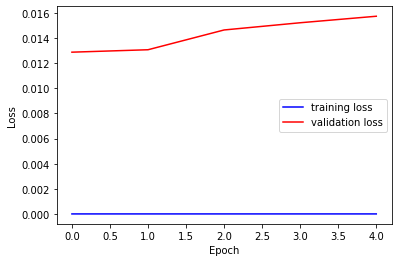

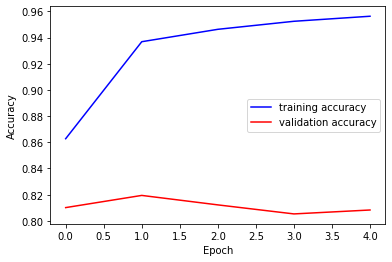

In [14]:
import matplotlib.pyplot as plt
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(0, len(trainloss)), trainloss, color = 'blue', label = 'training loss')
plt.plot(range(0, len(validloss)), validloss, color = 'red', label = 'validation loss')
plt.legend()
plt.show()

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(range(0, len(trainaccu)), trainaccu, color = 'blue', label = 'training accuracy')
plt.plot(range(0, len(validaccu)), validaccu, color = 'red', label = 'validation accuracy')
plt.legend()
plt.show()


In [15]:
import csv
with open('./model/output.csv','w',newline='') as f:
  w = csv.writer(f)
  w.writerow(trainloss)
  w.writerow(validloss)
  w.writerow(trainaccu)
  w.writerow(validaccu)

In [16]:
valid_result= []
for i in range(0, np.size(valid_output,0)):
  if valid_output[i][0] >= valid_output[i][1]:
    valid_result.append(0)
  else: 
    valid_result.append(1)


AUC=  0.808


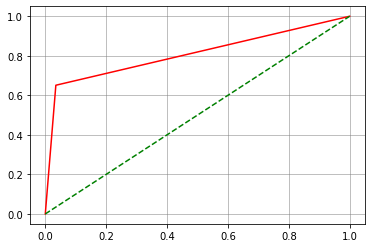

Accuracy=  0.808
Sensitivity=  0.735
Specificity=  0.949
Precision=  0.965
Negative Predictive Value=  0.651


In [17]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
##y_valid= np.array(y_valid, dtype= bool)
##valid_result= np.array(valid_result, dtype= bool)
print("AUC= ", round(roc_auc_score(y_valid, valid_result),3))
fpr, tpr, thresholds = roc_curve(y_valid, valid_result, pos_label= 1)
plt.plot(fpr, tpr, color= 'red', label= 'ROC curve (area = %0.2f)')
plt.grid(color= 'grey', linewidth= 0.5)
plt.plot([0,1], [0,1], color= 'green', linestyle= '--')
plt.show()

from sklearn.metrics import accuracy_score
print("Accuracy= ", round(accuracy_score(valid_result, y_valid), 3))

from sklearn.metrics import confusion_matrix
cnf = confusion_matrix(y_valid, valid_result)
tp = cnf[0][0]
fp = cnf[0][1]
tn = cnf[1][1]
fn = cnf[1][0]
print("Sensitivity= ", round(tp/(tp+fn), 3))
print("Specificity= ", round(tn/(tn+fp), 3))
print("Precision= ", round(tp/(tp+fp), 3))
print("Negative Predictive Value= ", round(tn/(tn+fn), 3))

In [18]:
!cp -r /content/model/checkpoint.ckpt /content/drive/MyDrive
!cp -r /content/model/output.csv /content/drive/MyDrive

In [ ]:
import torch
import torch.nn as nn

from functools import partial
from dataclasses import dataclass
from collections import OrderedDict

class Conv2dAuto(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.padding =  (self.kernel_size[0] // 2, self.kernel_size[1] // 2)
        
conv3x3 = partial(Conv2dAuto, kernel_size=3, bias=False)  

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels, self.out_channels =  in_channels, out_channels
        self.blocks = nn.Identity()
        self.shortcut = nn.Identity()   
    
    def forward(self, x):
        residual = x
        if self.should_apply_shortcut: residual = self.shortcut(x)
        x = self.blocks(x)
        x += residual
        return x
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.out_channels

from collections import OrderedDict

class ResNetResidualBlock(ResidualBlock):
    def __init__(self, in_channels, out_channels, expansion=1, downsampling=1, conv=conv3x3, *args, **kwargs):
        super().__init__(in_channels, out_channels)
        self.expansion, self.downsampling, self.conv = expansion, downsampling, conv
        self.shortcut = nn.Sequential(OrderedDict(
        {
            'conv' : nn.Conv2d(self.in_channels, self.expanded_channels, kernel_size=1,
                      stride=self.downsampling, bias=False),
            'bn' : nn.BatchNorm2d(self.expanded_channels)
            
        })) if self.should_apply_shortcut else None
        
        
    @property
    def expanded_channels(self):
        return self.out_channels * self.expansion
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.expanded_channels

from collections import OrderedDict
def conv_bn(in_channels, out_channels, conv, *args, **kwargs):
    return nn.Sequential(OrderedDict({'conv': conv(in_channels, out_channels, *args, **kwargs), 
                          'bn': nn.BatchNorm2d(out_channels) }))

class ResNetBasicBlock(ResNetResidualBlock):
    expansion = 1
    def __init__(self, in_channels, out_channels, activation=nn.ReLU, *args, **kwargs):
        super().__init__(in_channels, out_channels, *args, **kwargs)
        self.blocks = nn.Sequential(
            conv_bn(self.in_channels, self.out_channels, conv=self.conv, bias=False, stride=self.downsampling),
            activation(),
            conv_bn(self.out_channels, self.expanded_channels, conv=self.conv, bias=False),
        )

class ResNetBottleNeckBlock(ResNetResidualBlock):
    expansion = 4
    def __init__(self, in_channels, out_channels, activation=nn.ReLU, *args, **kwargs):
        super().__init__(in_channels, out_channels, expansion=4, *args, **kwargs)
        self.blocks = nn.Sequential(
           conv_bn(self.in_channels, self.out_channels, self.conv, kernel_size=1),
             activation(),
             conv_bn(self.out_channels, self.out_channels, self.conv, kernel_size=3, stride=self.downsampling),
             activation(),
             conv_bn(self.out_channels, self.expanded_channels, self.conv, kernel_size=1),
        )

class ResNetLayer(nn.Module):
    def __init__(self, in_channels, out_channels, block=ResNetBasicBlock, n=1, *args, **kwargs):
        super().__init__()
        # 'We perform downsampling directly by convolutional layers that have a stride of 2.'
        downsampling = 2 if in_channels != out_channels else 1
        
        self.blocks = nn.Sequential(
            block(in_channels , out_channels, *args, **kwargs, downsampling=downsampling),
            *[block(out_channels * block.expansion, 
                    out_channels, downsampling=1, *args, **kwargs) for _ in range(n - 1)]
        )

    def forward(self, x):
        x = self.blocks(x)
        return x

class ResNetEncoder(nn.Module):
    """
    ResNet encoder composed by increasing different layers with increasing features.
    """
    def __init__(self, in_channels=3, blocks_sizes=[64, 128, 256, 512], deepths=[2,2,2,2], 
                 activation=nn.ReLU, block=ResNetBasicBlock, *args,**kwargs):
        super().__init__()
        
        self.blocks_sizes = blocks_sizes
        
        self.gate = nn.Sequential(
            nn.Conv2d(in_channels, self.blocks_sizes[0], kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(self.blocks_sizes[0]),
            activation(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        self.in_out_block_sizes = list(zip(blocks_sizes, blocks_sizes[1:]))
        self.blocks = nn.ModuleList([ 
            ResNetLayer(blocks_sizes[0], blocks_sizes[0], n=deepths[0], activation=activation, 
                        block=block,  *args, **kwargs),
            *[ResNetLayer(in_channels * block.expansion, 
                          out_channels, n=n, activation=activation, 
                          block=block, *args, **kwargs) 
              for (in_channels, out_channels), n in zip(self.in_out_block_sizes, deepths[1:])]       
        ])
        
        
    def forward(self, x):
      x = self.gate(x)
      for block in self.blocks:
          x = block(x)
      return x

class ResnetDecoder(nn.Module):
    """
    This class represents the tail of ResNet. It performs a global pooling and maps the output to the
    correct class by using a fully connected layer.
    """
    def __init__(self, in_features, n_classes):
        super().__init__()
        self.avg = nn.AdaptiveAvgPool2d((1, 1))
        self.decoder = nn.Linear(in_features, n_classes)

    def forward(self, x):
        x = self.avg(x)
        x = x.view(x.size(0), -1)
        x = self.decoder(x)
        return x

class ResNet(nn.Module):
    
    def __init__(self, in_channels, n_classes, *args, **kwargs):
        super().__init__()
        self.encoder = ResNetEncoder(in_channels, *args, **kwargs)
        self.decoder = ResnetDecoder(self.encoder.blocks[-1].blocks[-1].expanded_channels, n_classes)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

def resnet18(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBasicBlock, deepths=[2, 2, 2, 2])

def resnet34(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBasicBlock, deepths=[3, 4, 6, 3])

def resnet50(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBottleNeckBlock, deepths=[3, 4, 6, 3])

def resnet101(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBottleNeckBlock, deepths=[3, 4, 23, 3])

def resnet152(in_channels, n_classes):
    return ResNet(in_channels, n_classes, block=ResNetBottleNeckBlock, deepths=[3, 8, 36, 3])